In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from torch.utils.data import Dataset, DataLoader
import torch
from distutils.util import strtobool
import random

from scipy.stats import norm
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import pandas as pd

# This is just until temporary implementation
import os 
import sys
cwd = os.getcwd()
sys.path.insert(0,cwd + '/../timetransformers')

import Transformer 
from utils import convert_tsf_to_dataframe

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
if not os.path.exists("../data"):
    # If the directory does not exist, create it
    os.makedirs("../data")
    print(f"Directory data created.")
else:
    print(f"Directory data already exists.")

!zenodo_get 10.5281/zenodo.5184708 # This is a wikipedia data set
!mv oikolab_weather_dataset.zip ../data/oikolab_weather_dataset.zip
!unzip -o ../data/oikolab_weather_dataset.zip -d ../data/
!rm md5sums.txt

Directory data already exists.
Title: Oikolab Weather Dataset
Keywords: weather, forecasting, hourly series
Publication date: 2021-08-12
DOI: 10.5281/zenodo.5184708
Total size: 1.3 MB

Link: https://zenodo.org/record/5184708/files/oikolab_weather_dataset.zip   size: 1.3 MB
100% [......................................................] 1326101 / 1326101
Checksum is correct. (40675cede7f925e3f0734ccd813f761b)
All files have been downloaded.
Archive:  ../data/oikolab_weather_dataset.zip
  inflating: ../data/oikolab_weather_dataset.tsf  


In [4]:
test_data = convert_tsf_to_dataframe("../data/oikolab_weather_dataset.tsf")

In [5]:
df = test_data[0]
df.shape
data_list = list(df["type"].unique())
# data_list.remove("mean_sea_level_pressure")
df

series_name start_timestamp                       type  \
0          T1      2010-01-01                temperature   
1          T2      2010-01-01       dewpoint_temperature   
2          T3      2010-01-01                 wind_speed   
3          T4      2010-01-01    mean_sea_level_pressure   
4          T5      2010-01-01          relative_humidity   
5          T6      2010-01-01    surface_solar_radiation   
6          T7      2010-01-01  surface_thermal_radiation   
7          T8      2010-01-01          total_cloud_cover   

                                        series_value  
0  [18.26, 18.67, 18.16, 18.46, 18.53, 18.92, 19....  
1  [16.39, 16.29, 15.89, 15.33, 15.11, 15.16, 15....  
2  [2.6, 2.91, 3.26, 3.17, 2.95, 2.62, 2.87, 3.01...  
3  [101046.38, 101037.96, 101017.26, 101022.56, 1...  
4  [0.89, 0.86, 0.87, 0.82, 0.8, 0.79, 0.77, 0.76...  
5  [287.01, 360.79, 291.54, 357.11, 459.91, 513.0...  
6  [408.35, 411.02, 410.67, 410.95, 410.0, 407.46...  
7  [1.0, 1.0, 1.0, 1.0, 0.9, 0.96, 0.94, 0.9, 0.8...

In [6]:
print(data_list)

['temperature', 'dewpoint_temperature', 'wind_speed', 'mean_sea_level_pressure', 'relative_humidity', 'surface_solar_radiation', 'surface_thermal_radiation', 'total_cloud_cover']


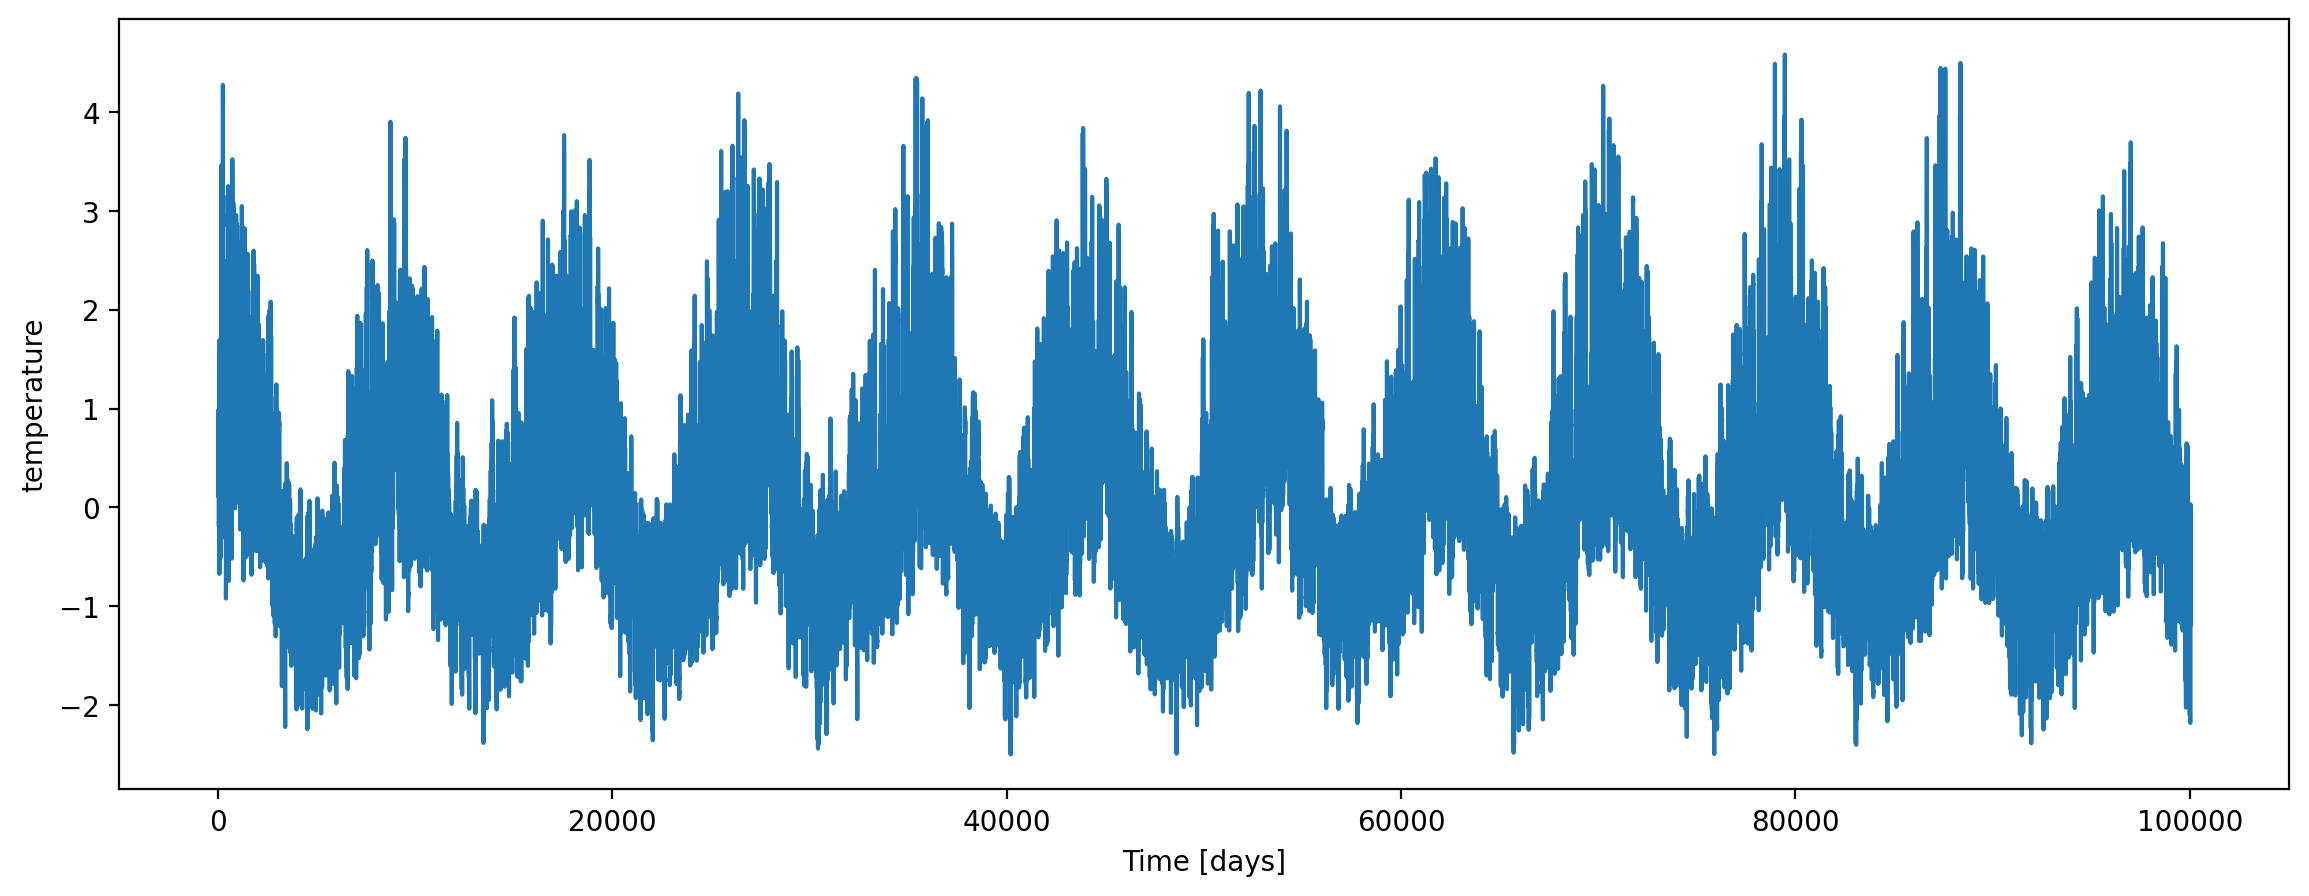

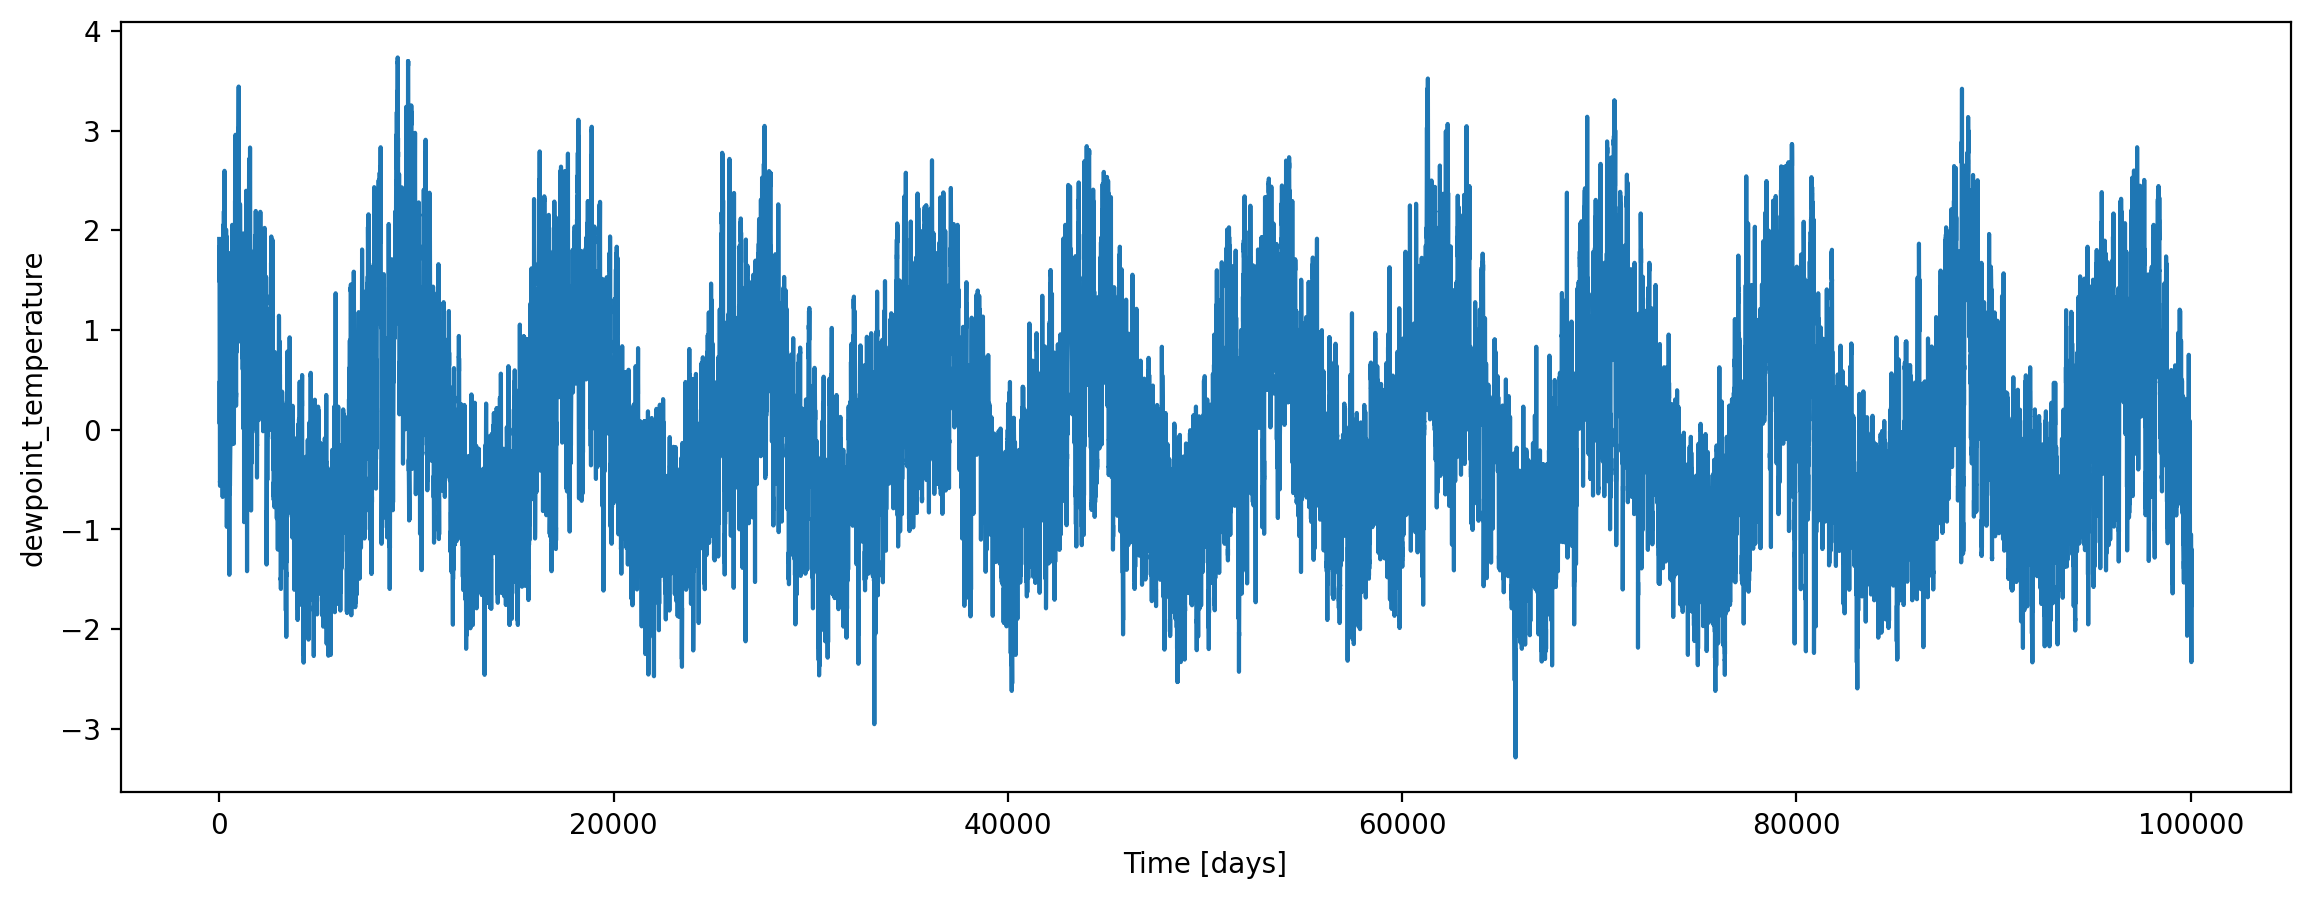

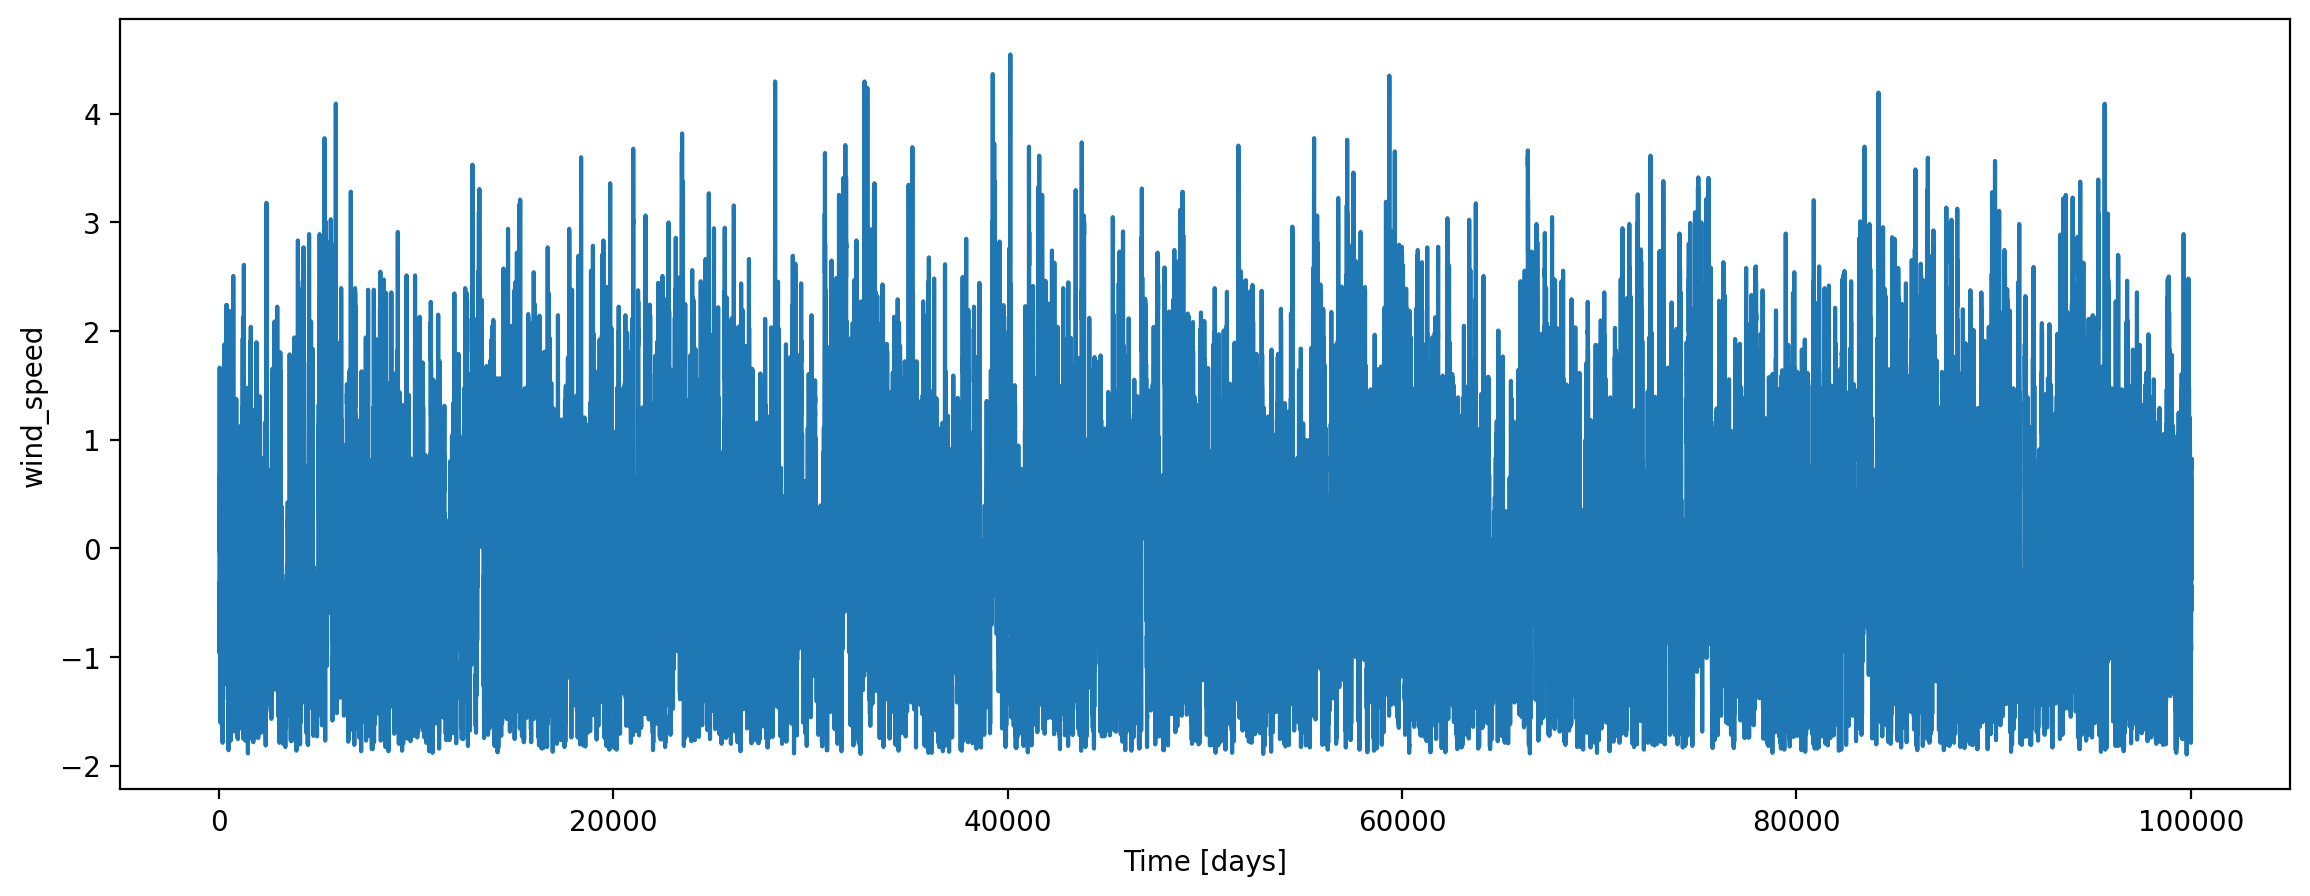

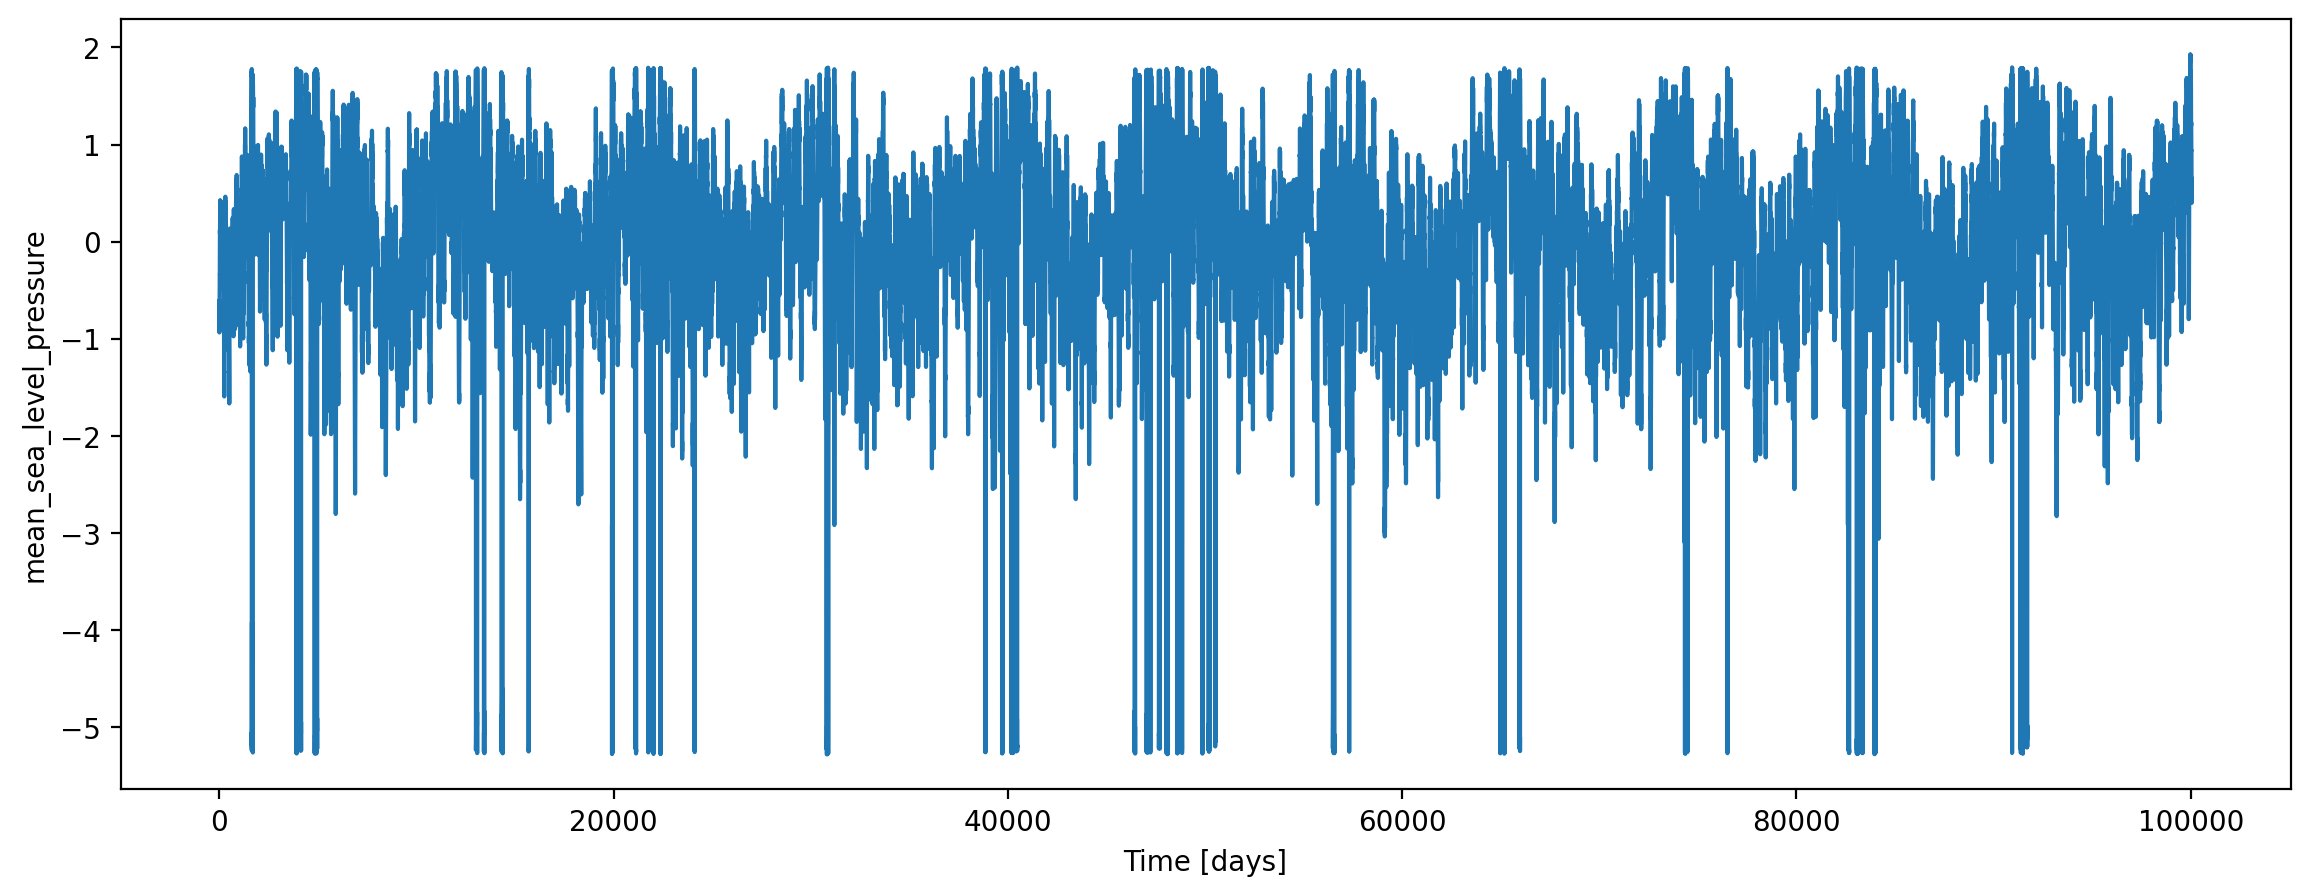

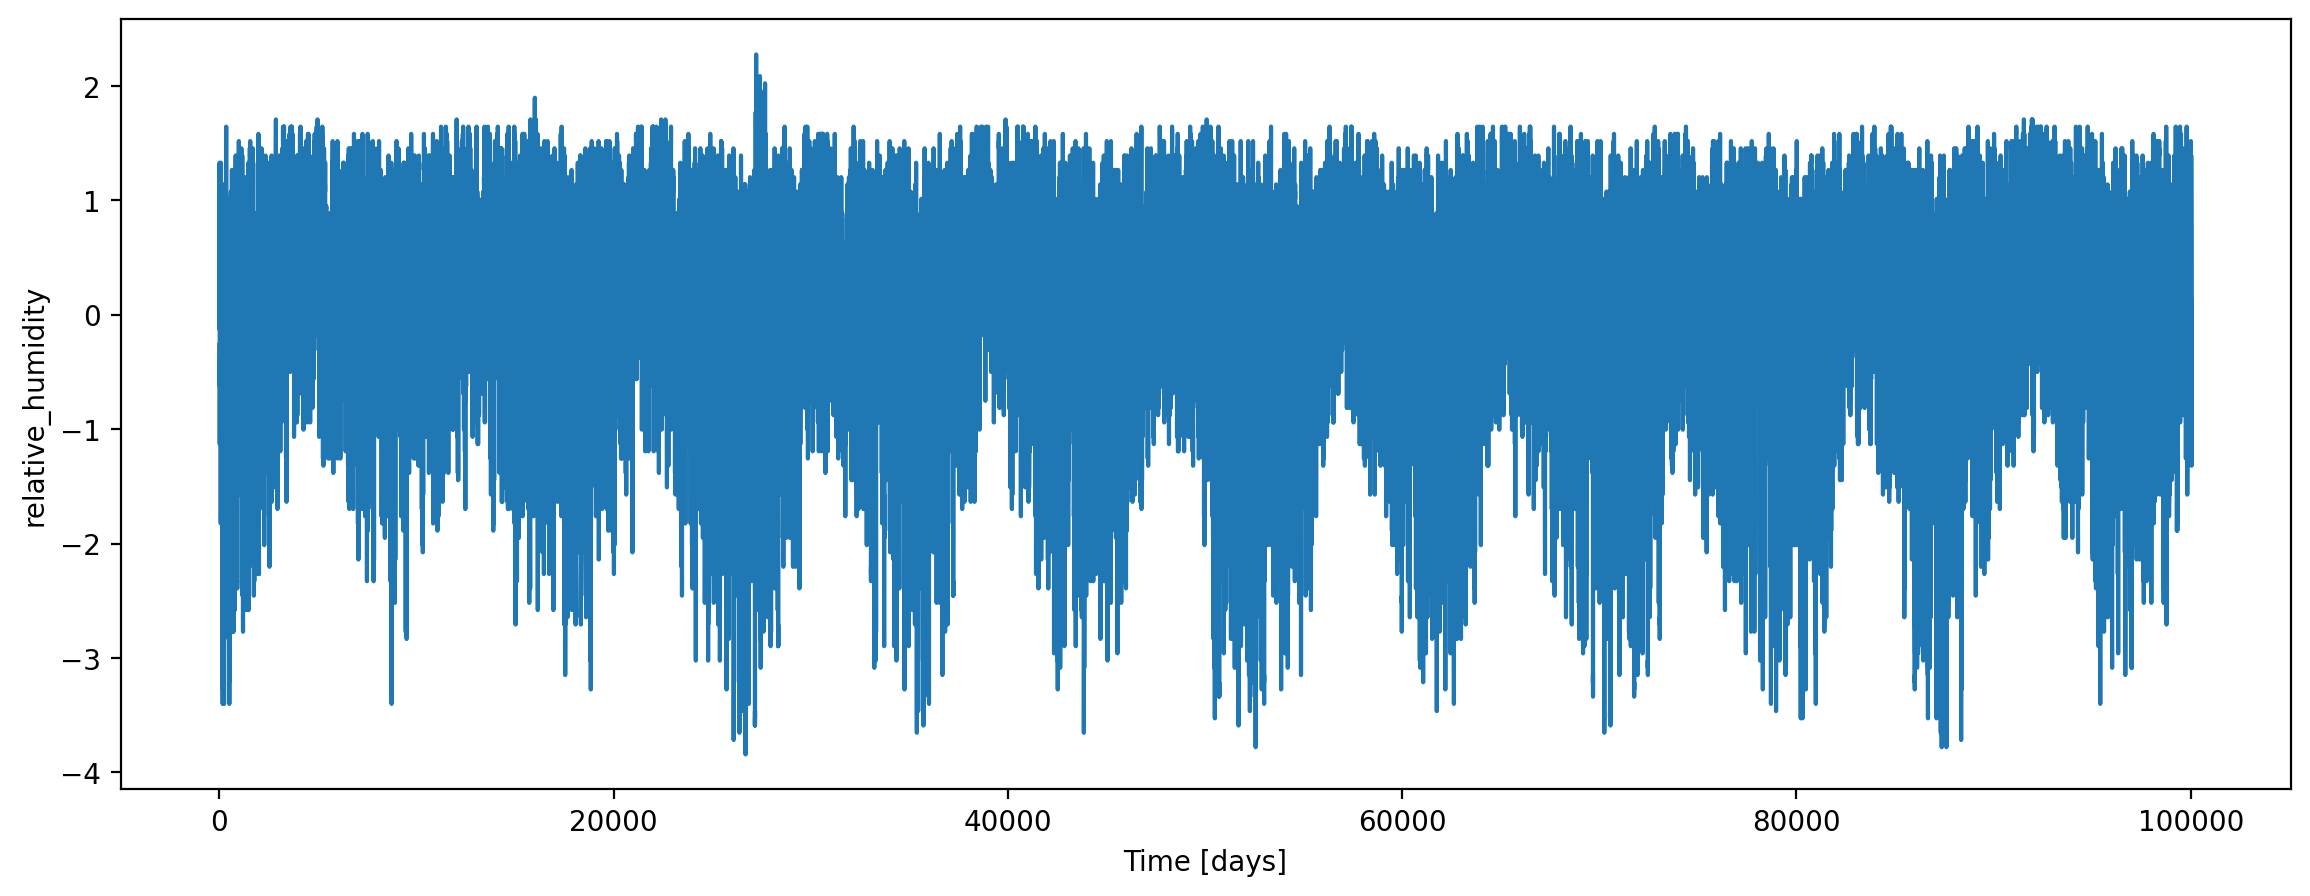

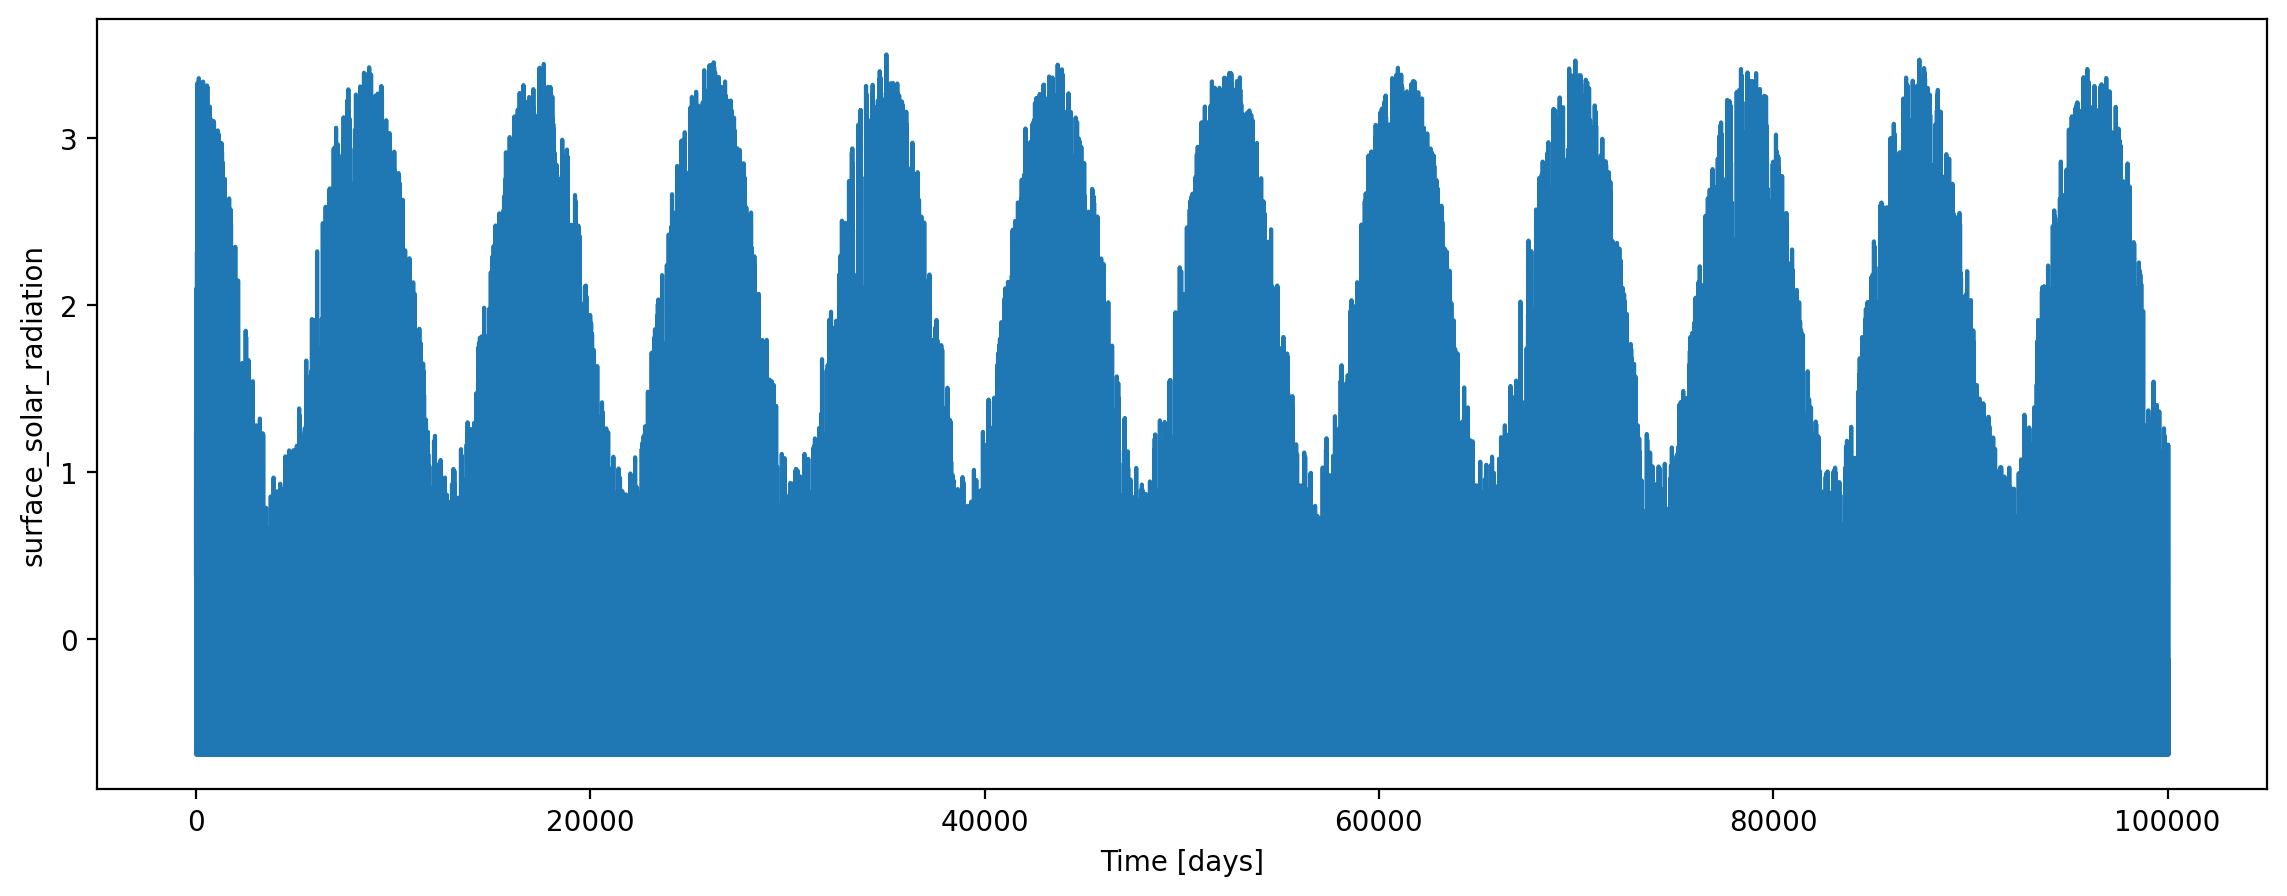

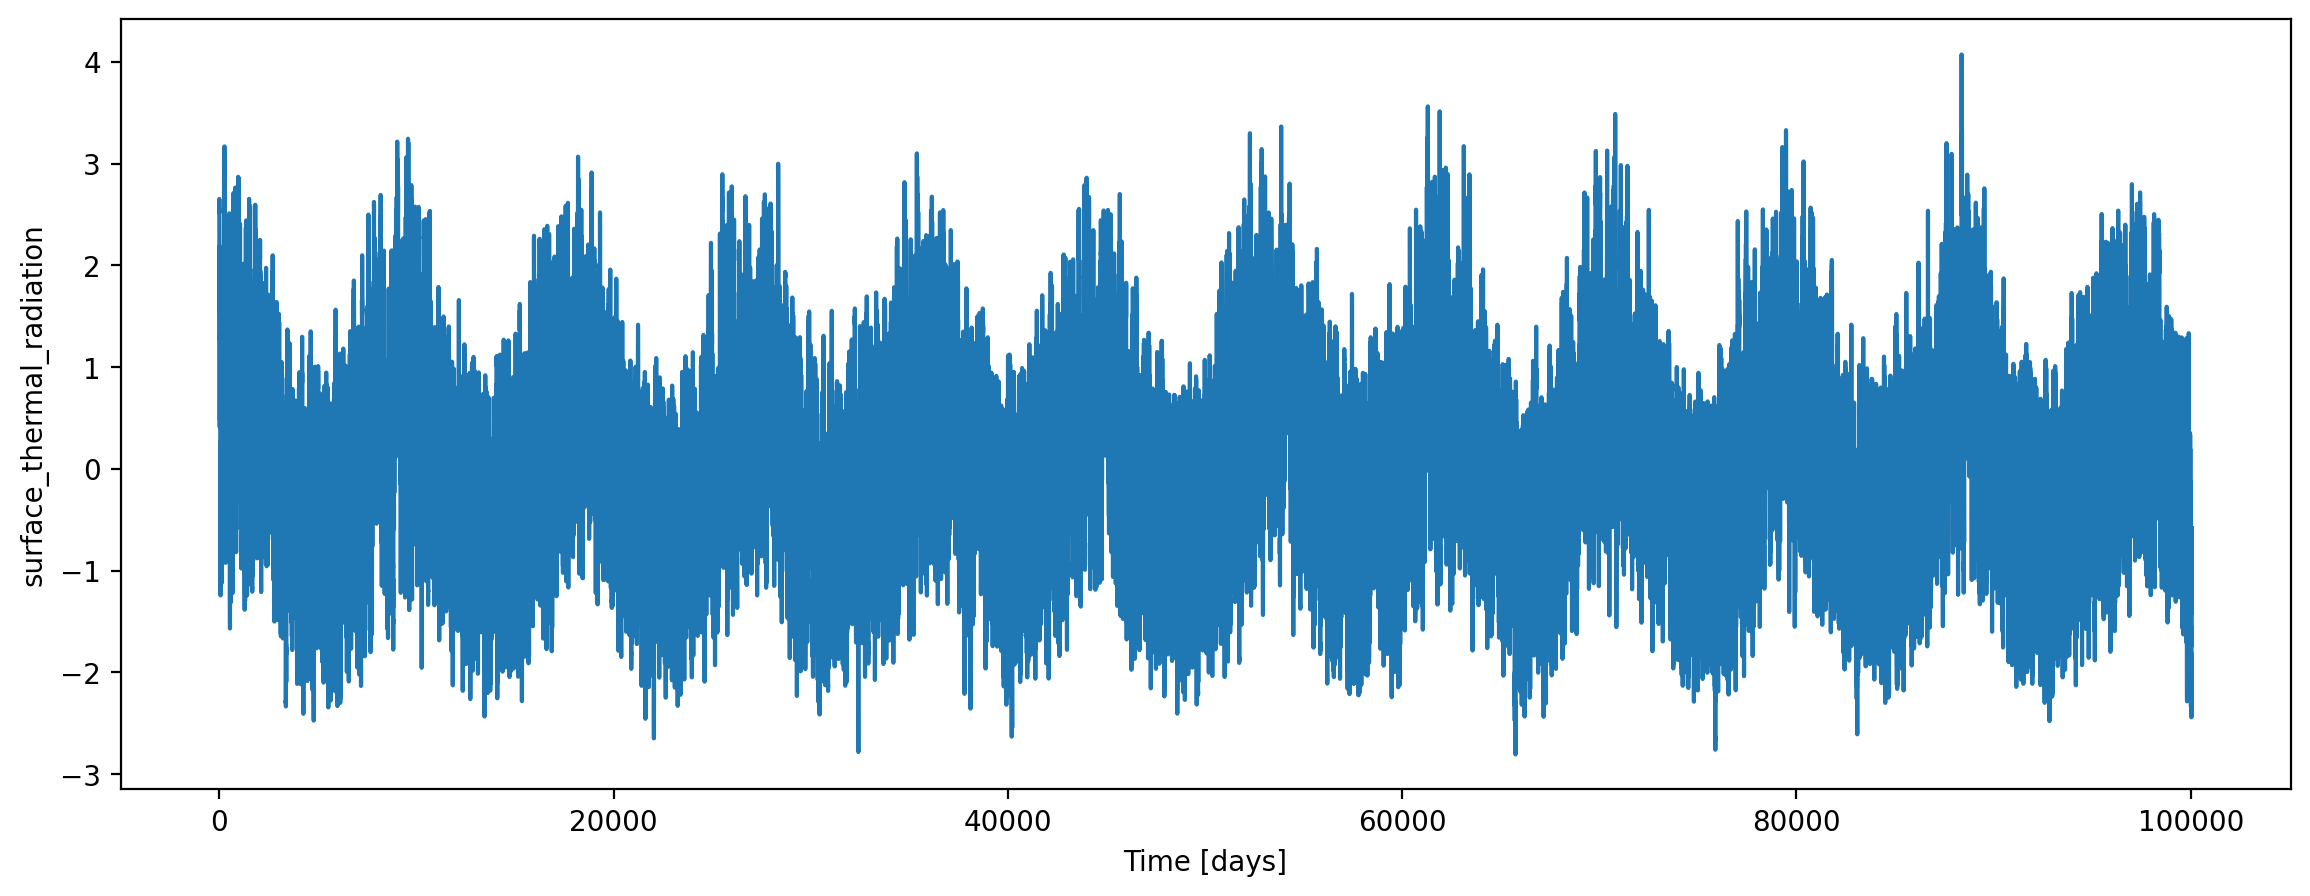

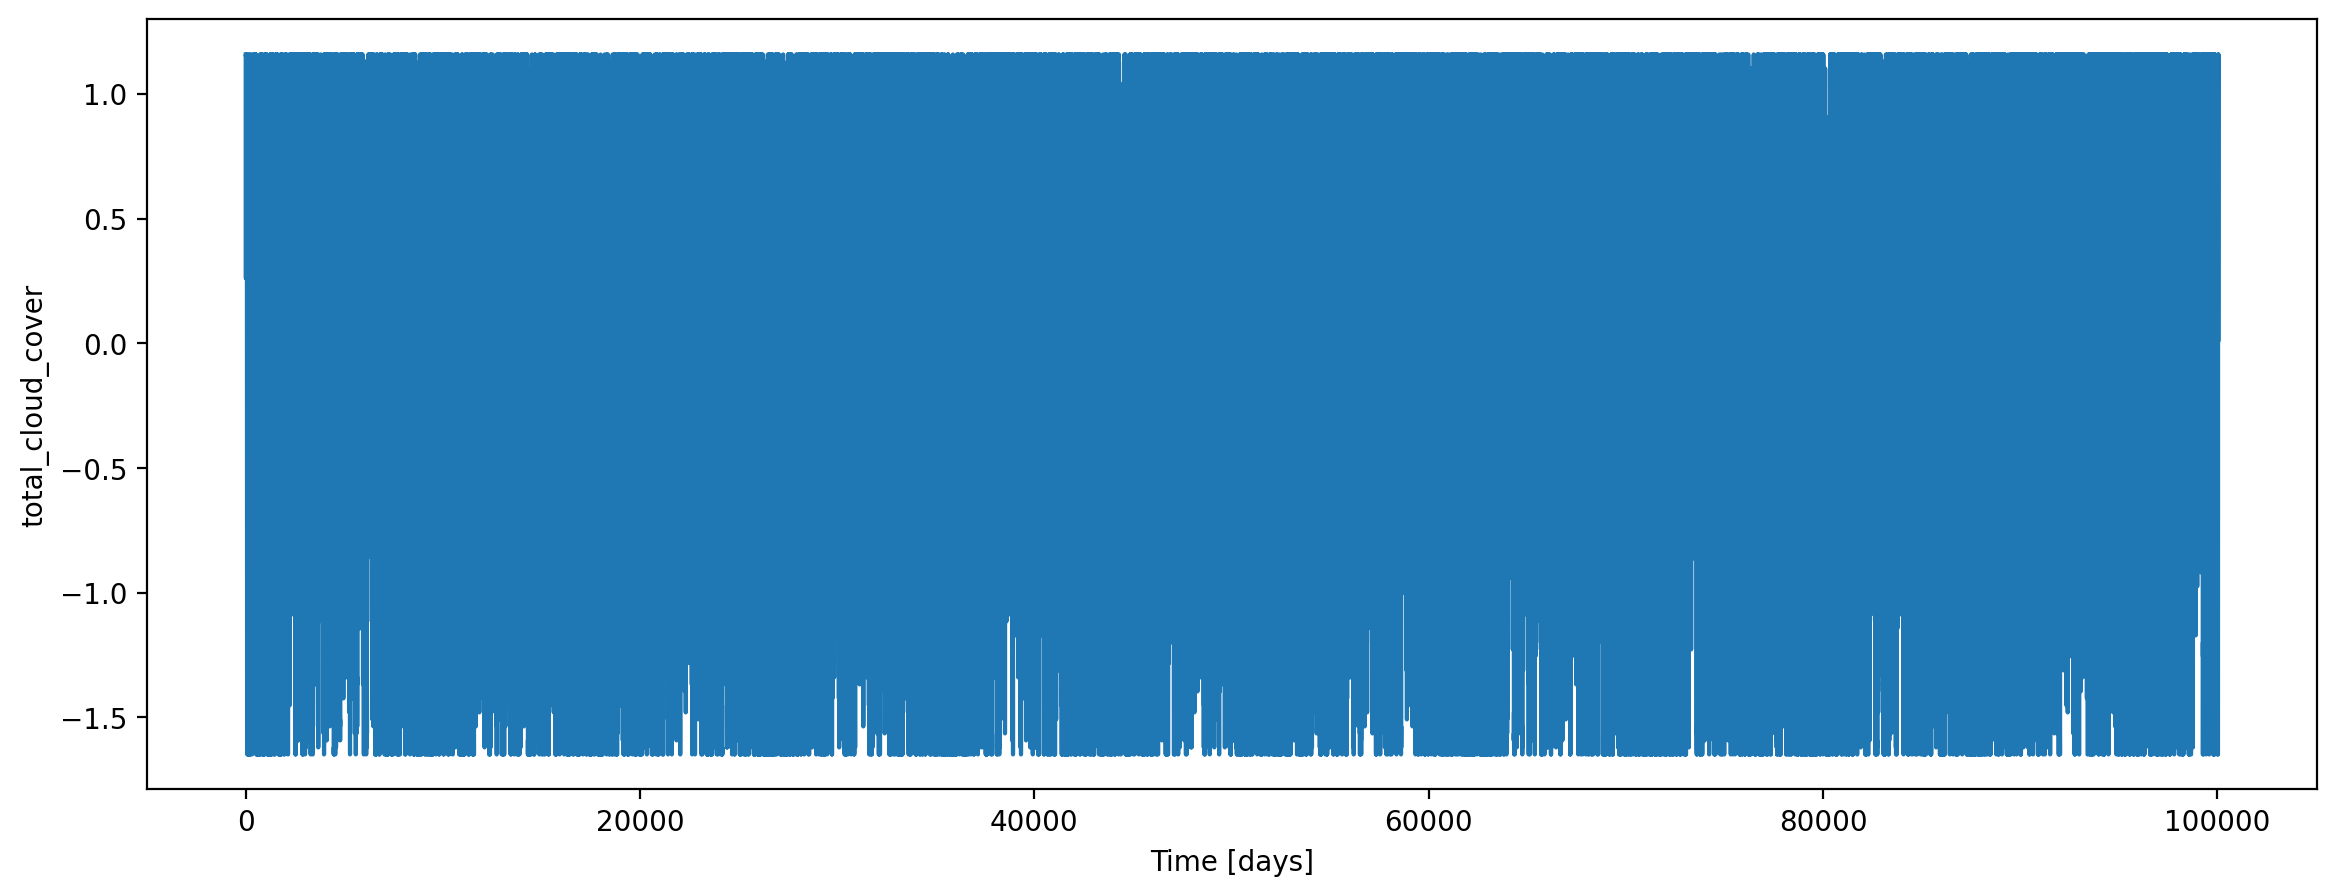

(8, 100057)


In [24]:
# List of values to select
# values_to_select = ["T_MEAN", "T_MAX", "T_MIN"]
# values_to_select = ["PRCP_SUM"]

# Filter the DataFrame
filtered_df = df[df["type"].isin(data_list)]

# Select the 'series_value' column from the filtered DataFrame
selected_series_values = filtered_df["series_value"]

# T_means_ = df[df["obs_or_fcst"] == ("T_MEAN", "PRCP_SUM")]["series_value"]
selected_series_values = selected_series_values.to_numpy()


def fill_nans(array):
    array = pd.Series(array)
    array.ffill(inplace=True)  # Forward fill
    array.bfill(inplace=True)
    return array.to_numpy()


N_data = selected_series_values.shape[0]
# N_data = 10
training_data = selected_series_values[0].astype(float)

for i in range(1, N_data):
    new_data = fill_nans(selected_series_values[i].to_numpy().astype(float))
    # new_data[np.isnan(new_data)] = 0.0
    training_data = np.vstack((training_data, new_data))

for i in range(N_data):
    plt.figure(figsize=(14, 5))
    mu = np.mean(training_data[i])
    std = np.std(training_data[i])
    plt.plot((training_data[i] - mu) / std, label="Data")
    plt.ylabel(data_list[i])
    plt.xlabel("Time [days]")
    plt.show()

print(training_data.shape)

In [25]:
def gen_sin_training_data(batch_size, length):
    # Generate random start points
    times = torch.arange(0, length)
    y_vals = torch.stack(
        [torch.sin(0.05 * times) + torch.randn(length) * 0.1 for _ in range(batch_size)]
    )
    # The v values for the training should be the next data point
    return y_vals


training_data = np.vstack(
    (
        training_data,
        gen_sin_training_data(training_data.shape[0], training_data.shape[1]),
    )
)
print(training_data.shape)

(16, 100057)


In [26]:
device = torch.device("mps")

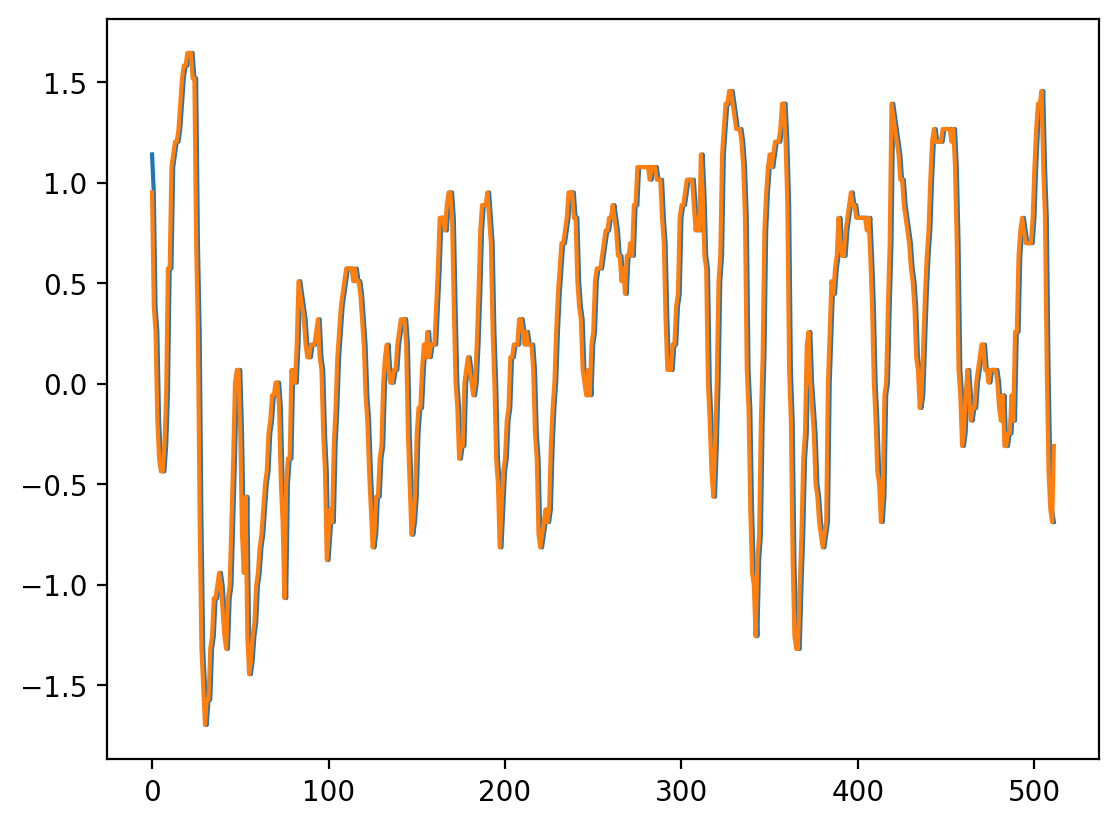

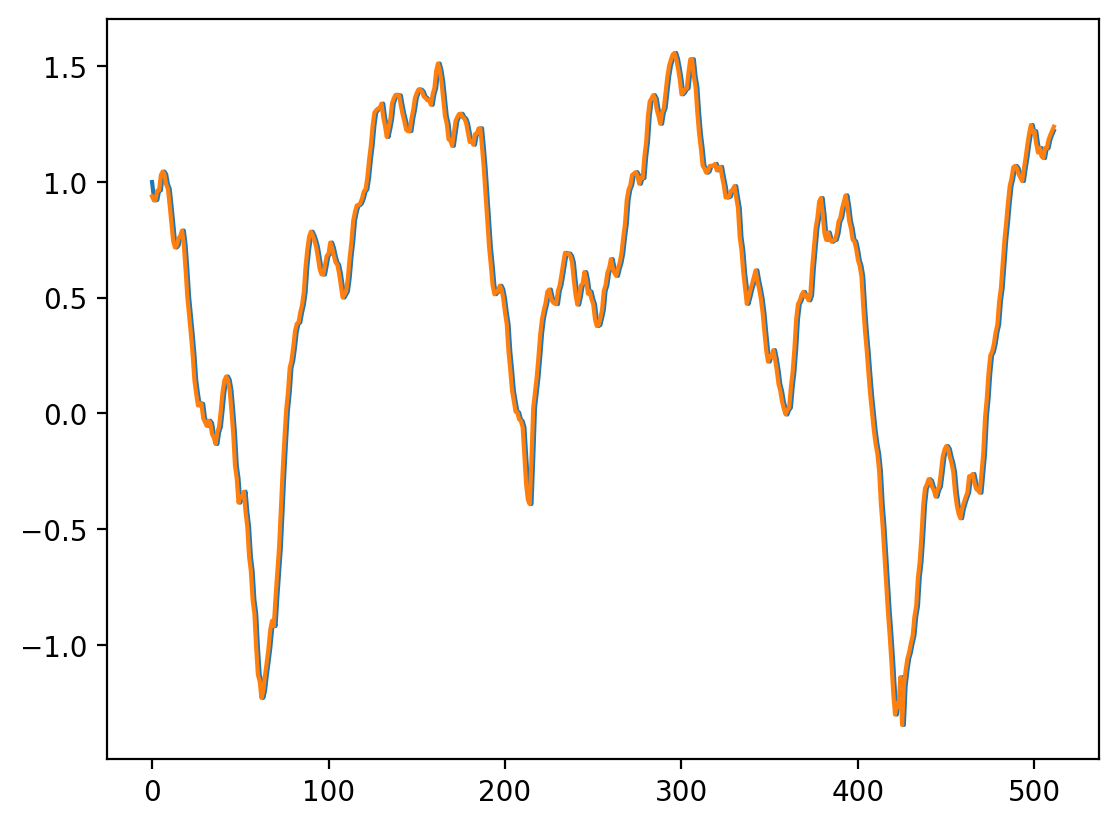

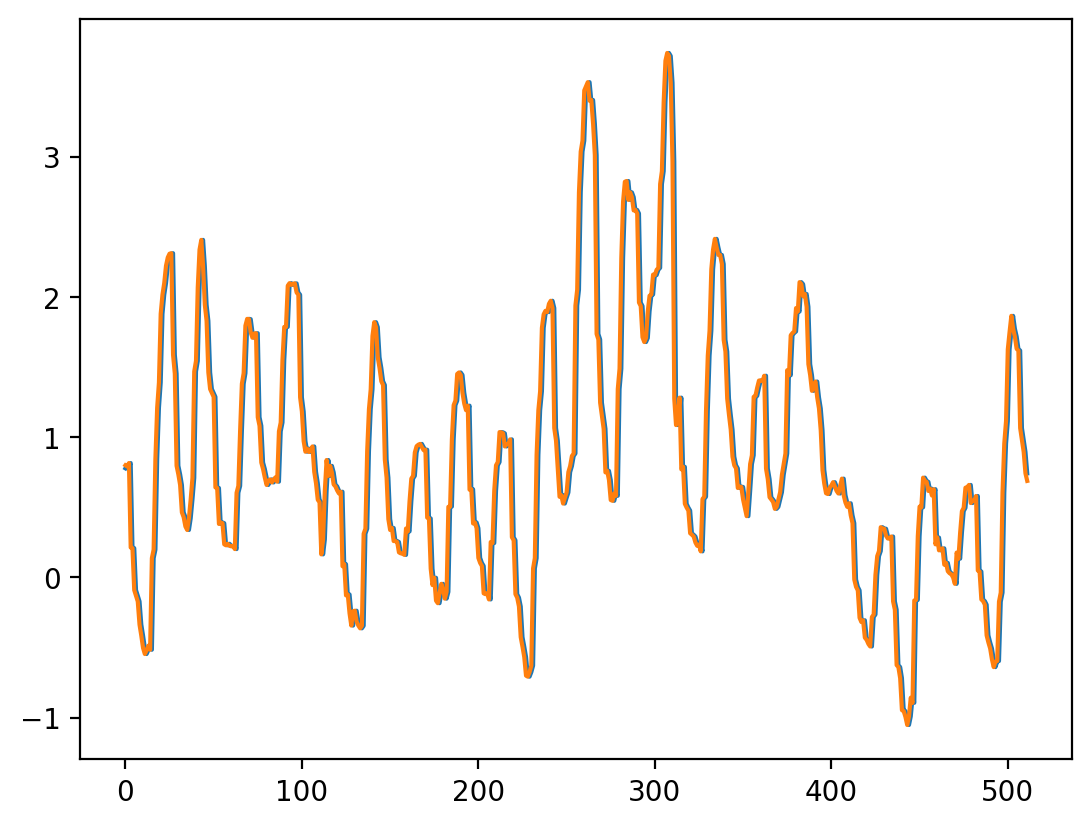

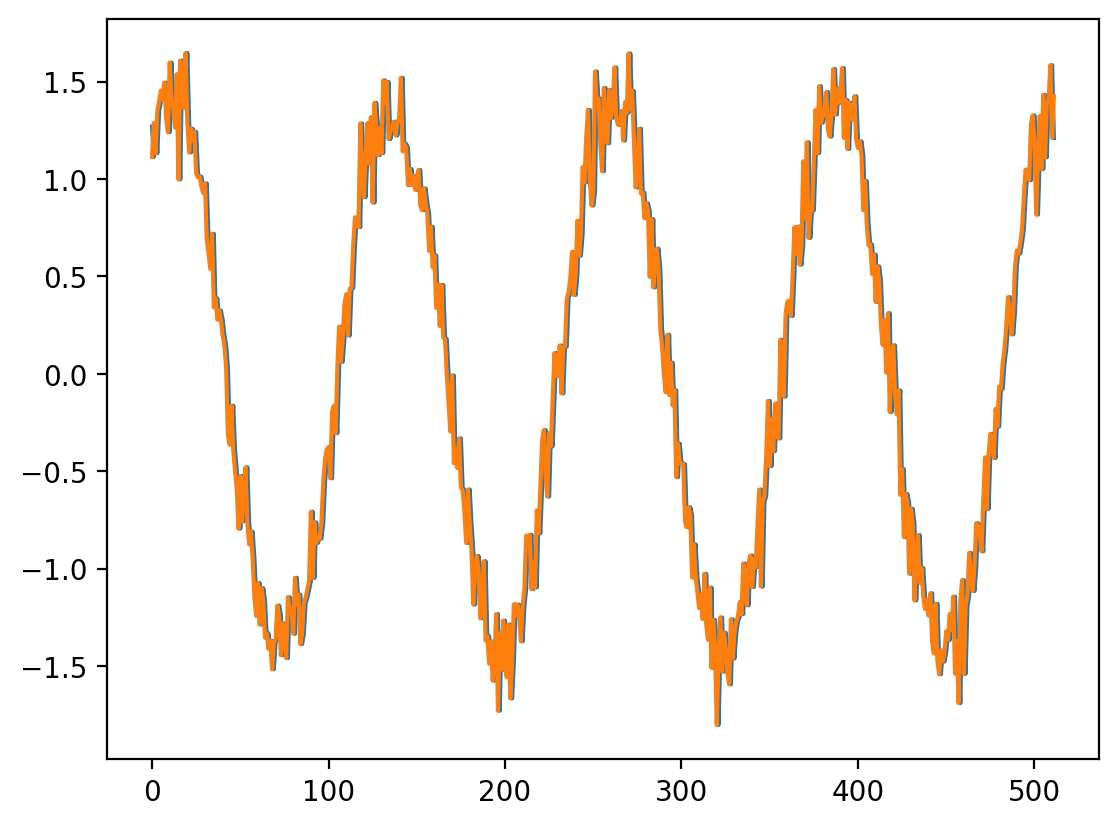

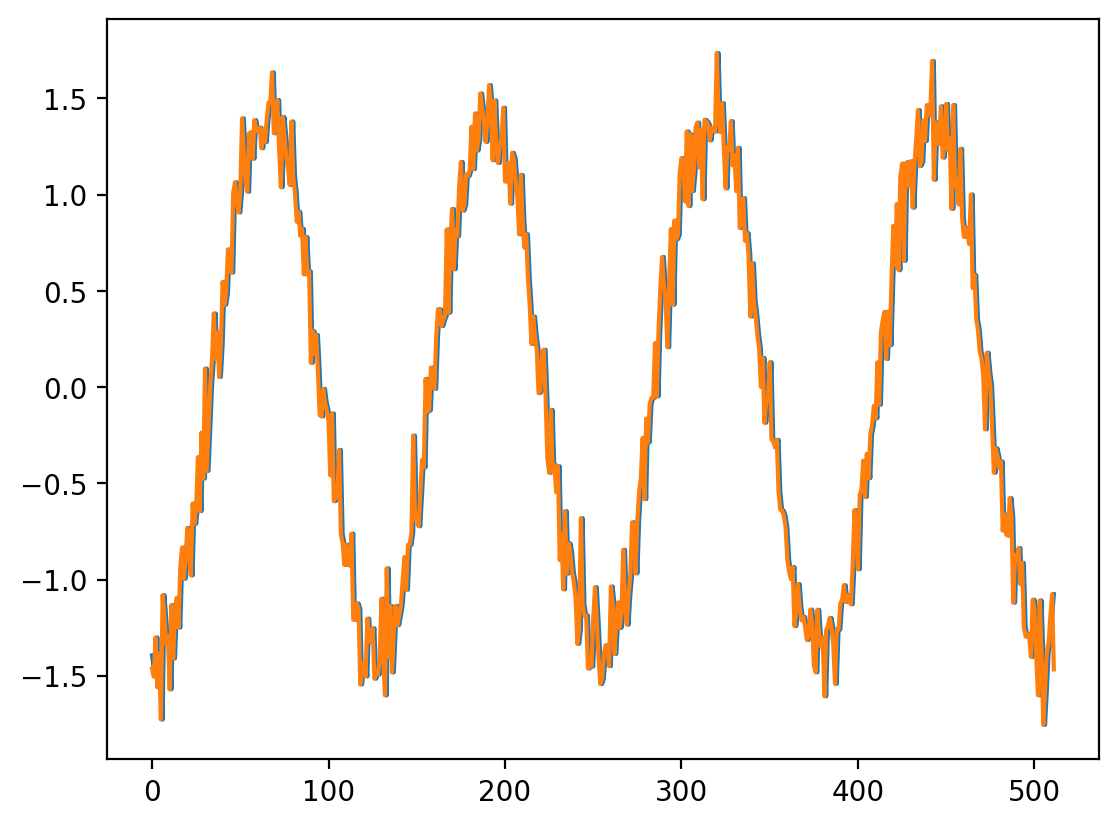

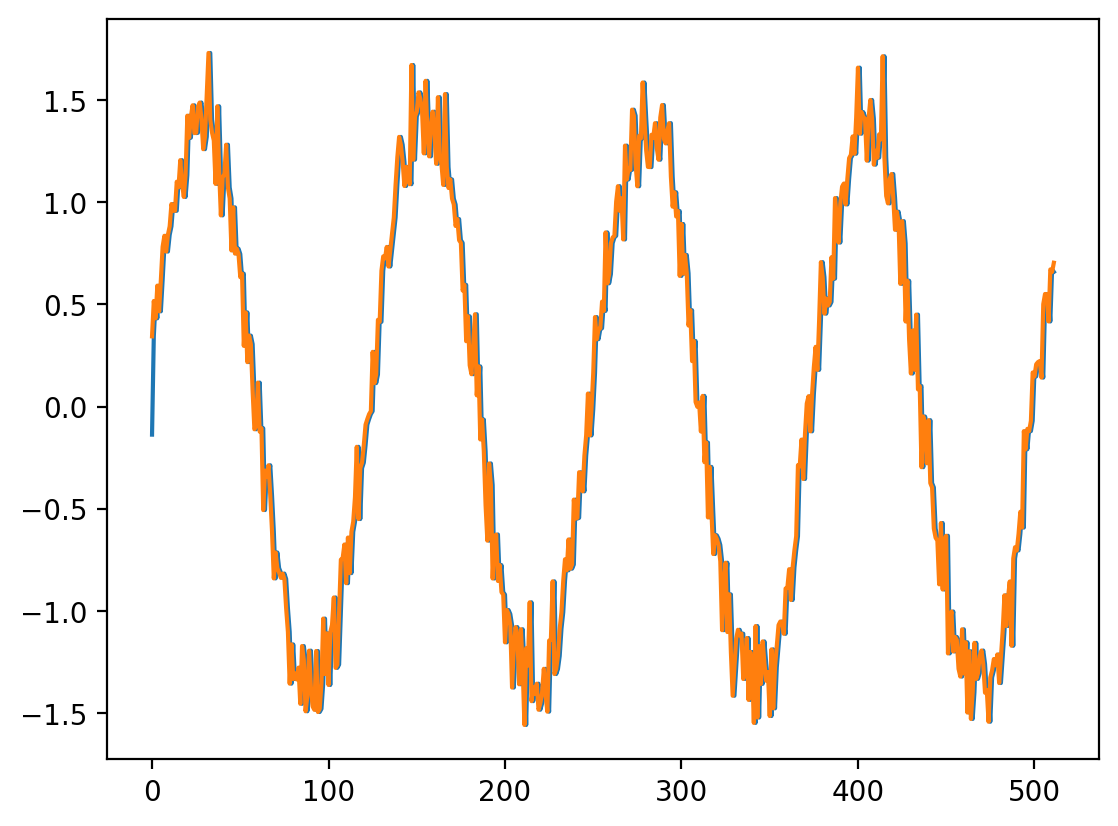

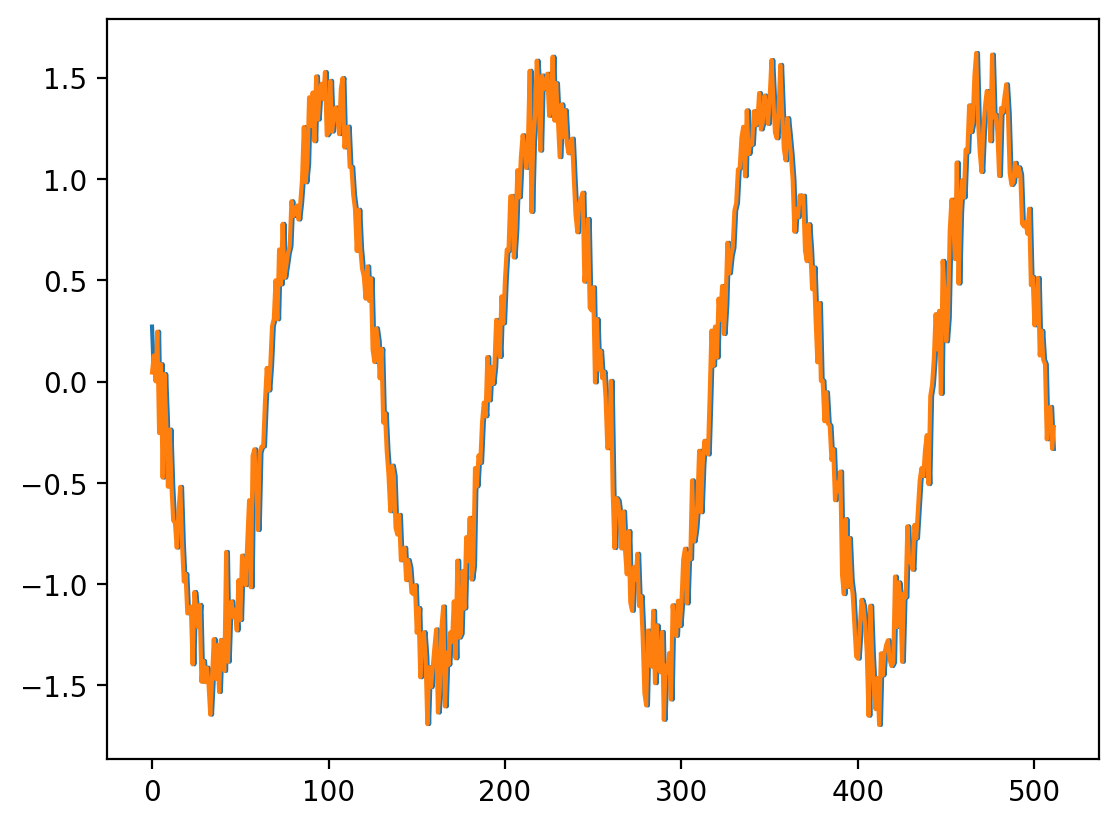

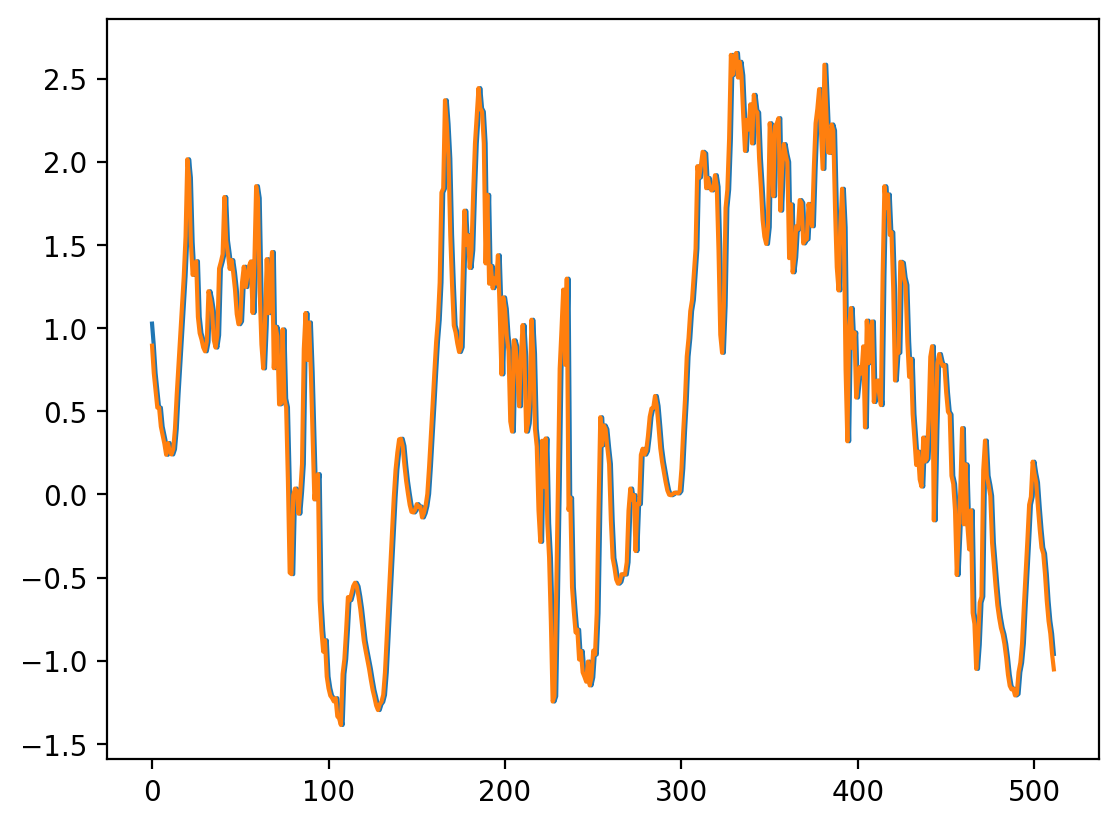

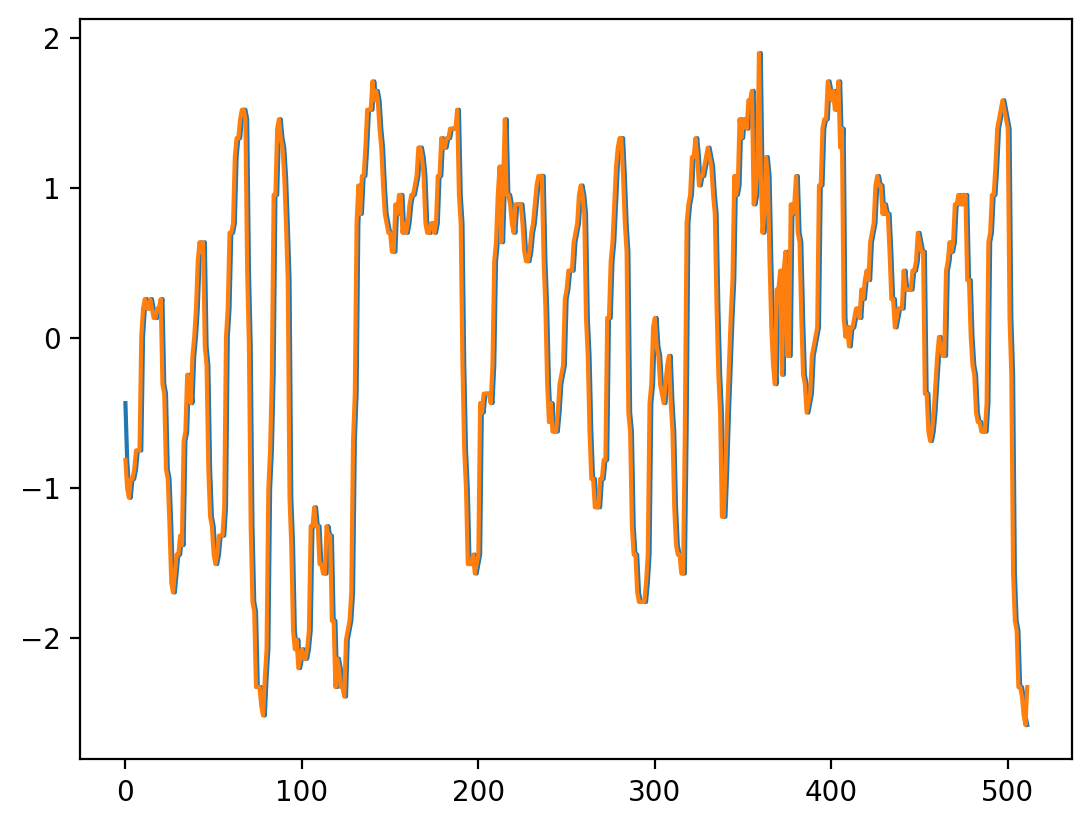

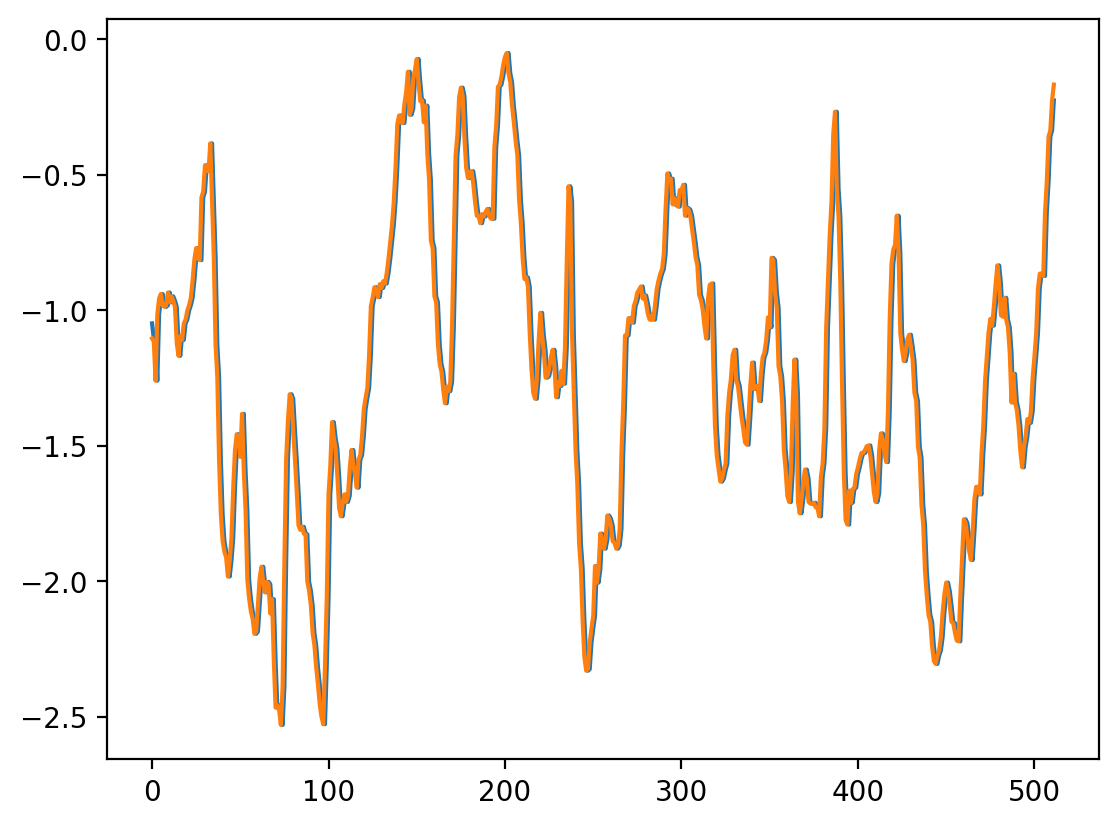

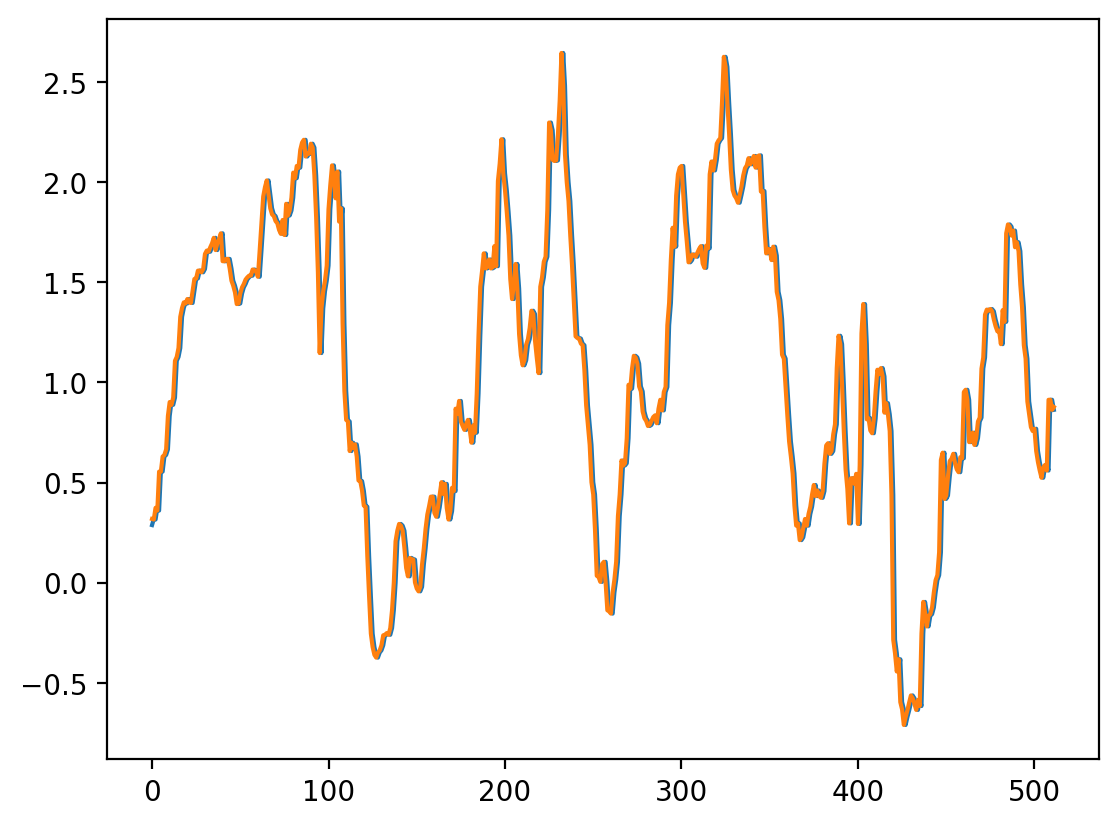

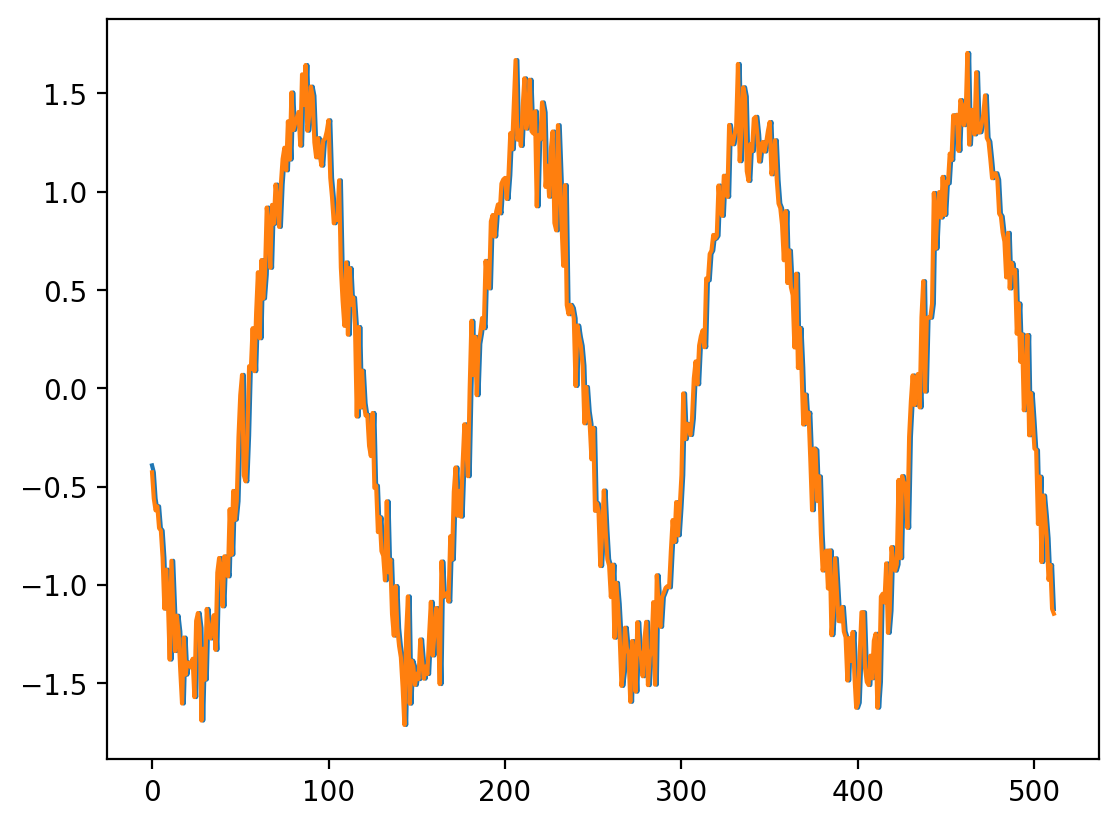

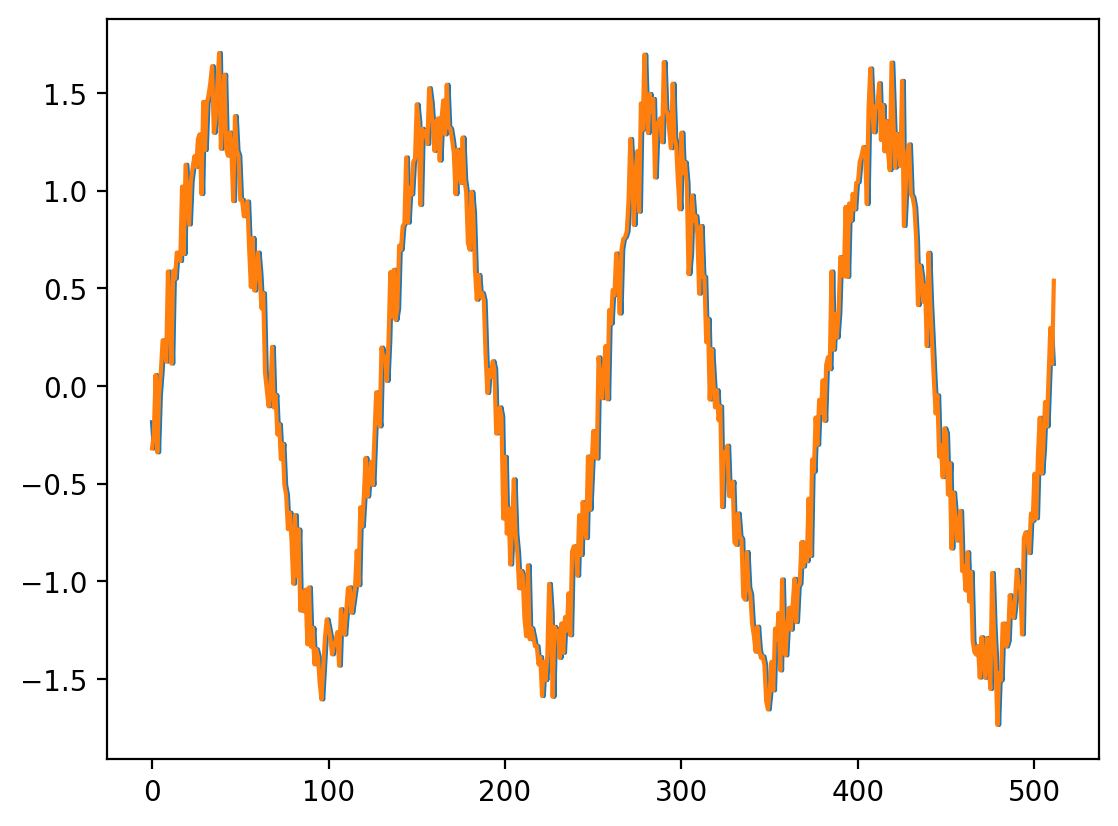

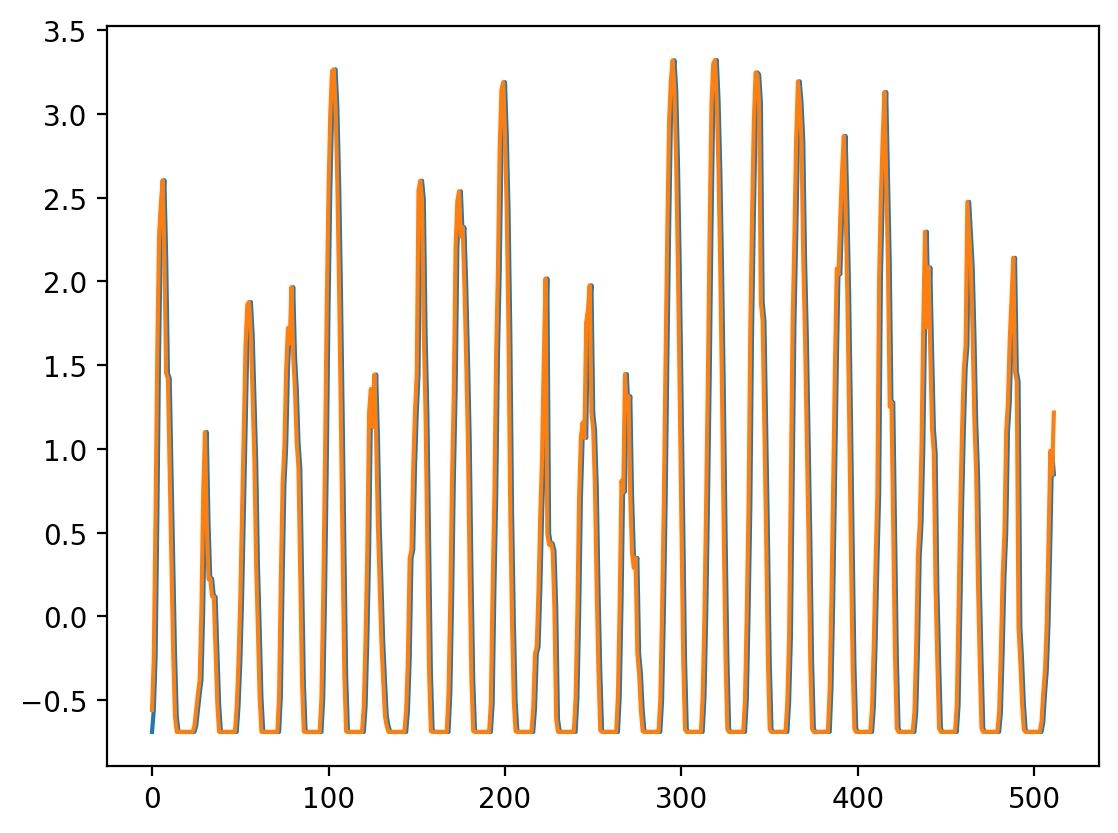

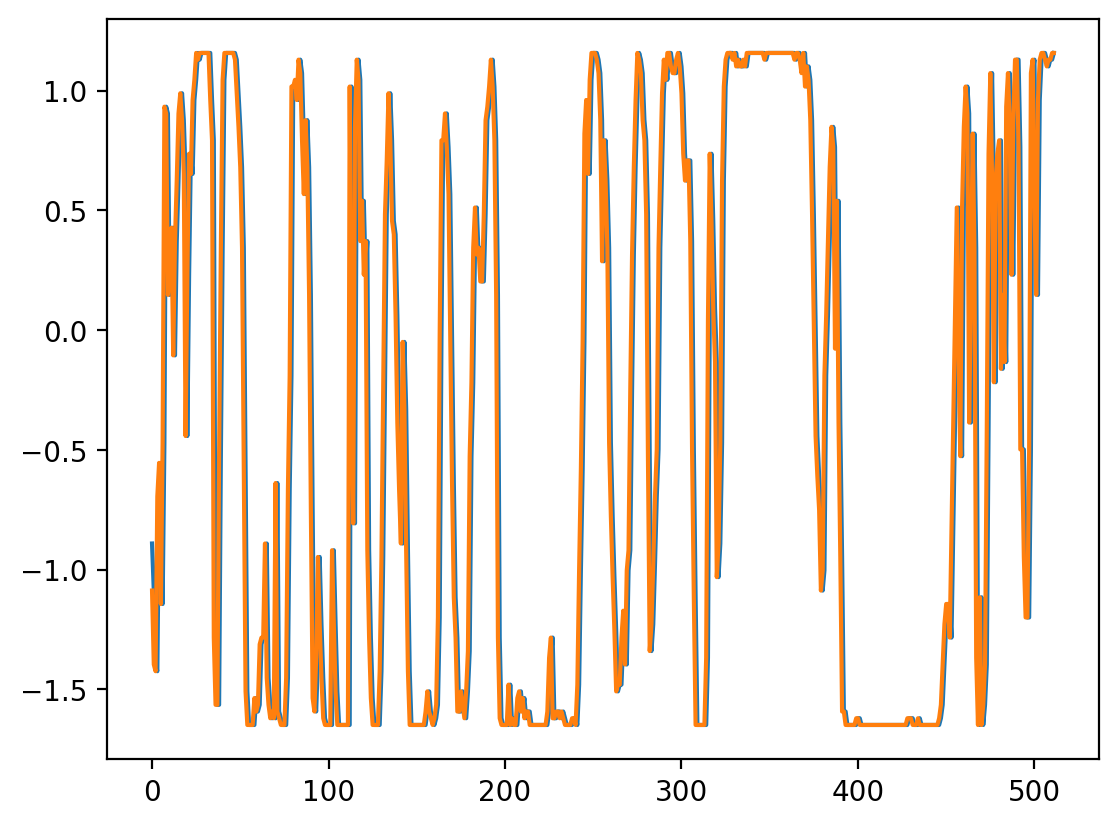

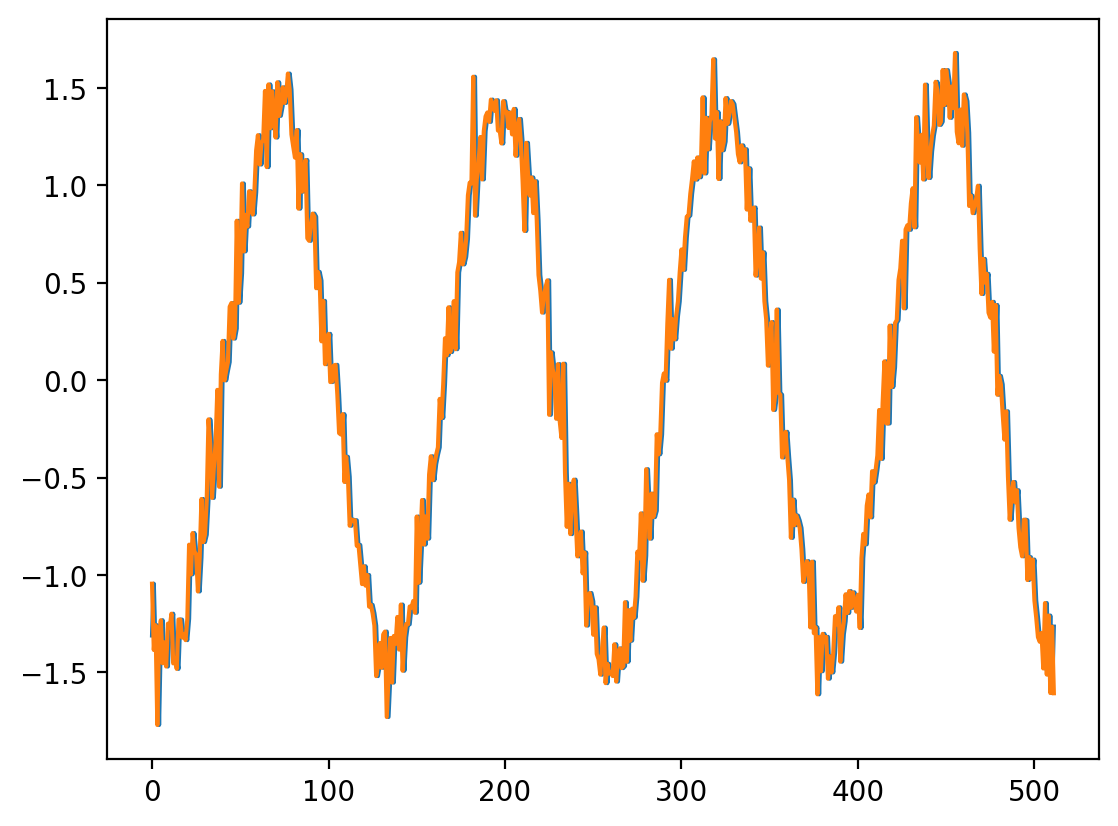

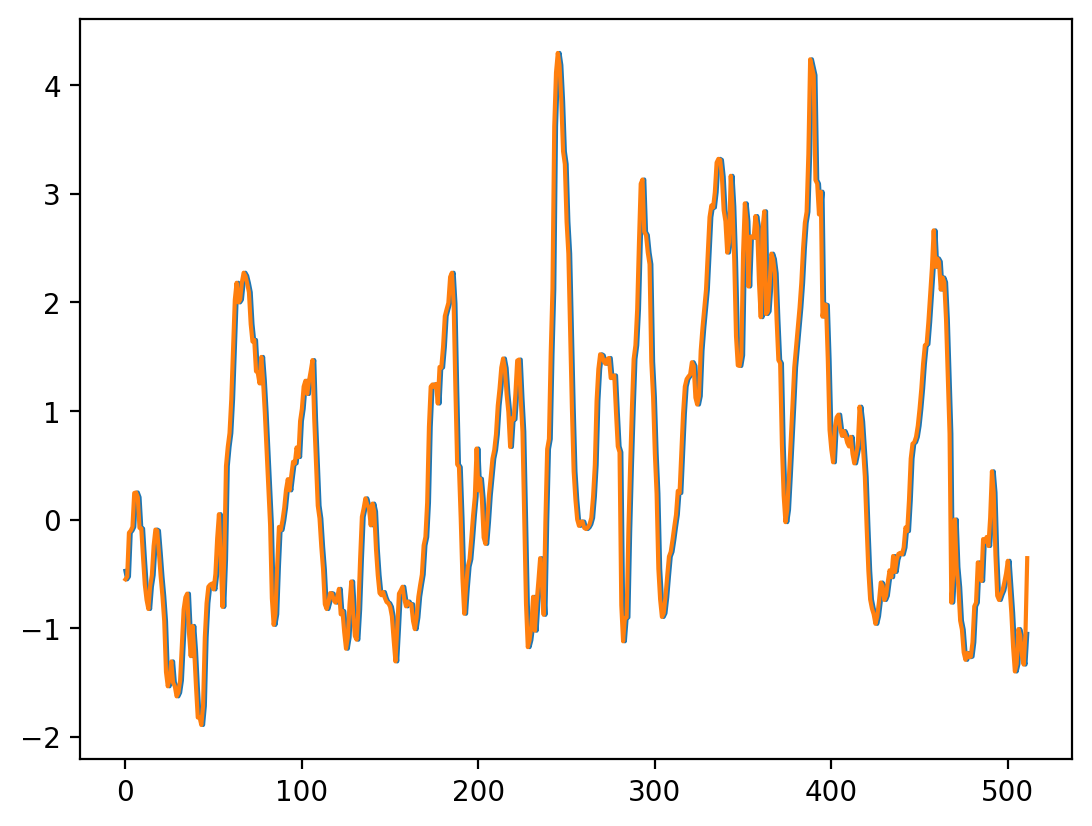

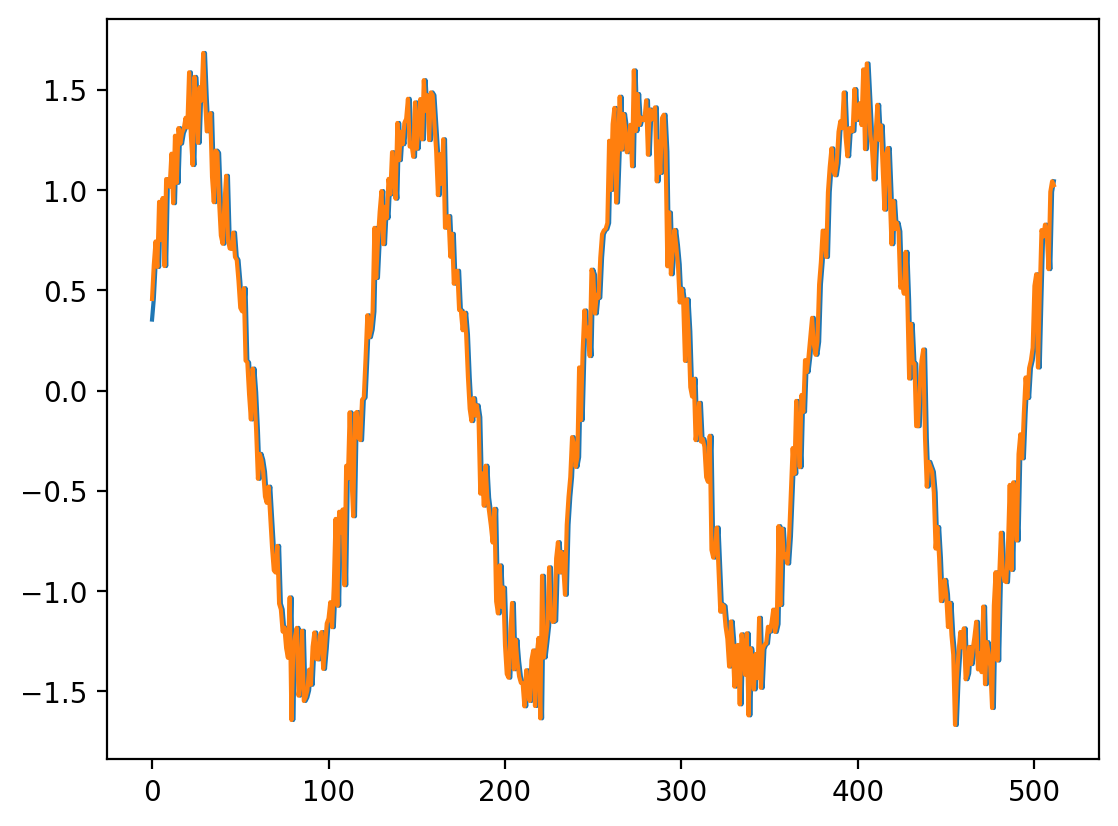

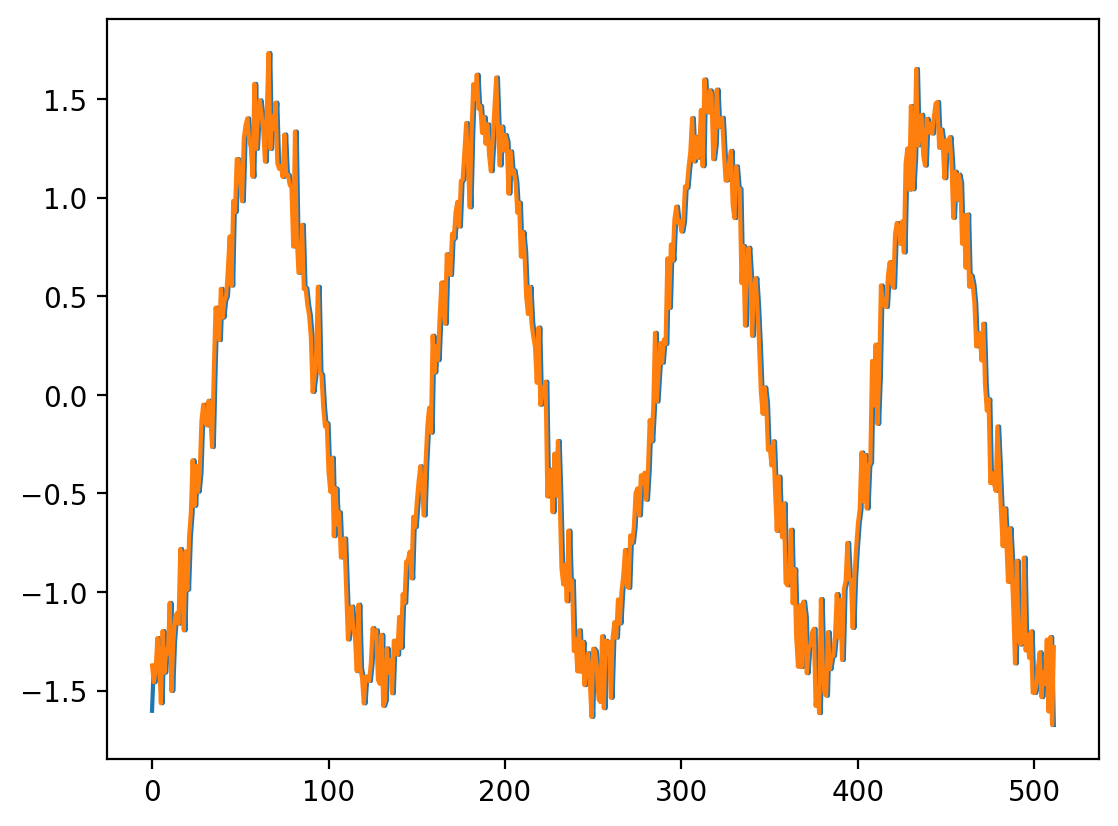

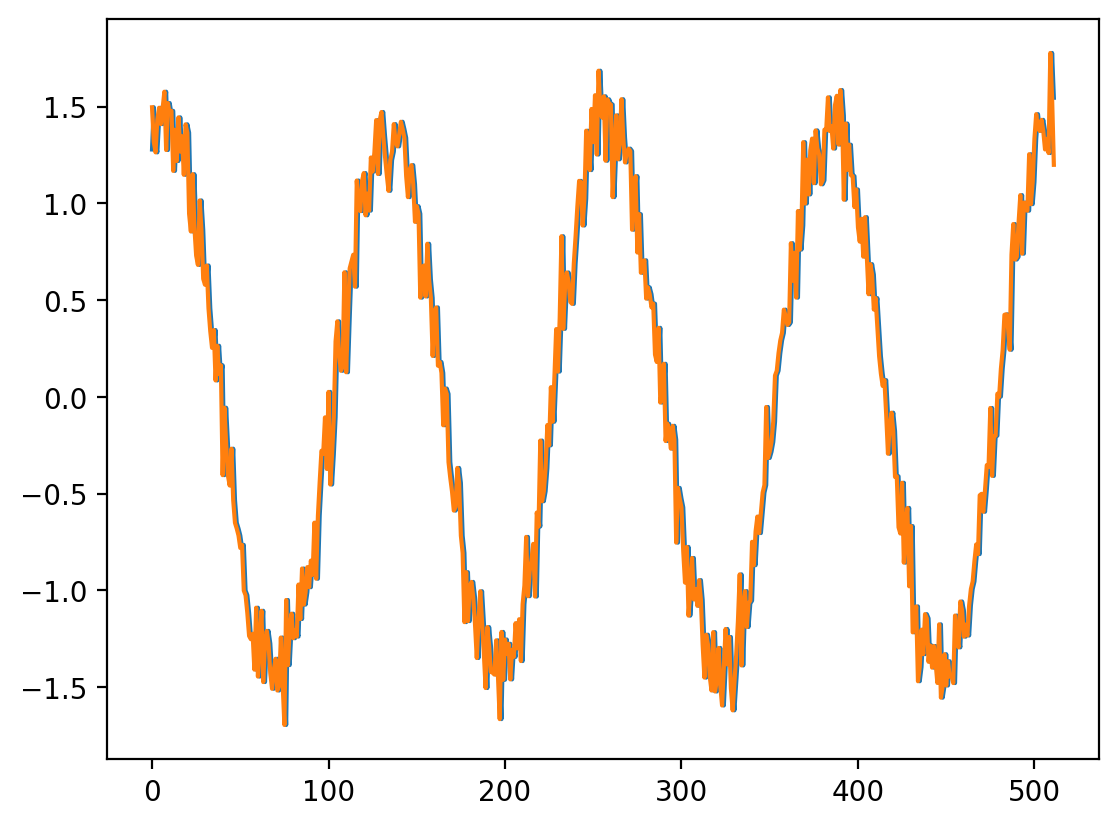

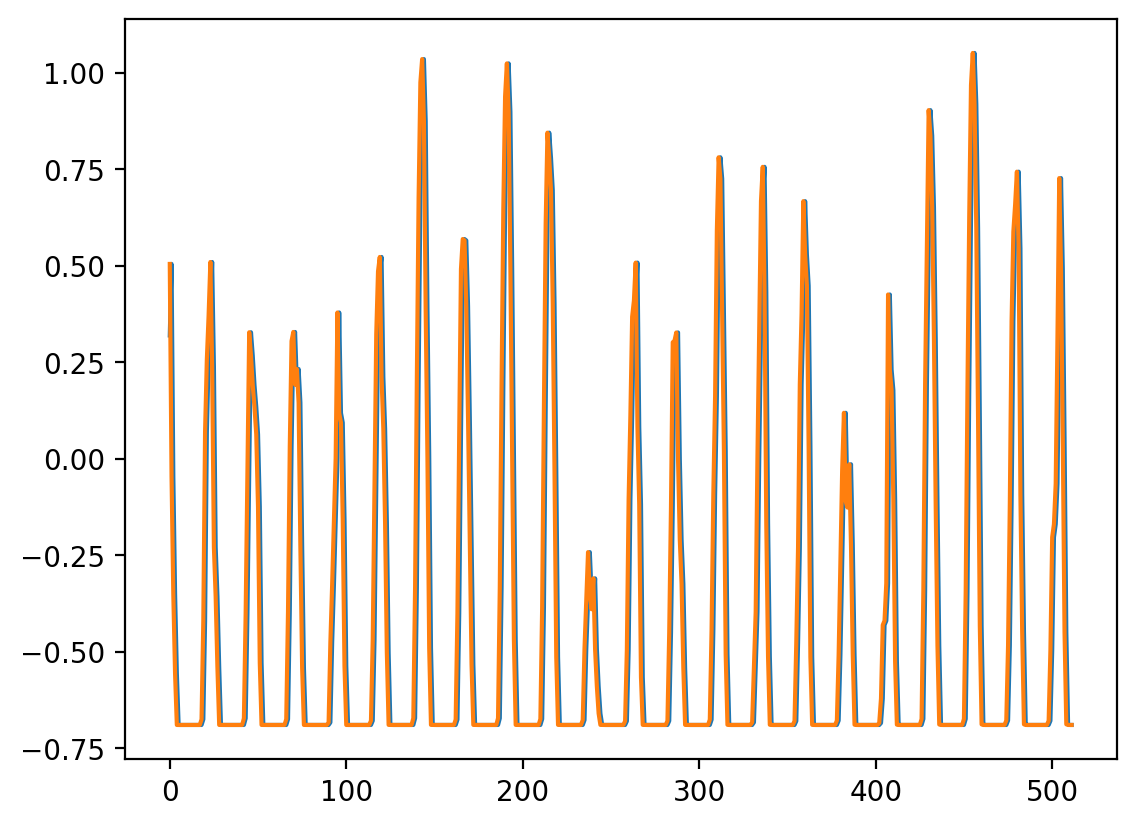

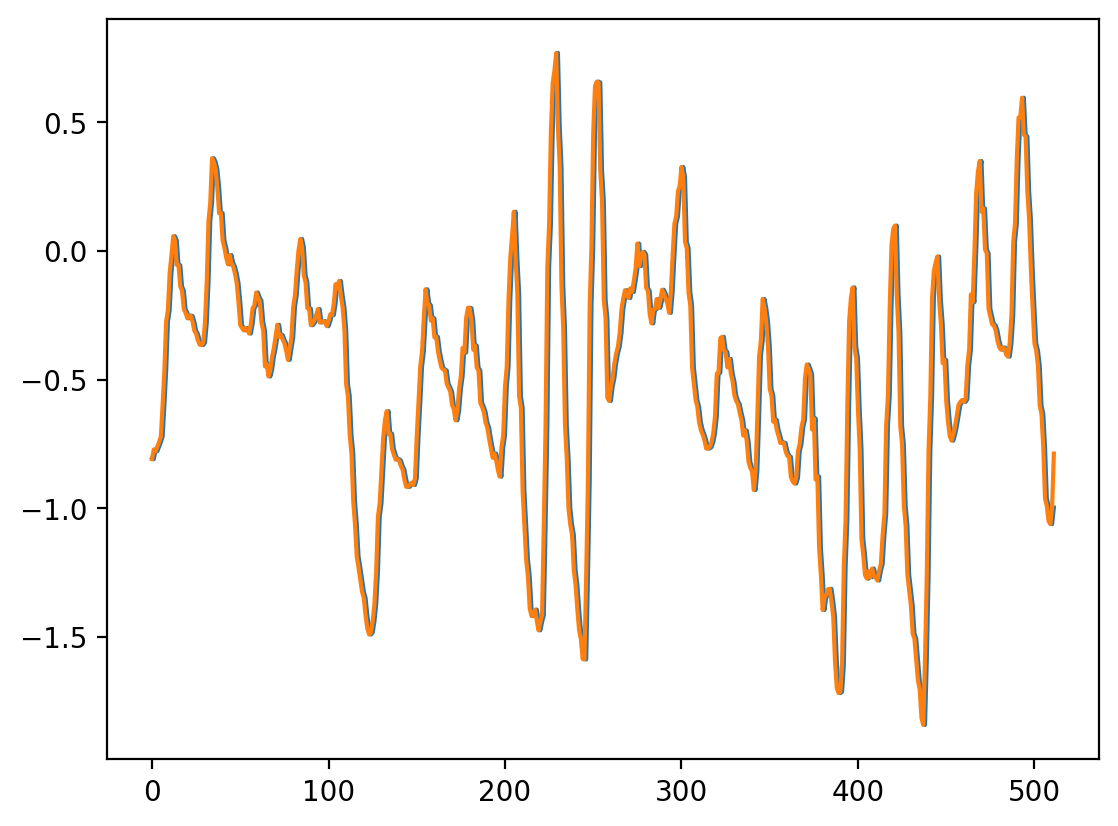

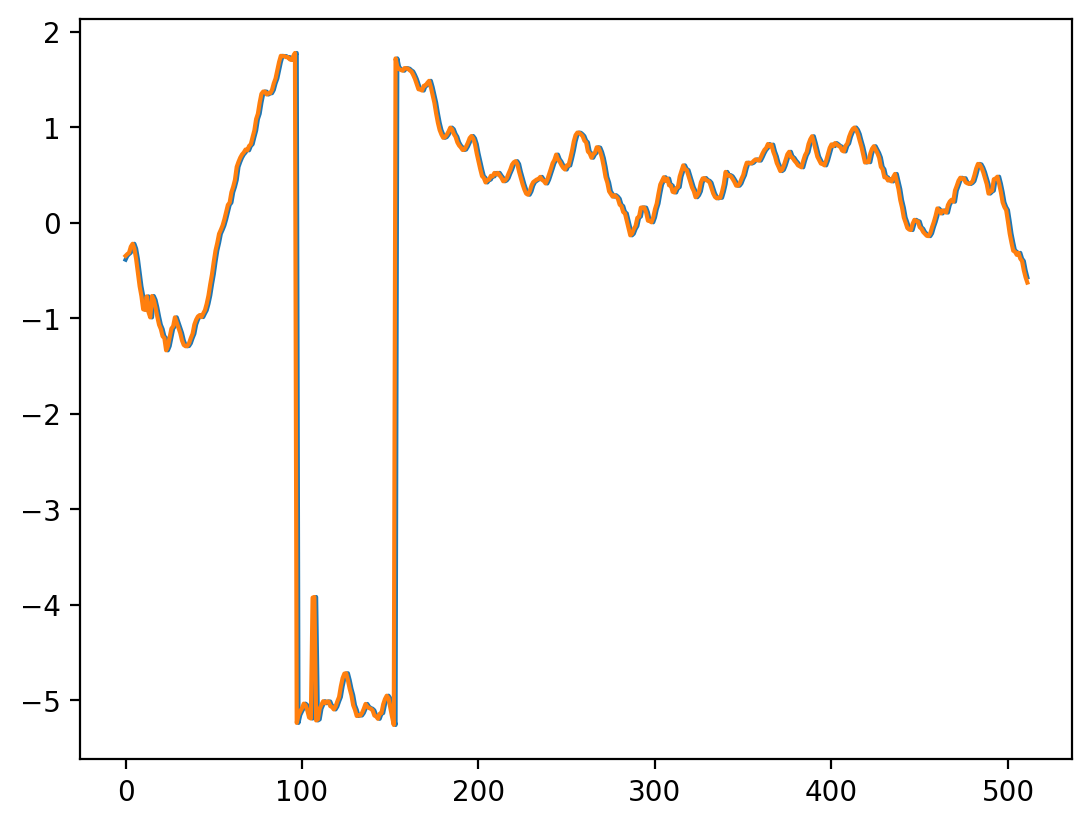

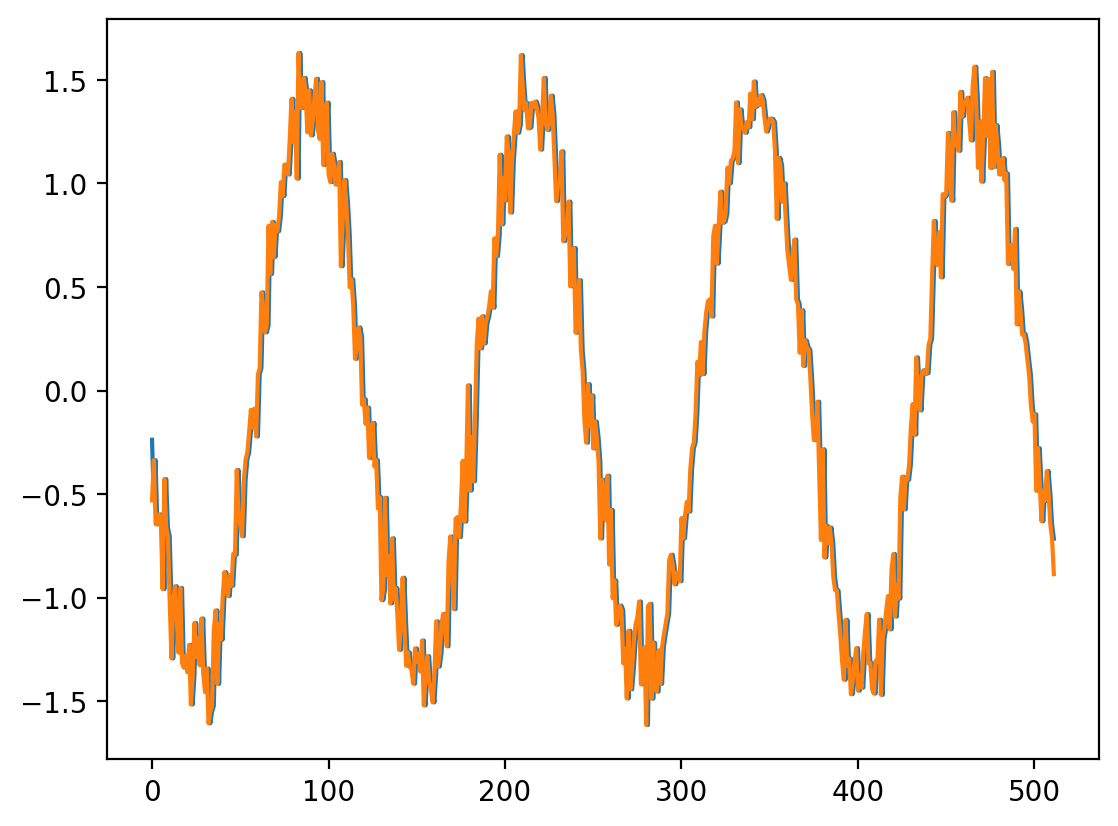

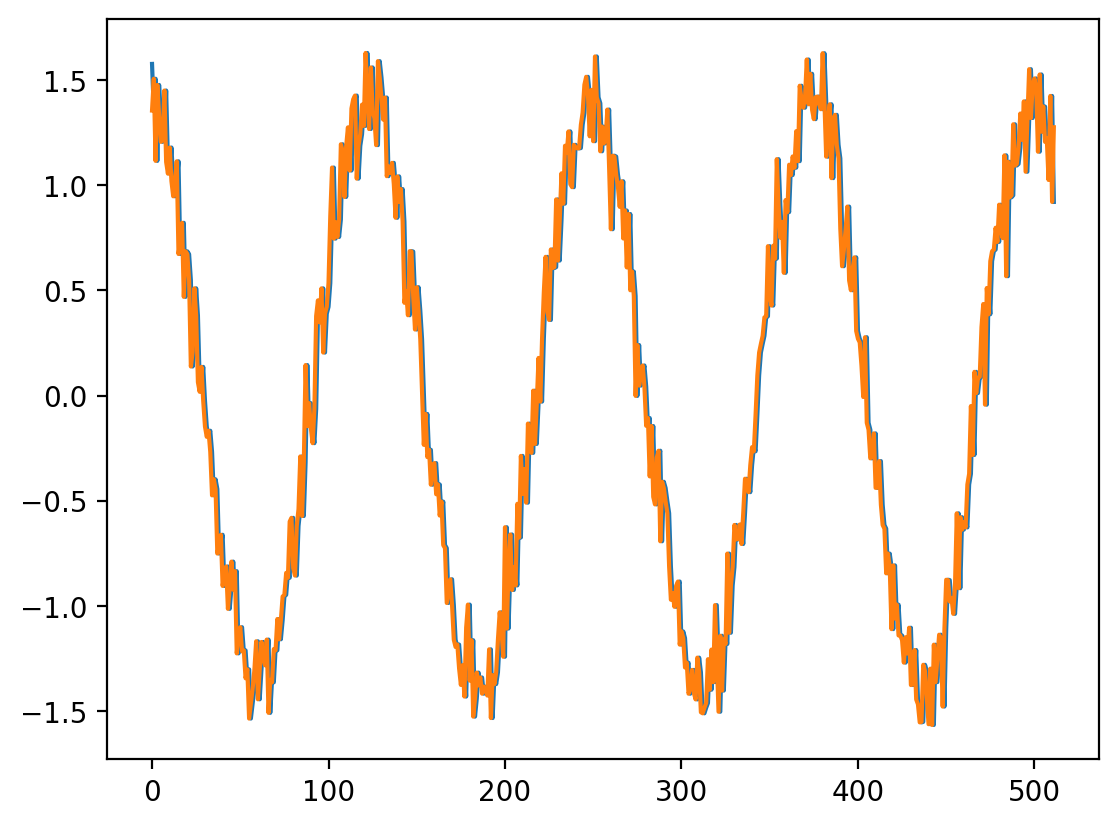

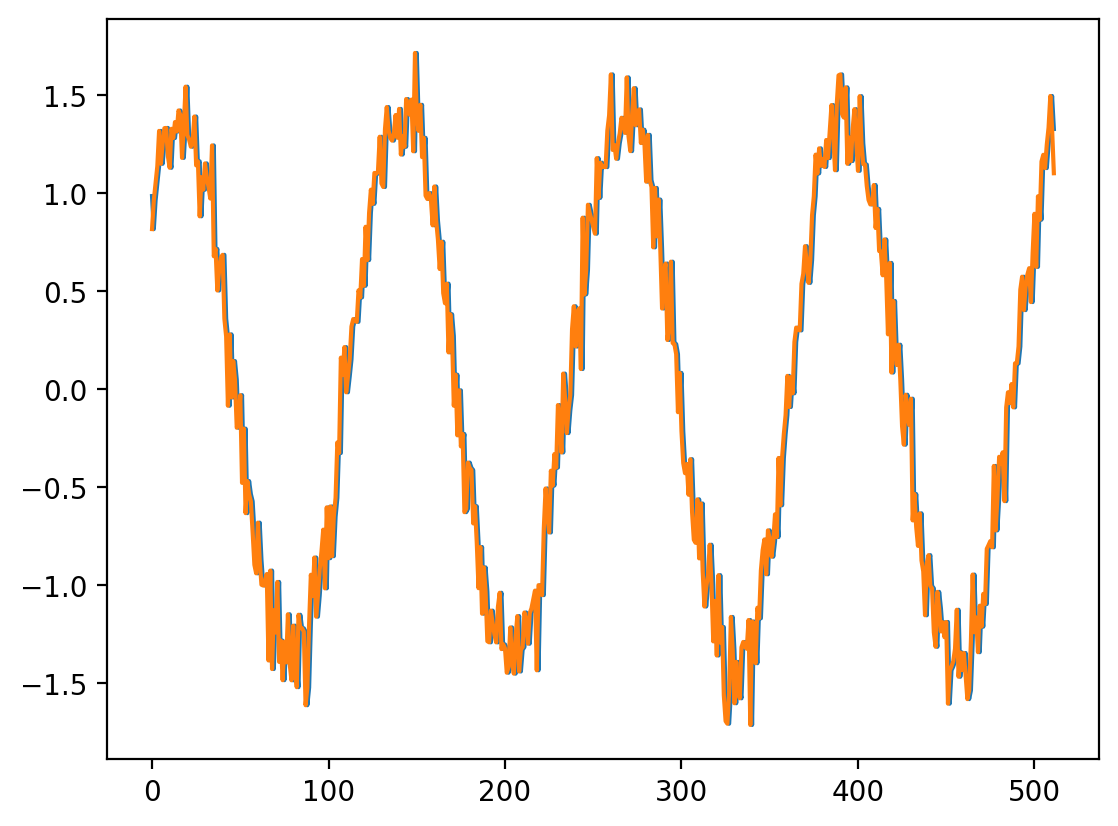

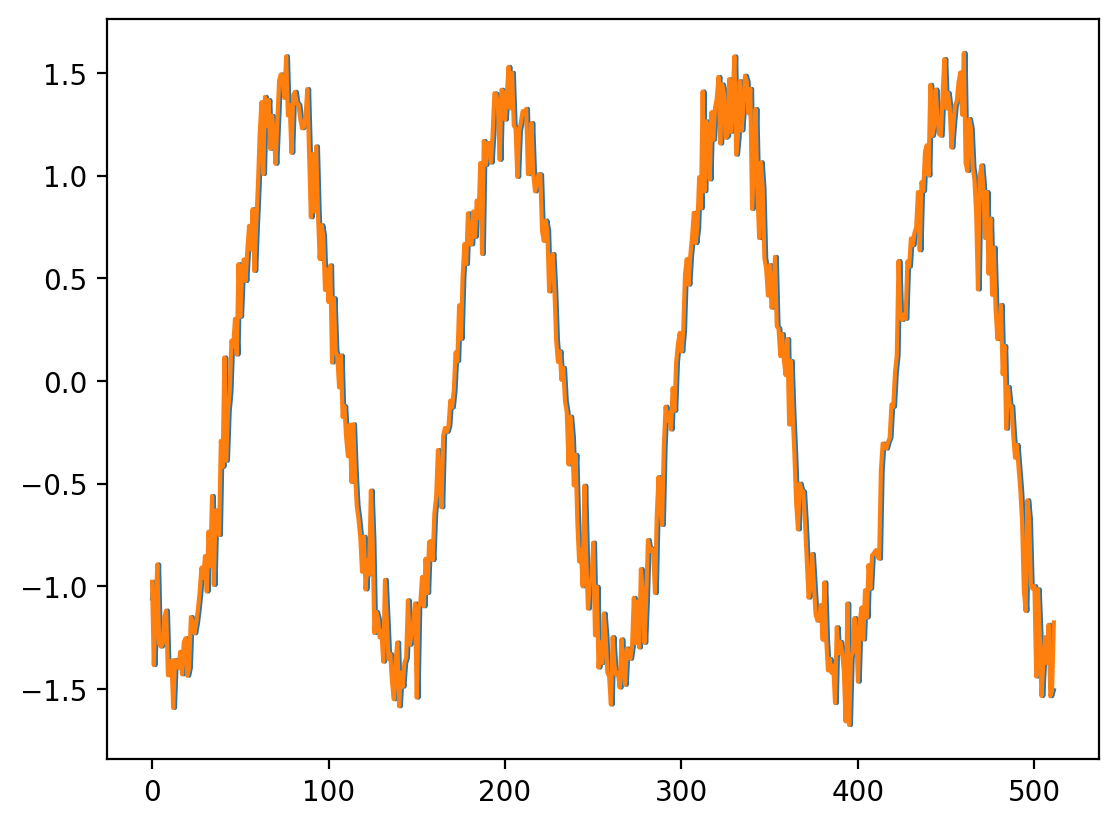

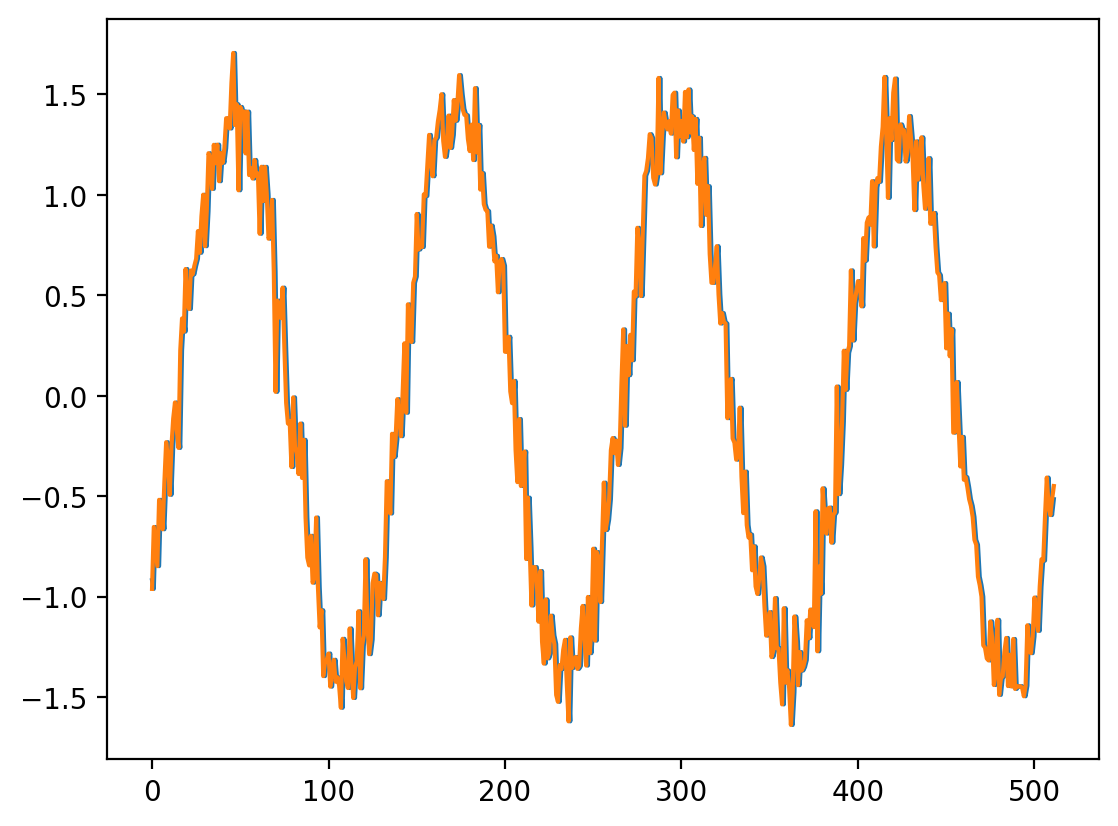

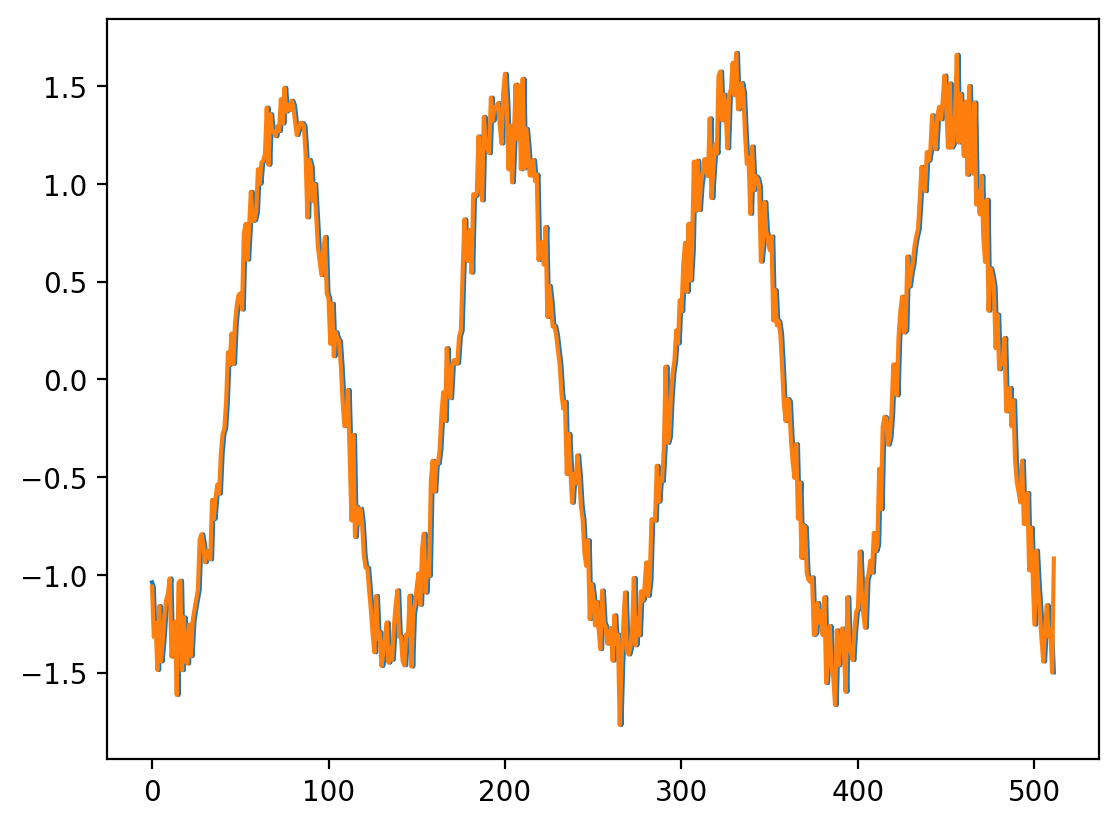

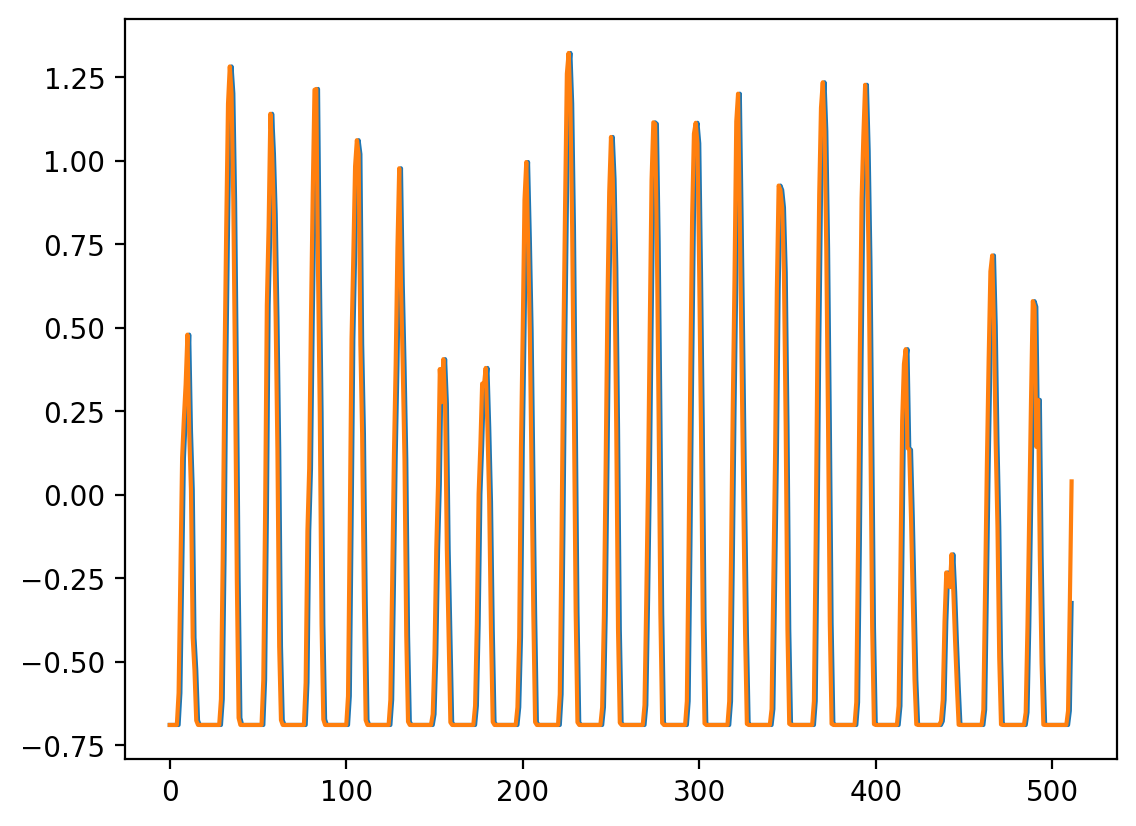

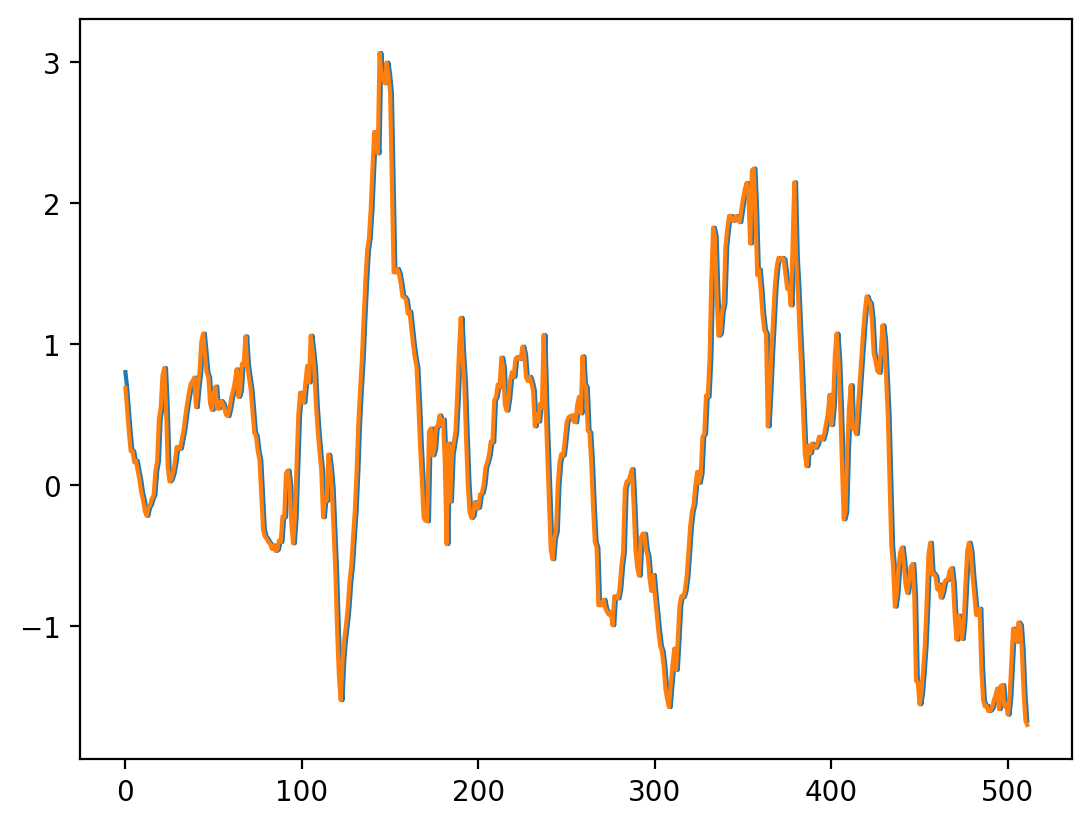

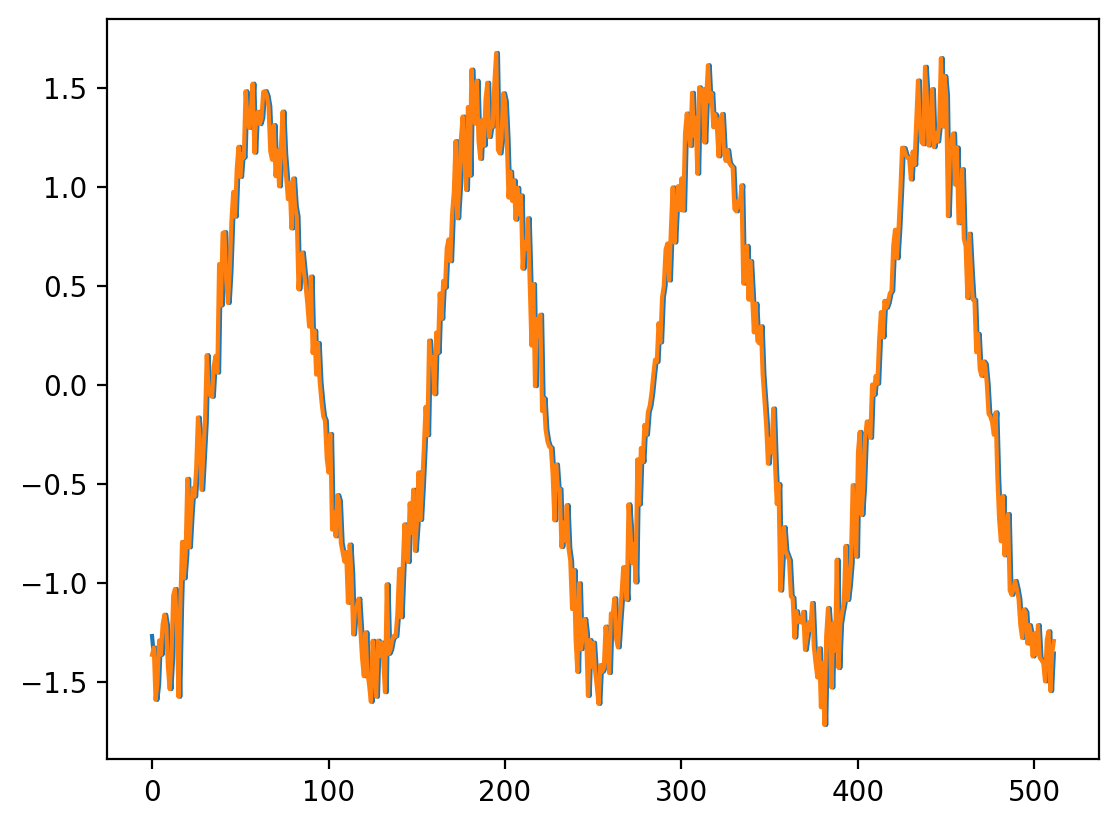

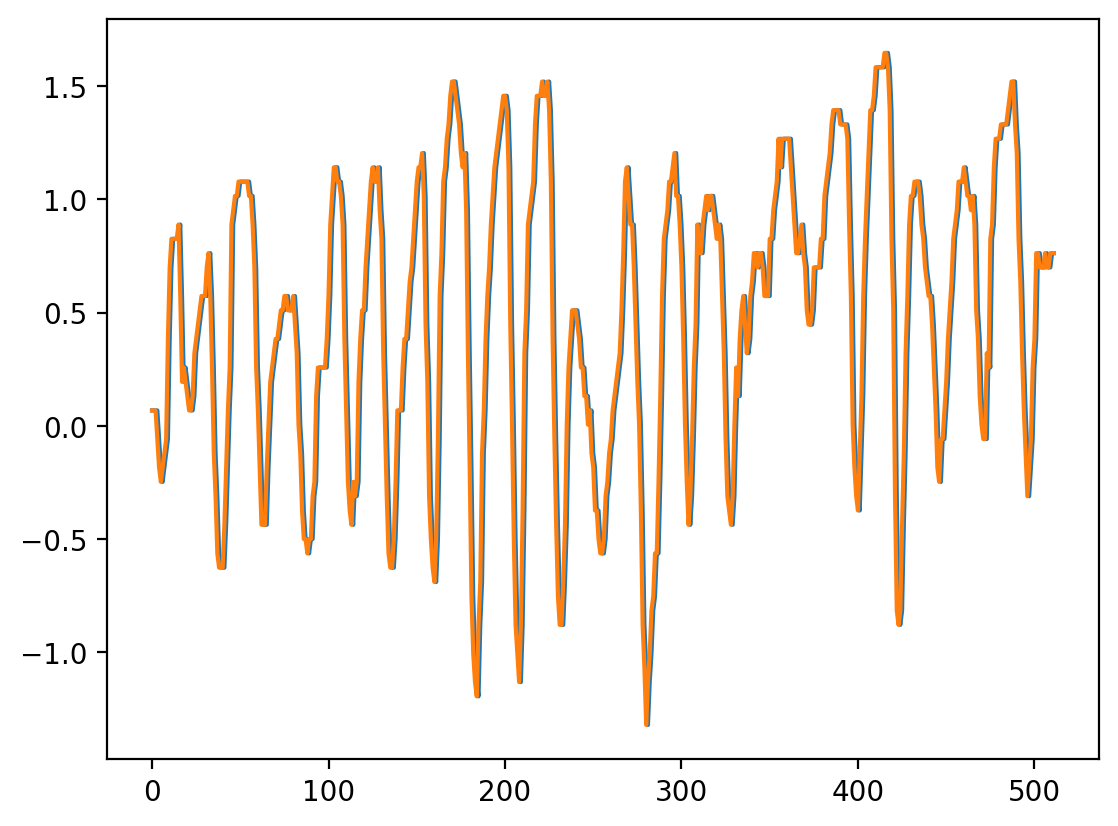

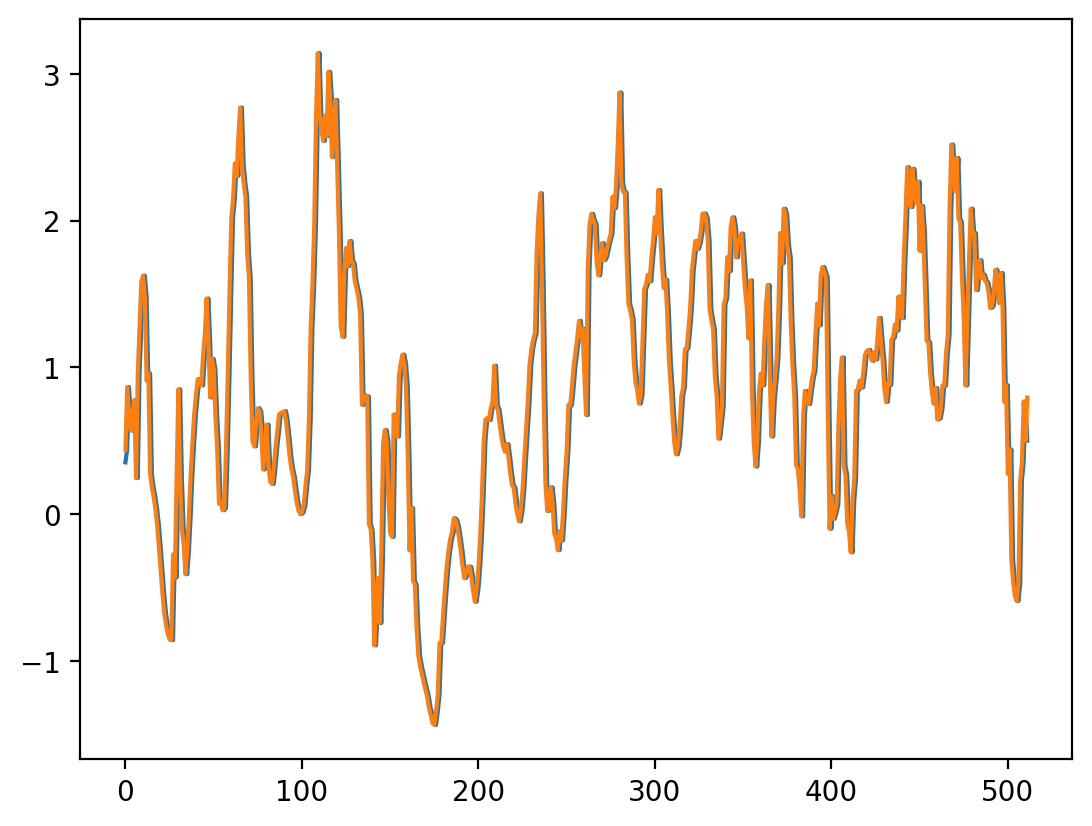

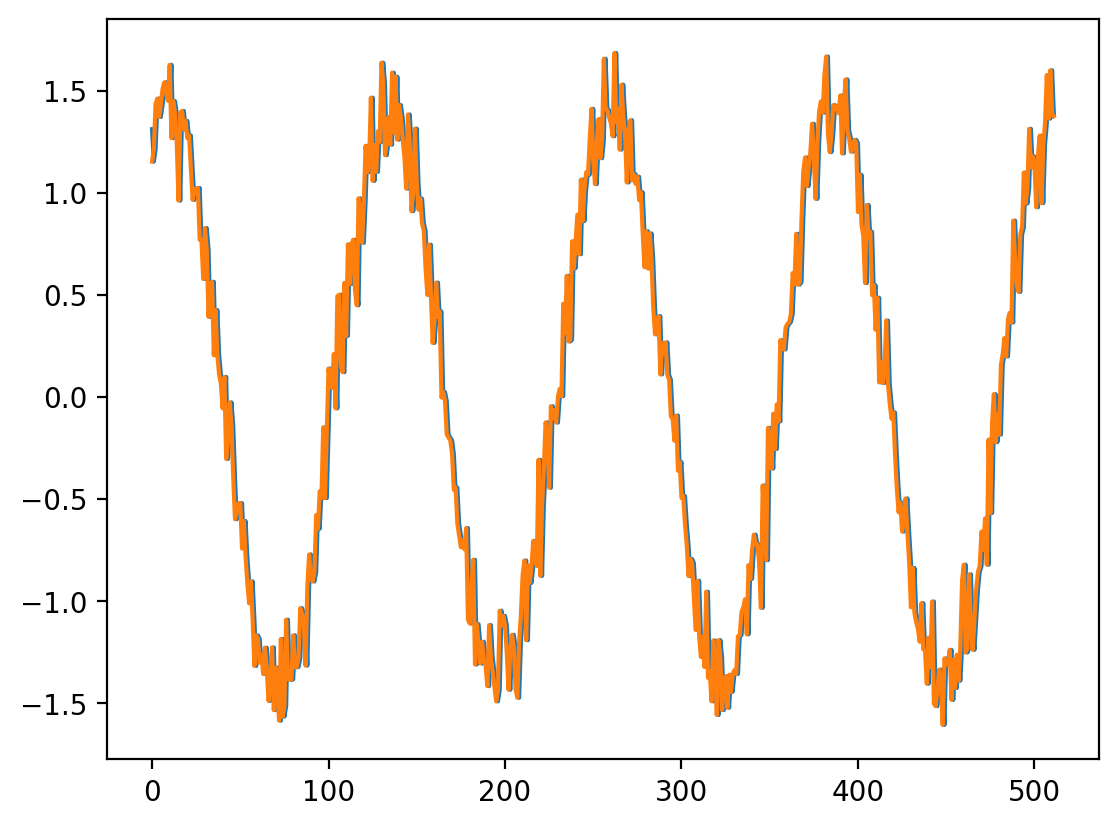

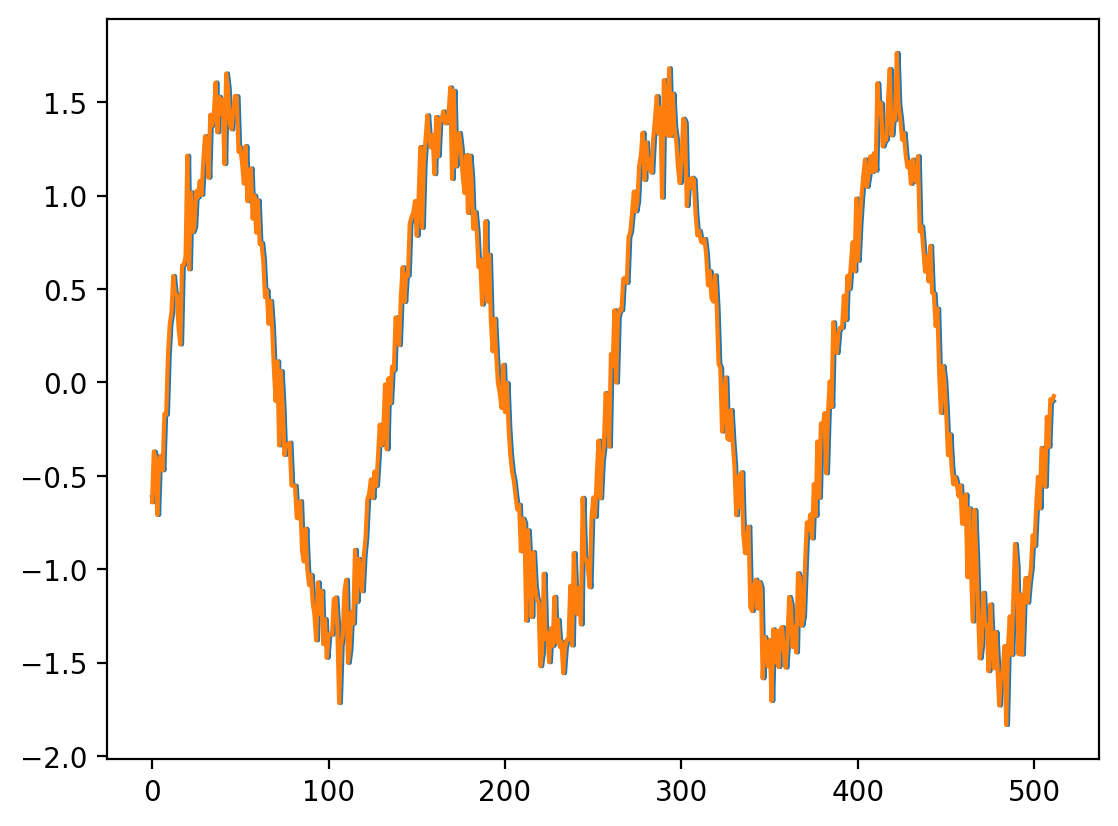

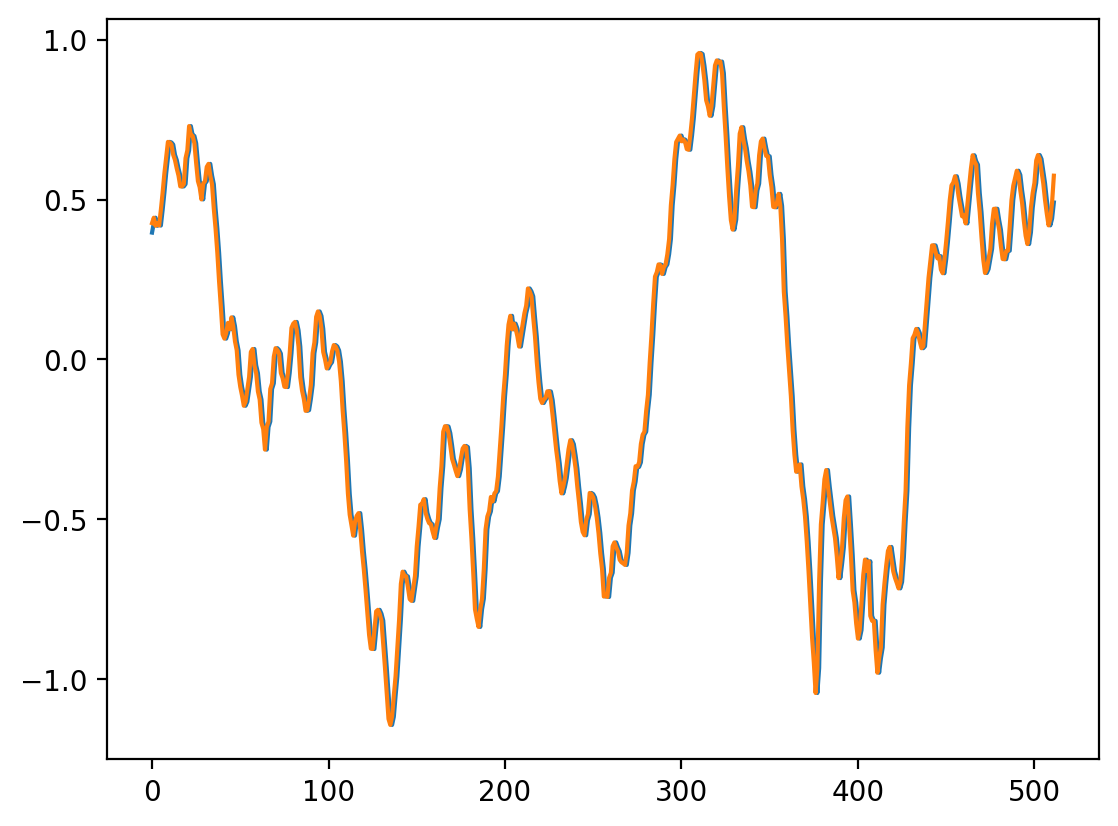

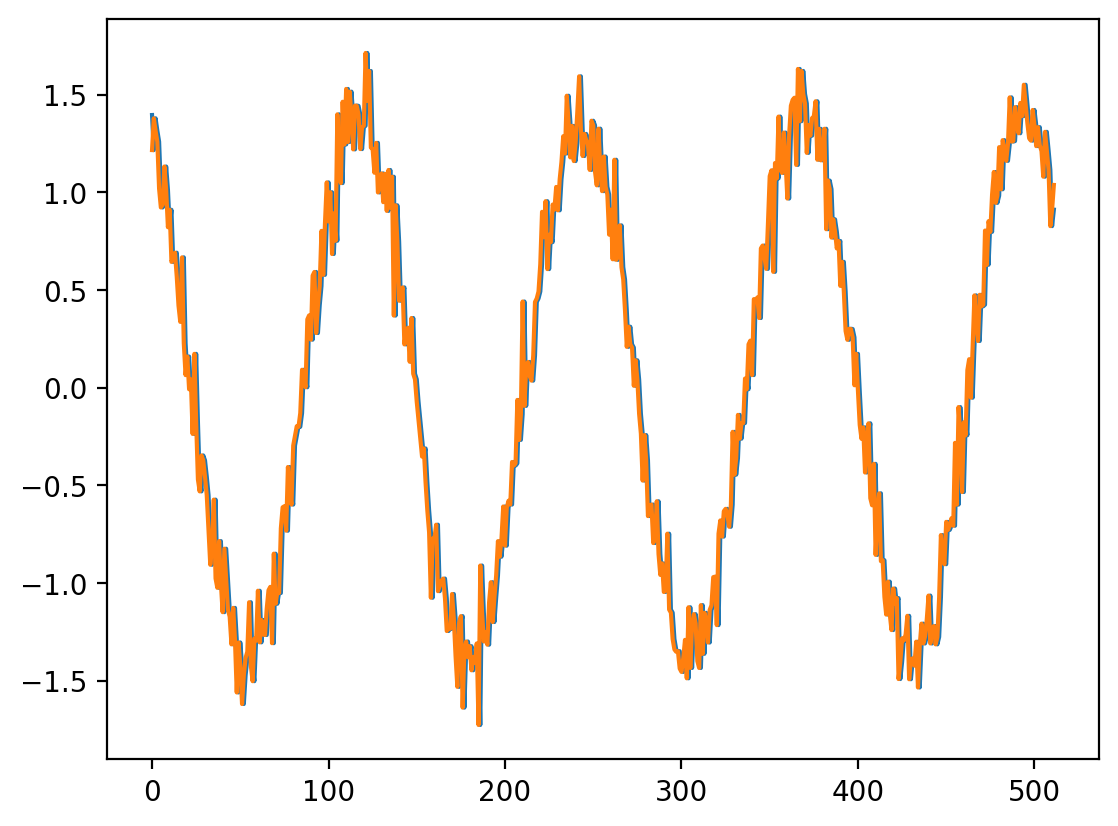

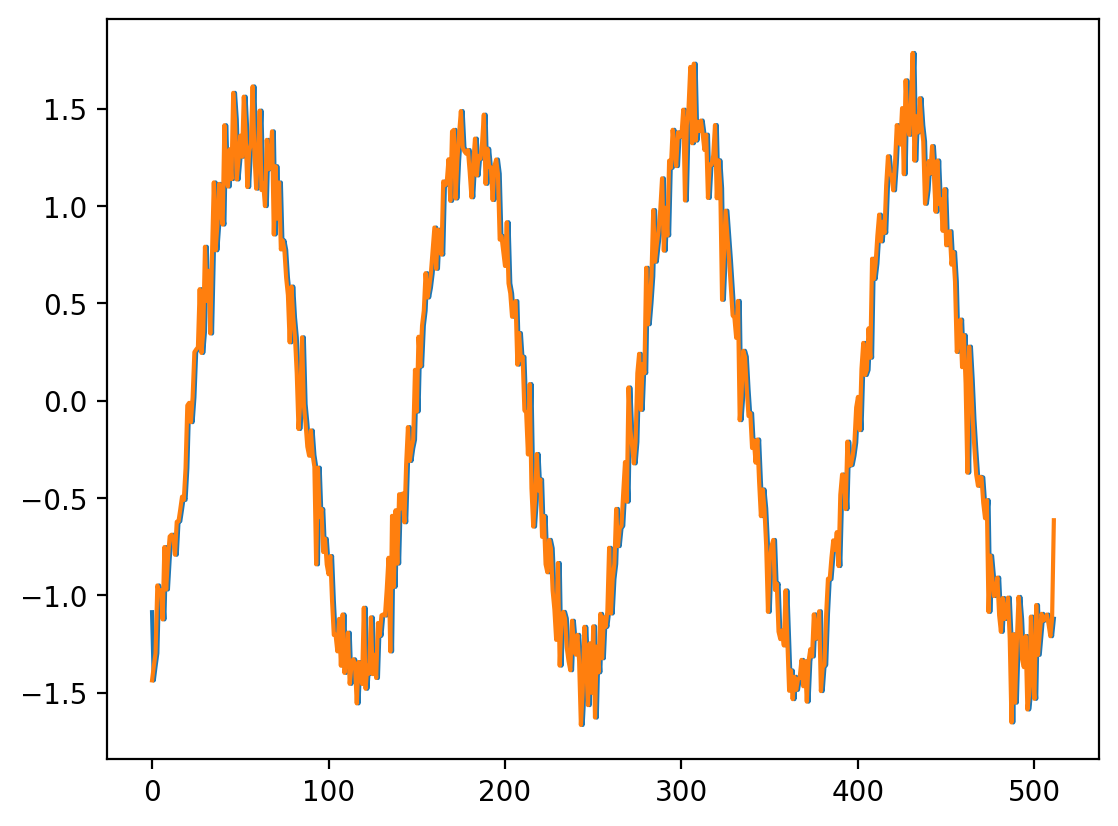

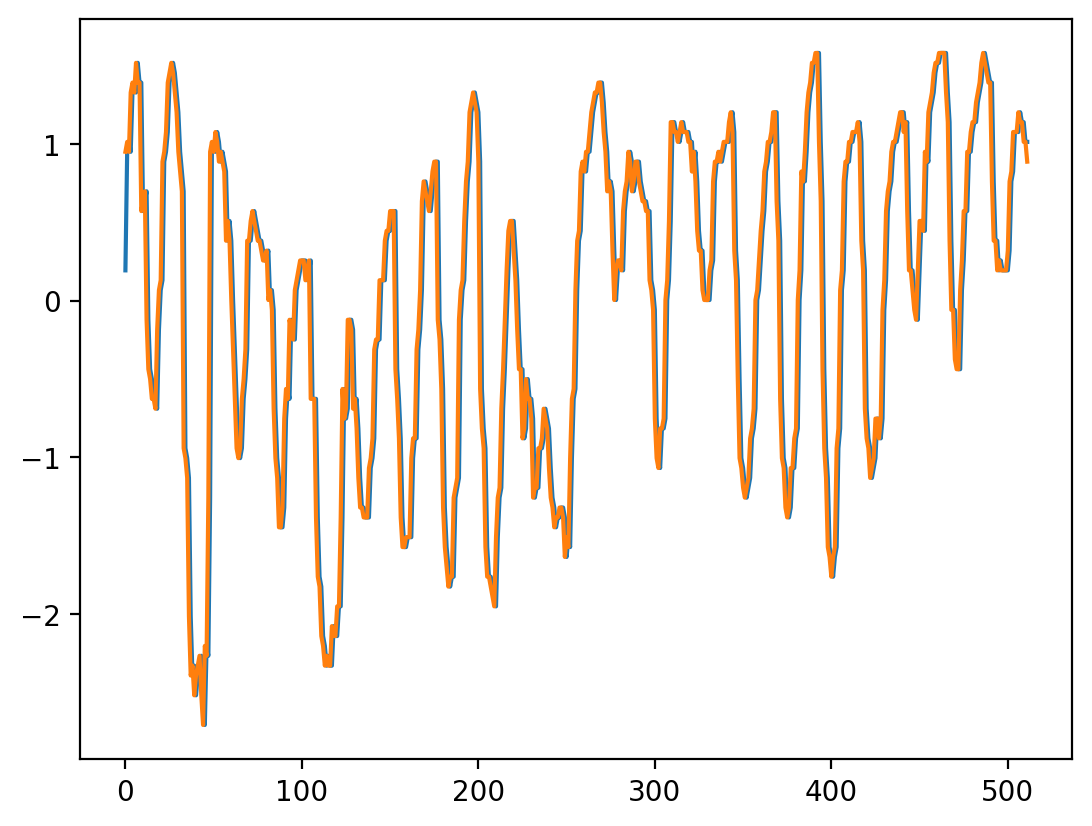

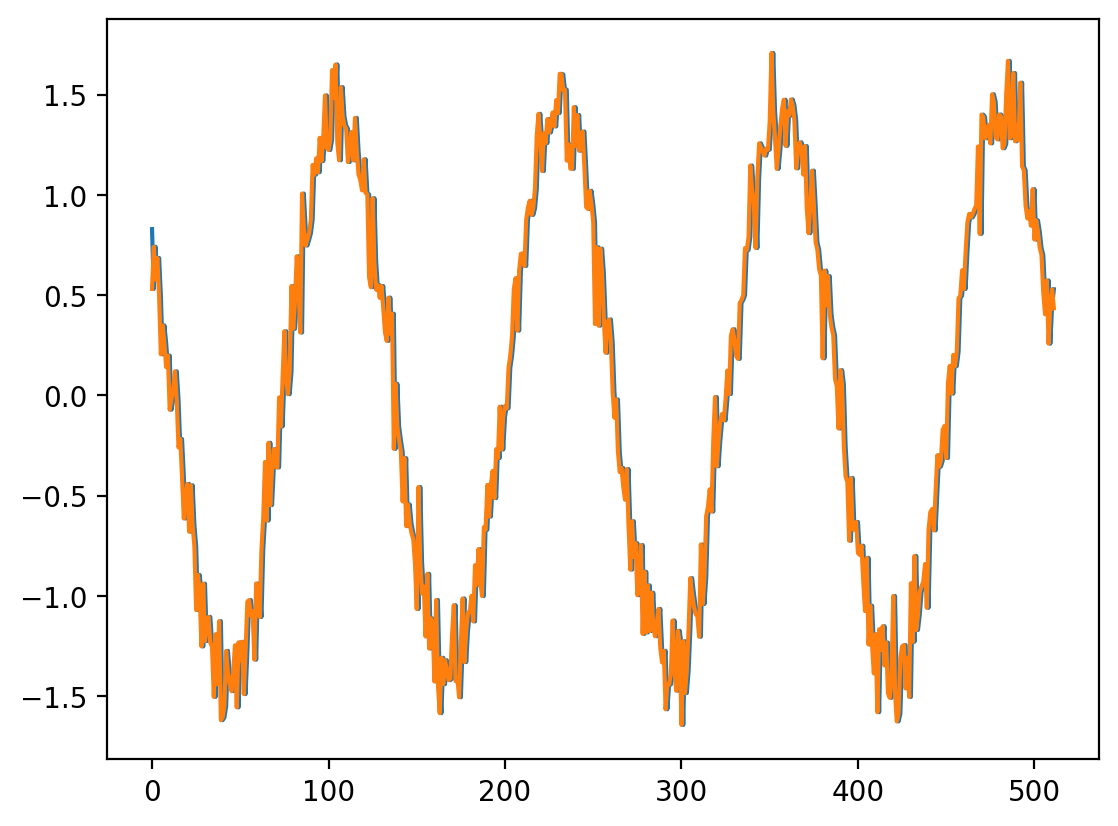

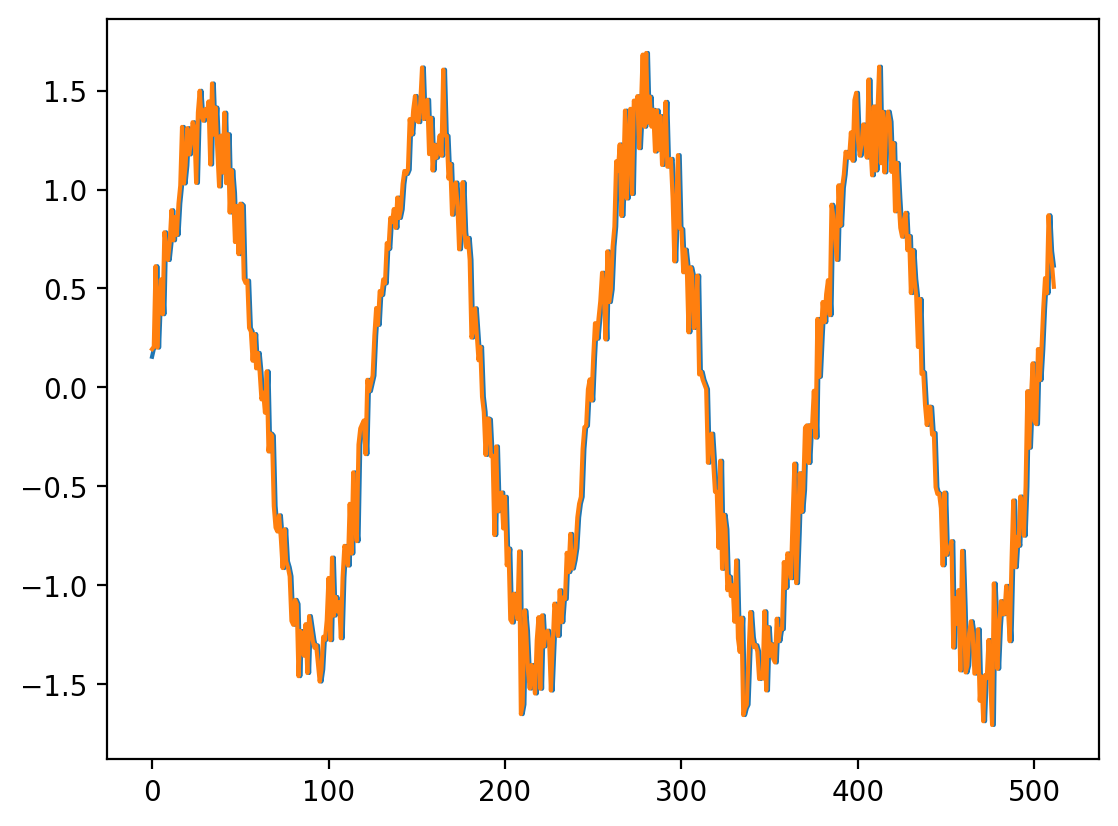

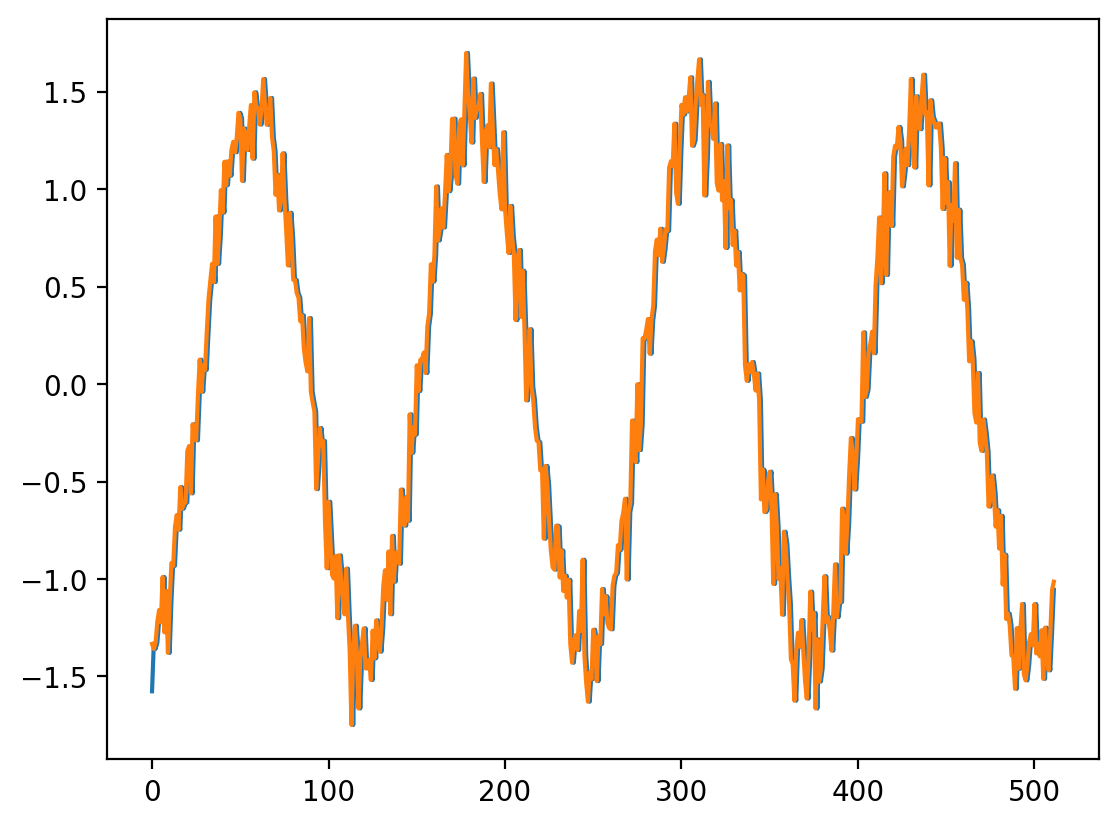

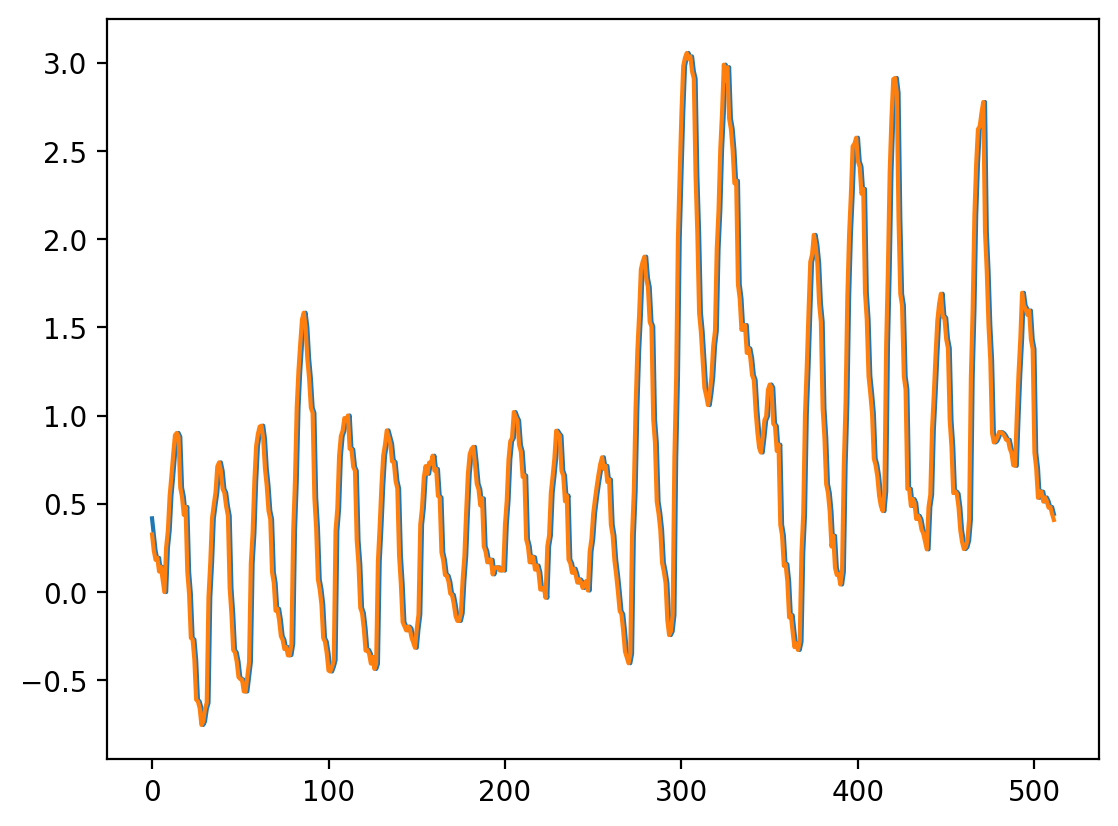

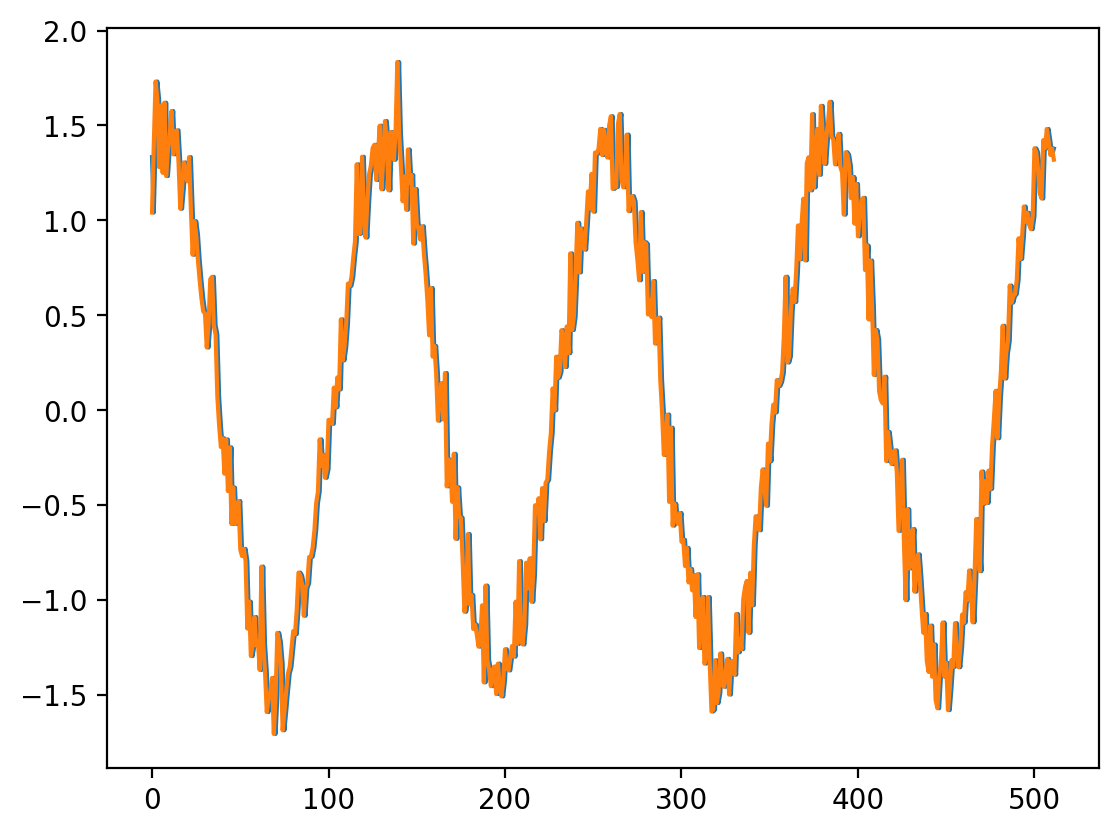

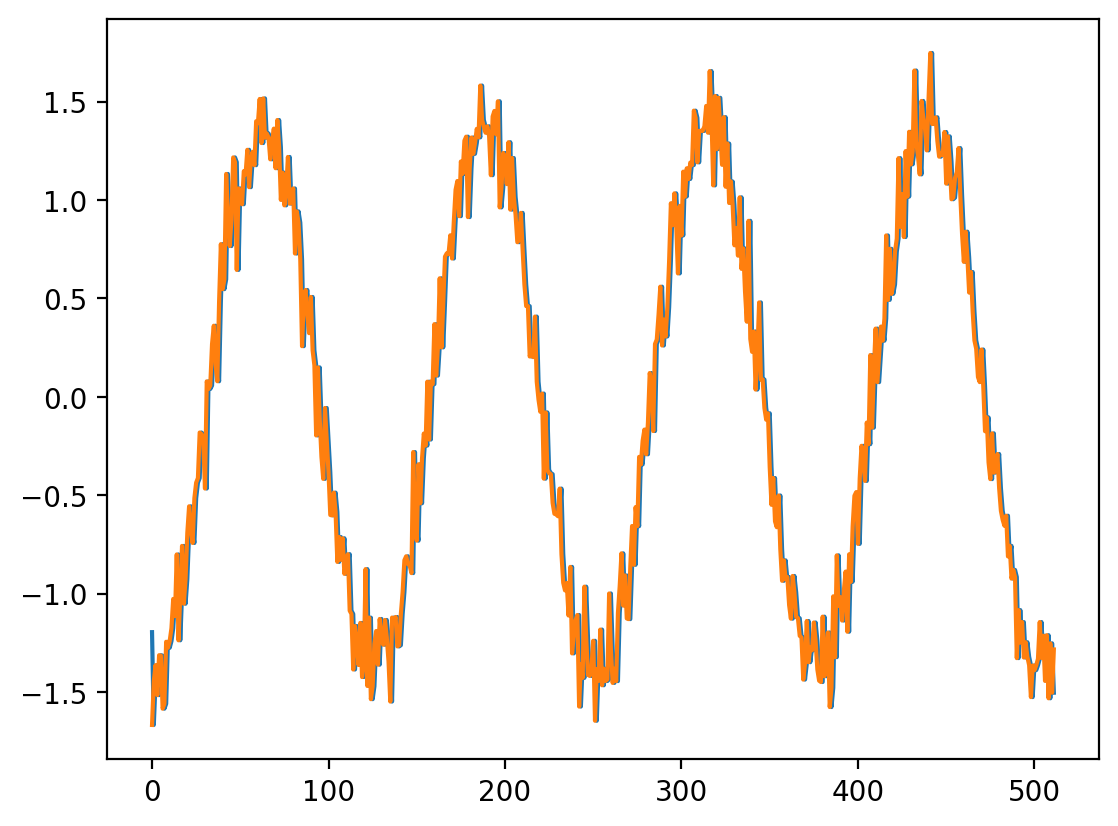

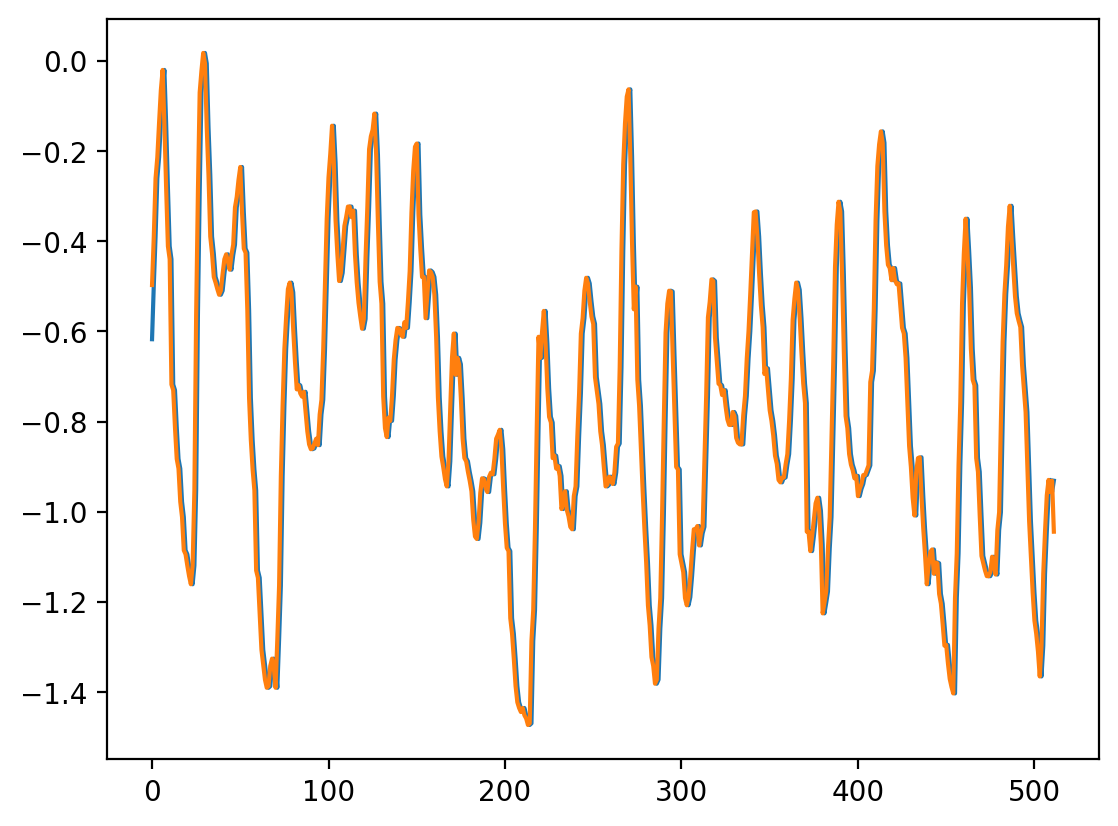

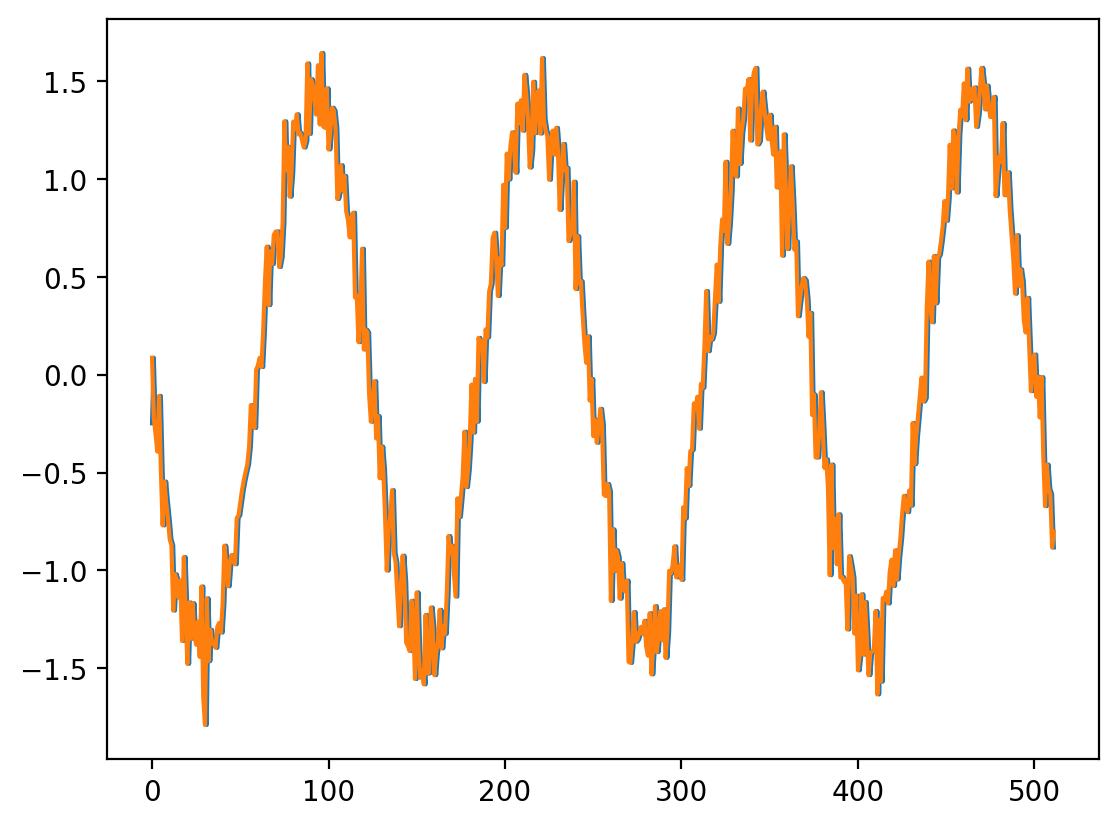

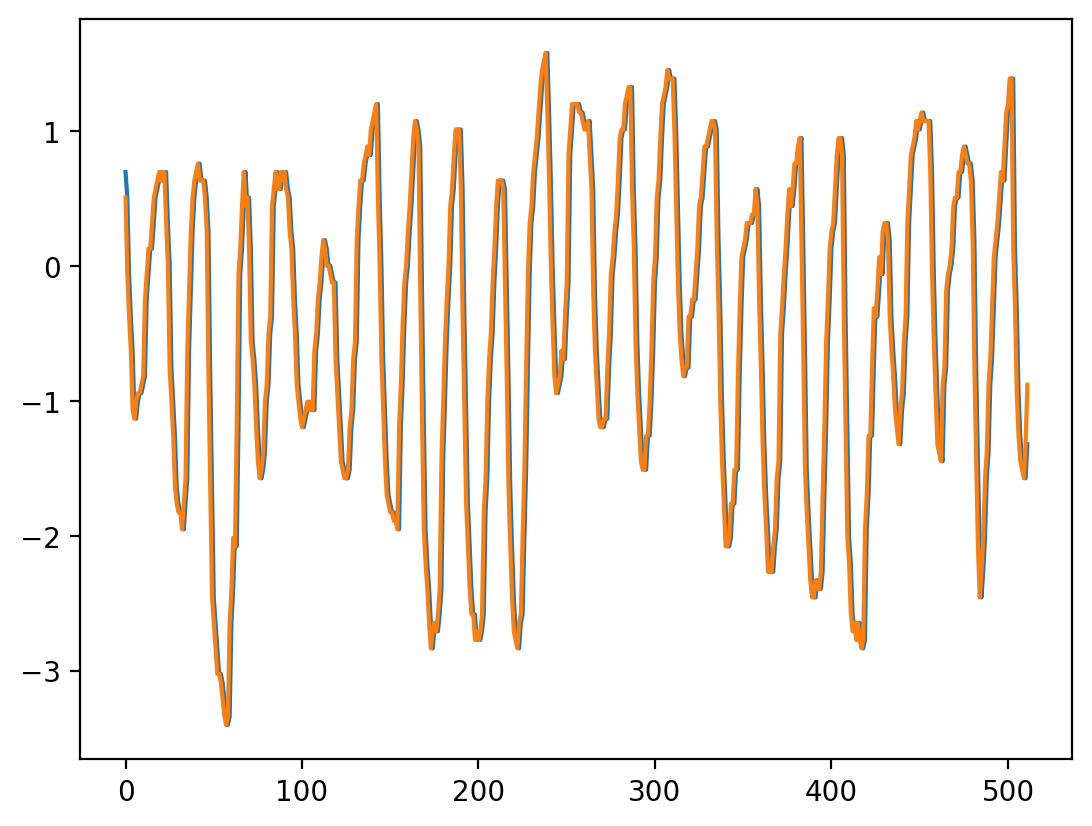

In [27]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, max_sequence_length):
        self.data = data
        self.max_sequence_length = max_sequence_length
        self.means = np.mean(data, axis=1)
        self.std = np.std(data, axis=1)
        self.data = (self.data - self.means[:, None]) / self.std[:, None]

    def __len__(self):
        return int(self.data.shape[0] * self.data.shape[1] / self.max_sequence_length)

    def __getitem__(self, idx):
        # Since now I have only 7 time series but they are each really long
        # I will just randomly select one of the time series and then randomly select a subsequence of length max_sequence_length
        new_idx = random.randint(0, len(self.data) - 1)
        series = self.data[new_idx]
        assert len(series) > self.max_sequence_length

        # Randomly select a starting point for the sequence
        start_index = random.randint(0, len(series) - self.max_sequence_length - 1)

        # Slice the series to get a random subsequence of length max_sequence_length
        train_series = series[start_index : start_index + self.max_sequence_length]
        true_series = series[
            start_index + 1 : start_index + self.max_sequence_length + 1
        ]

        return torch.tensor(train_series, dtype=torch.float32).unsqueeze(
            -1
        ), torch.tensor(true_series, dtype=torch.float32)


max_seq_length = 512
batch_size = 64

dataset = TimeSeriesDataset(training_data, max_seq_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for batch in dataloader:
    plt.plot(batch[0][0])
    plt.plot(batch[1][0])
    plt.show()

## Now lets train the transformer!

In [28]:
import importlib

importlib.reload(Transformer)

output_dim = 2  # To begin with we can use a Gaussian with mean and variance
d_model = 32
num_heads = 1
num_layers = 2
d_ff = 128
dropout = 0.0

transformer = Transformer.Decoder_Transformer(
    output_dim,
    d_model,
    num_heads,
    num_layers,
    d_ff,
    max_seq_length,
    dropout,
    device=device,
).to(device)

Loss: -2.4181: 100%|██████████| 49/49 [00:01<00:00, 26.46it/s]


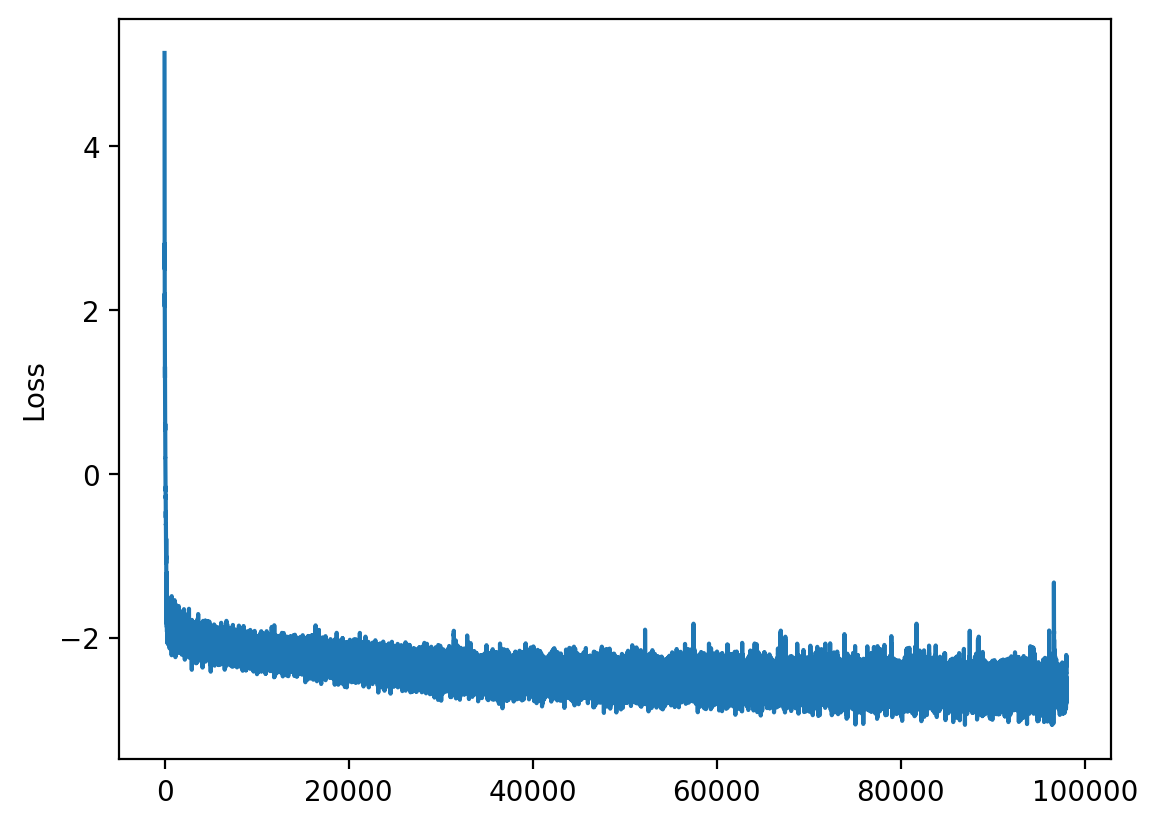

In [29]:
optimizer = optim.Adam(transformer.parameters(), lr=0.0001)


def Gaussian_loss(
    transformer_pred, y_true, epsilon=torch.tensor(1e-6, dtype=torch.float32).to(device)
):
    # Splitting the output into mean and variance
    mean = transformer_pred[:, :, 0]
    var = torch.nn.functional.softplus(transformer_pred[:, :, 1]) + epsilon

    # Calculating the Gaussian negative log-likelihood loss
    loss = torch.mean((y_true - mean) ** 2 / var + torch.log(var))

    return loss


transformer.train()
losses = []


dataloader
epochs = 2000

for epoch in range(epochs):
    tqdm_object = tqdm(dataloader)

    for num, data_batch in enumerate(tqdm_object):
        batched_data = data_batch[0].to(device)
        batched_data_true = data_batch[1].to(device)

        optimizer.zero_grad()
        output = transformer(batched_data)
        loss = Gaussian_loss(output, batched_data_true)
        losses.append(loss.item())

        tqdm_object.set_description(f"Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()

transformer.eval()
plt.plot(losses)
plt.ylabel("Loss")
plt.show()

In [30]:
def PIT(transformer_pred, y_true):
    mean = transformer_pred[:, :, 0].cpu().detach().numpy()
    var = torch.nn.functional.softplus(transformer_pred[:, :, 1])
    std = np.sqrt(var.cpu().detach().numpy())

    U = norm.cdf(
        y_true.cpu().detach().numpy(),
        loc=mean,
        scale=std,
    )
    return U

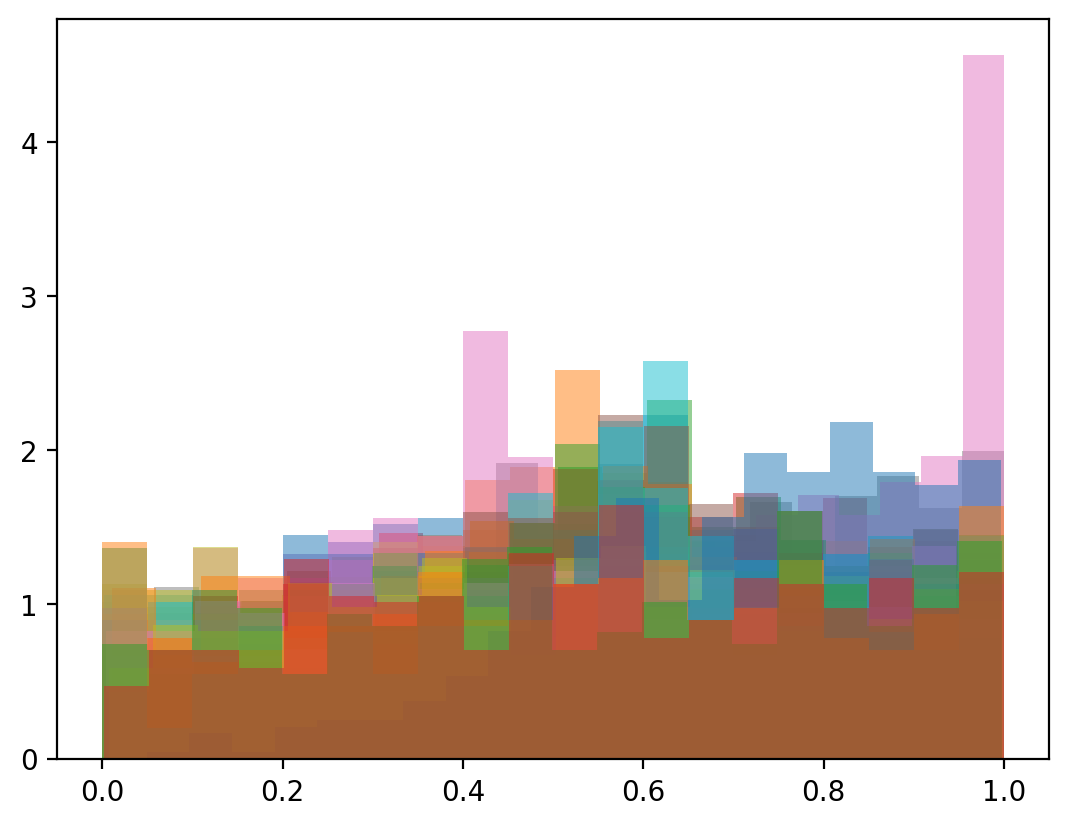

In [31]:
u = PIT(output, batched_data_true)

for i in range(u.shape[0]):
    plt.hist(u[i], alpha=0.5, bins=20, density=True)

plt.show()

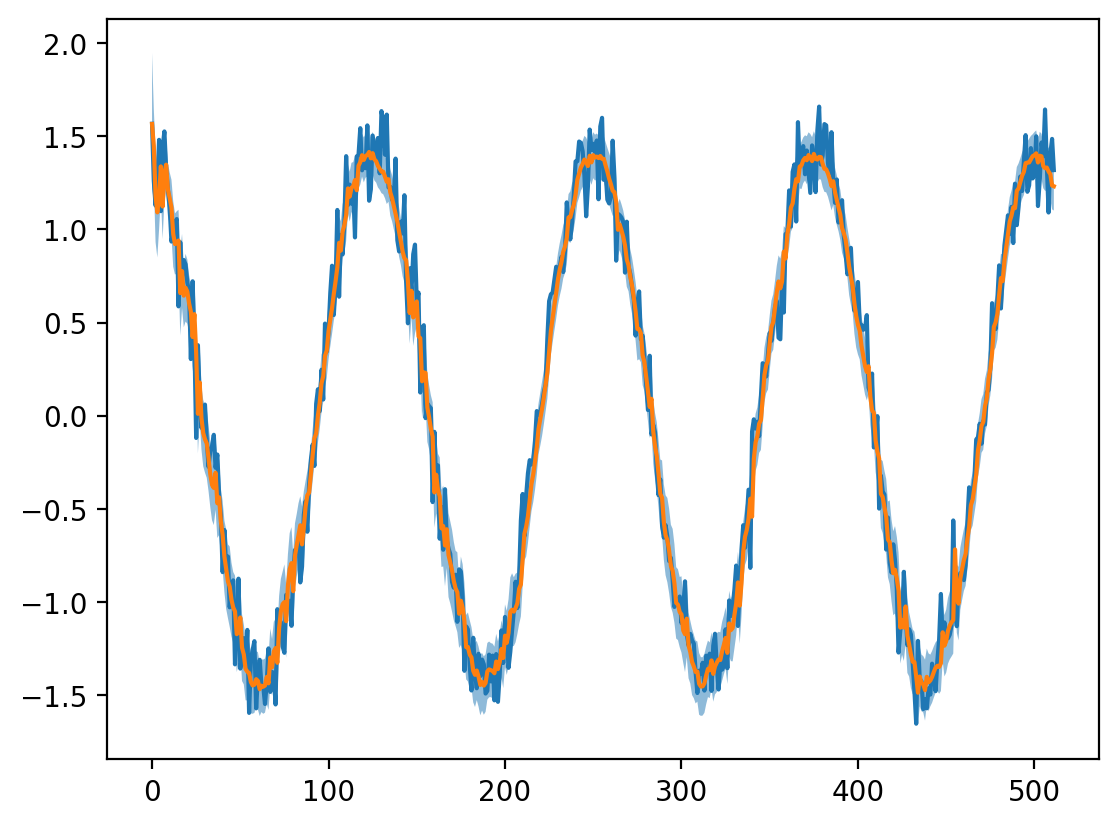

In [35]:
i = 2
batched_data = data_batch[0].to(device)
batched_data_true = data_batch[1].to(device)

output = transformer(batched_data)
plt.plot(batched_data_true[i, :].cpu())
mean = output[i, :, 0].detach().cpu()
std = torch.sqrt(torch.nn.functional.softplus(output[i, :, 1].detach().cpu()))
plt.plot(mean)
plt.fill_between(np.arange(mean.shape[0]), mean - std, mean + std, alpha=0.5)
plt.show()

In [36]:
def grab_series(max_sequence_length):
    rand_idx = torch.randint(0, training_data.shape[0], (1,))[0]
    normalized_series = (
        training_data[rand_idx] - np.mean(training_data[rand_idx])
    ) / np.std(training_data[rand_idx])

    truncated_series = normalized_series[0:max_sequence_length]
    return torch.tensor(truncated_series, dtype=torch.float32).unsqueeze(-1).unsqueeze(
        0
    ), torch.tensor(normalized_series, dtype=torch.float32)

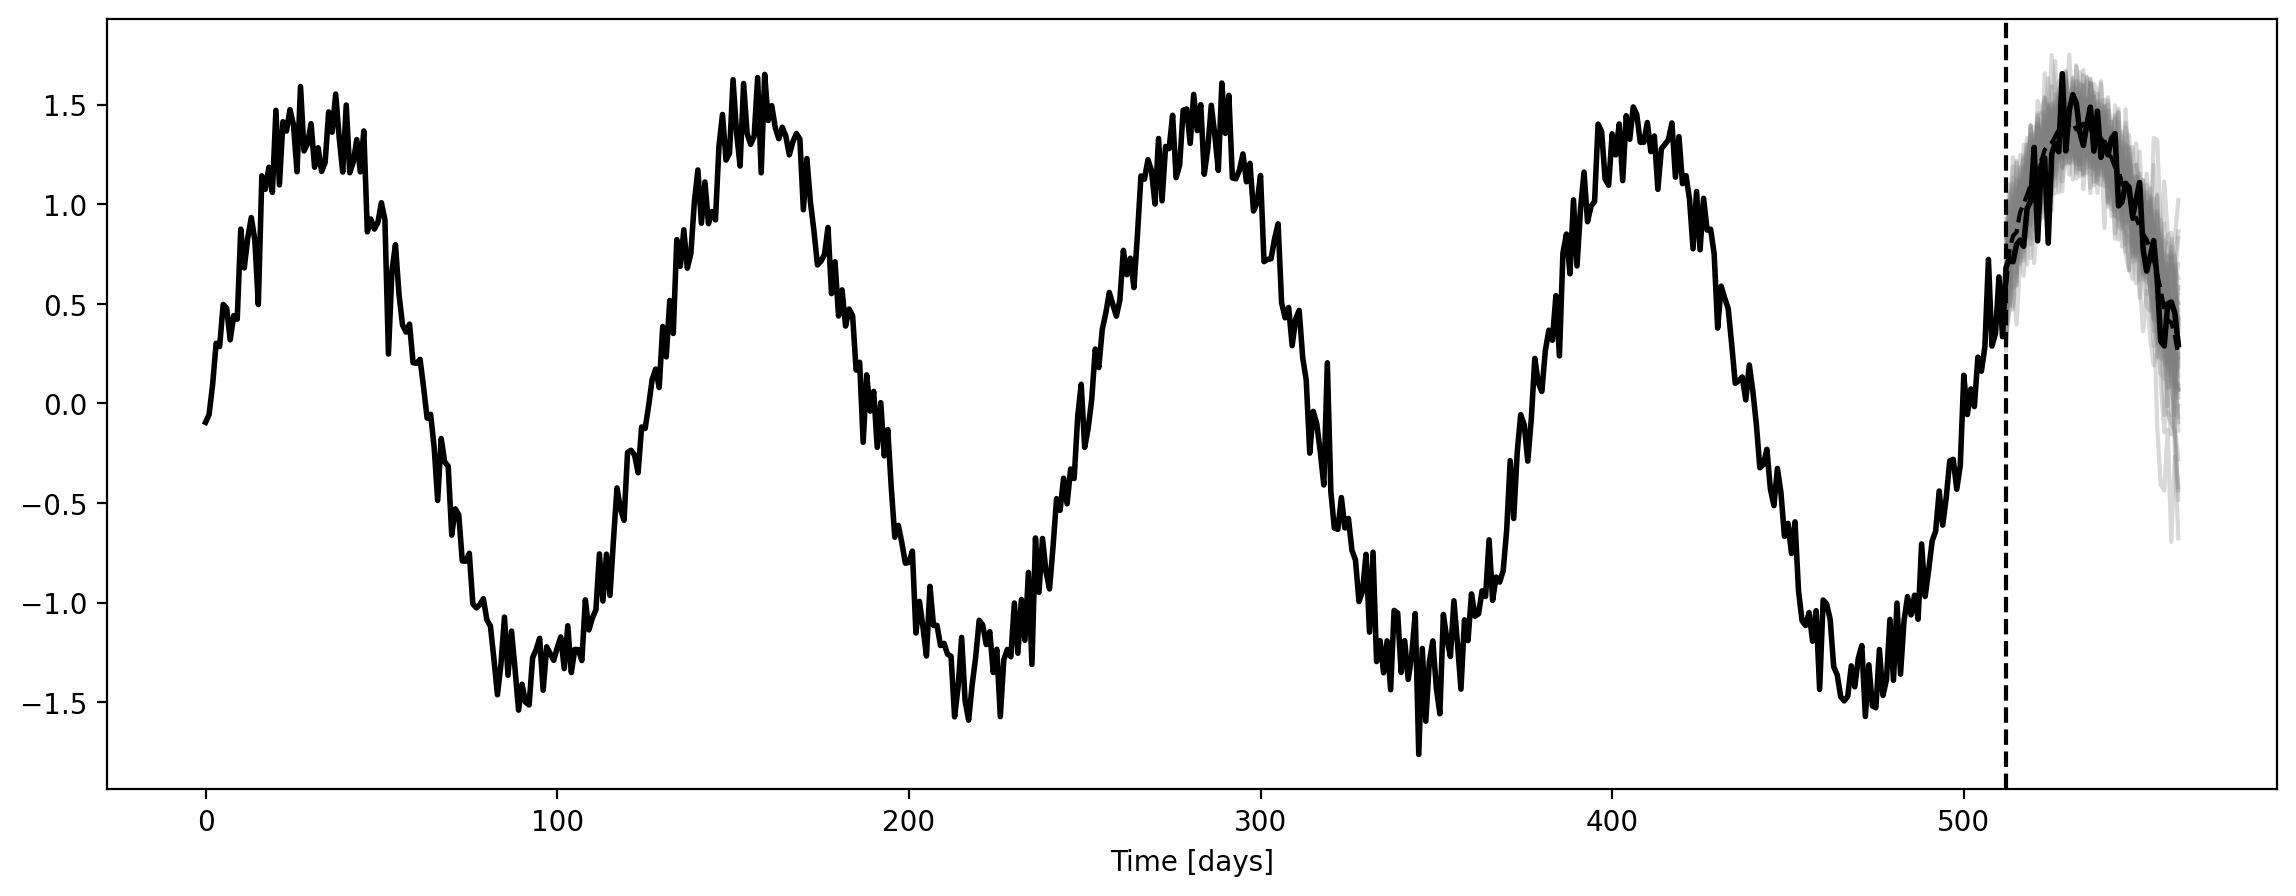

In [44]:
Nlines = 50
n_sequence = 50
test_data = grab_series(max_seq_length)
plt.figure(figsize=(14, 5))

for i in range(Nlines):
    # Generate the next n_sequence elements
    generated_sequence = []

    transformer.eval()

    # Initial input for the model
    current_input = test_data[0].to(device)

    sequence = transformer.generate(current_input, n_sequence)

    if i == 0:
        sequence_average = sequence
    else:
        sequence_average += sequence
    plt.plot(
        np.arange(
            current_input[0].squeeze().shape[0],
            current_input[0].squeeze().shape[0] + sequence.shape[1],
        ),
        sequence[0, :].detach().cpu(),
        alpha=0.3,
        color="grey",
    )

plt.plot(
    np.arange(
        current_input[0].squeeze().shape[0],
        current_input[0].squeeze().shape[0] + sequence.shape[1],
    ),
    sequence_average[0, :].detach().cpu() / Nlines,
    color="k",
    ls="--",
)
total_sequence_length = max_seq_length + n_sequence
plt.axvline(current_input[0].squeeze().shape[0], color="k", ls="--")
plt.plot(
    np.arange(0, total_sequence_length),
    test_data[1].cpu()[0:total_sequence_length],
    color="k",
    lw=2,
)
plt.xlabel("Time [days]")
# plt.ylabel("Temperature [C]")
plt.show()

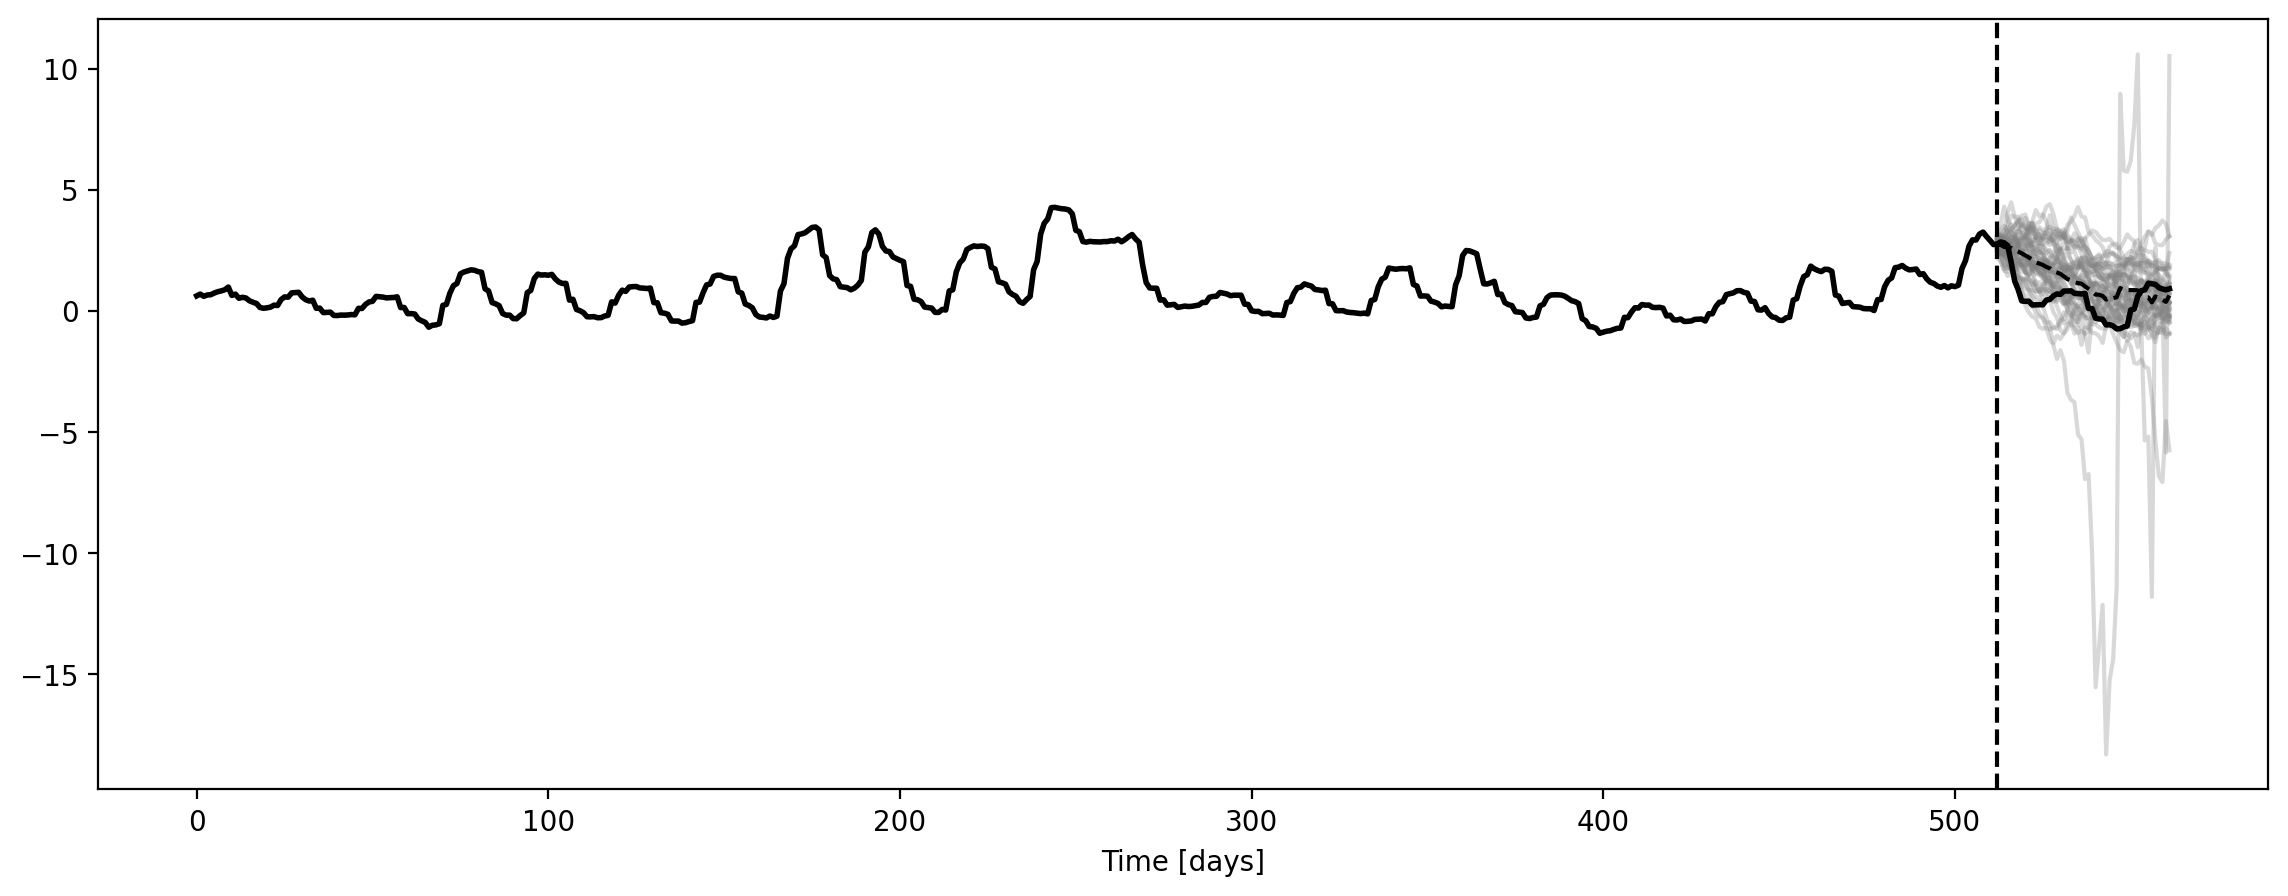

In [45]:
Nlines = 50
n_sequence = 50
test_data = grab_series(max_seq_length)
plt.figure(figsize=(14, 5))

for i in range(Nlines):
    # Generate the next n_sequence elements
    generated_sequence = []

    transformer.eval()

    # Initial input for the model
    current_input = test_data[0].to(device)

    sequence = transformer.generate(current_input, n_sequence)

    if i == 0:
        sequence_average = sequence
    else:
        sequence_average += sequence
    plt.plot(
        np.arange(
            current_input[0].squeeze().shape[0],
            current_input[0].squeeze().shape[0] + sequence.shape[1],
        ),
        sequence[0, :].detach().cpu(),
        alpha=0.3,
        color="grey",
    )

plt.plot(
    np.arange(
        current_input[0].squeeze().shape[0],
        current_input[0].squeeze().shape[0] + sequence.shape[1],
    ),
    sequence_average[0, :].detach().cpu() / Nlines,
    color="k",
    ls="--",
)
total_sequence_length = max_seq_length + n_sequence
plt.axvline(current_input[0].squeeze().shape[0], color="k", ls="--")
plt.plot(
    np.arange(0, total_sequence_length),
    test_data[1].cpu()[0:total_sequence_length],
    color="k",
    lw=2,
)
plt.xlabel("Time [days]")
# plt.ylabel("Temperature [C]")
plt.show()